In [2]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, get_data, get_data_softDrop
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

def eval_filter(kf,R,n=100):
    xmin, ymin, xmax, ymax = -R, -R, R, R
    nx = ny = n
    # construct grid of inputs
    xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    XY = np.asarray([X, Y]).reshape((1, 2, nx*ny)).transpose((0, 2, 1))
    # evaluate function
    Z = kf(XY)[0].reshape(nx, ny, L).transpose((2, 0, 1))
    return X, Y, Z

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quark jets, R = 0.8

In [3]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=True,efrac=True,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('q',hlevel=False,efrac=True,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [5]:
# Save test set inputs
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2qq_WTA_testSet_inputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("test",data=test)
    f.create_dataset("labels",data=test_labels)

## Make non-WTA input files

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=True,efrac=True,base=base,nmax=nmax,wta=False)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('q',hlevel=False,efrac=True,base=base,nmax=nmax,wta=False)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall.h5


In [3]:
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2qq_testSet_inputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("test",data=test)
    f.create_dataset("labels",data=test_labels)

## EFNs

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2023-09-19 15:18:29.454658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 15:18:30.152120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 15:18:30.152543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 15:18:30.153271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/100
  7/391 [..............................] - ETA: 3s - loss: 0.6935 - acc: 0.5243   

2023-09-19 15:18:35.560700: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 7s 12ms/step - loss: 0.5491 - acc: 0.7100 - val_loss: 0.4442 - val_acc: 0.7964
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 0.4387 - acc: 0.7954 - val_loss: 0.4646 - val_acc: 0.7728
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 0.4173 - acc: 0.8086 - val_loss: 0.4128 - val_acc: 0.8134
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 0.4046 - acc: 0.8167 - val_loss: 0.3983 - val_acc: 0.8204
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 0.4021 - acc: 0.8188 - val_loss: 0.4012 - val_acc: 0.8206
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3927 - acc: 0.8250 - val_loss: 0.3736 - val_acc: 0.8357
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3888 - acc: 0.8285 - val_loss: 0.3660 - val_acc: 0.8404
Epoch 8/100
391/391 [==============================] - 4s 10ms/step - loss

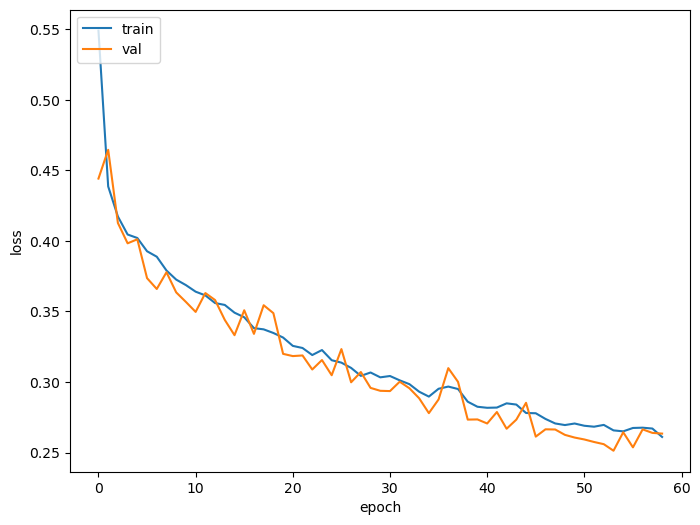

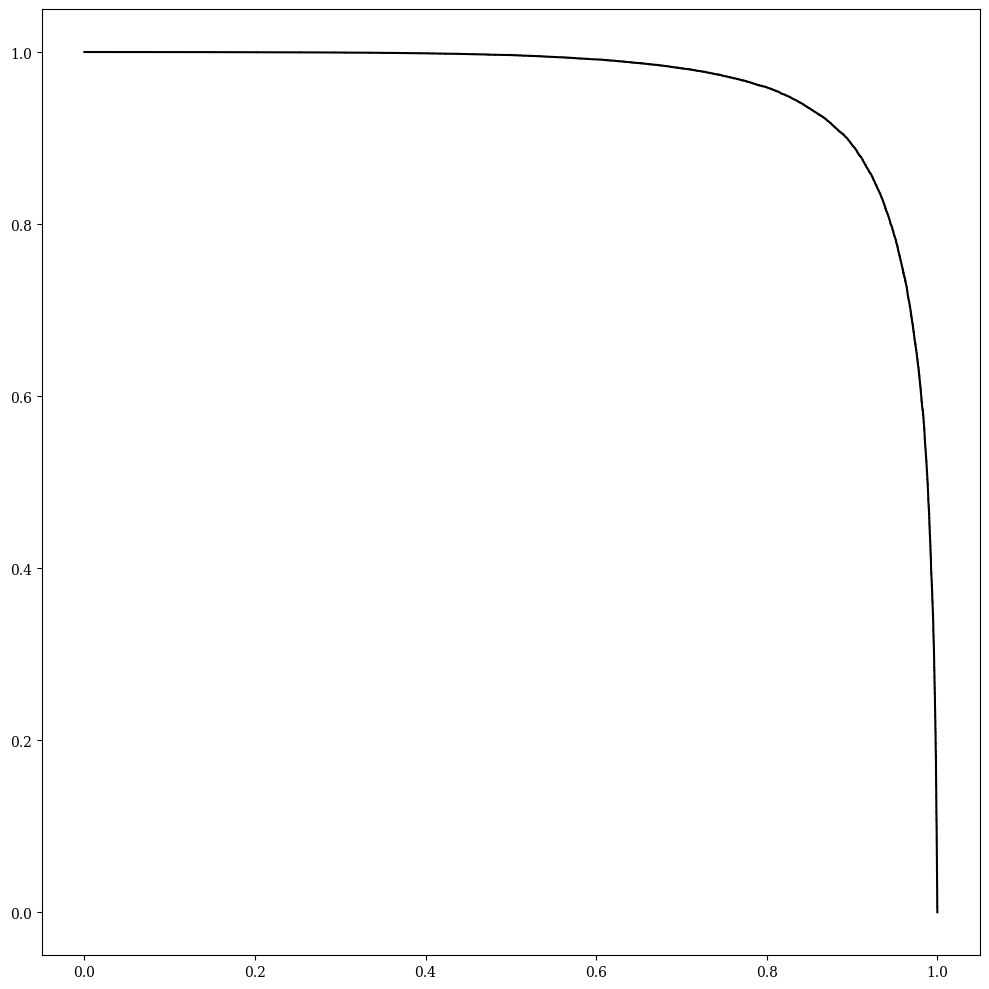

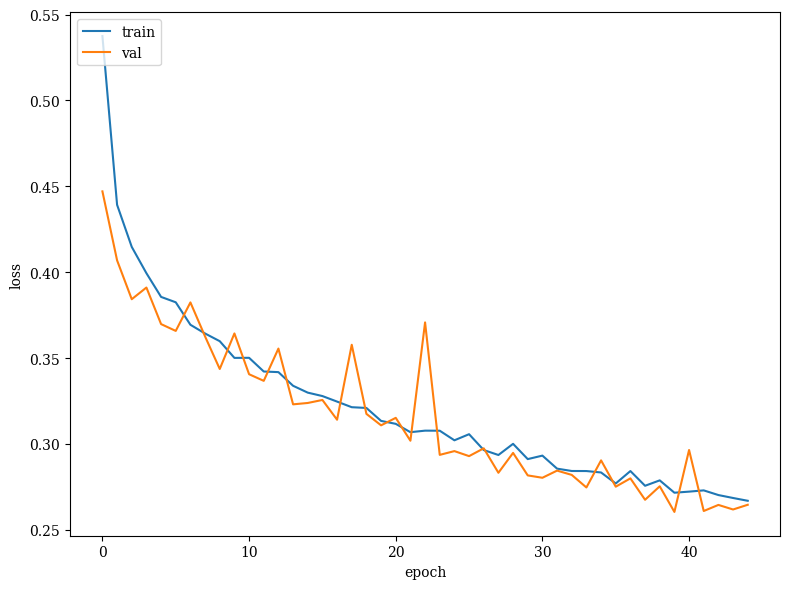

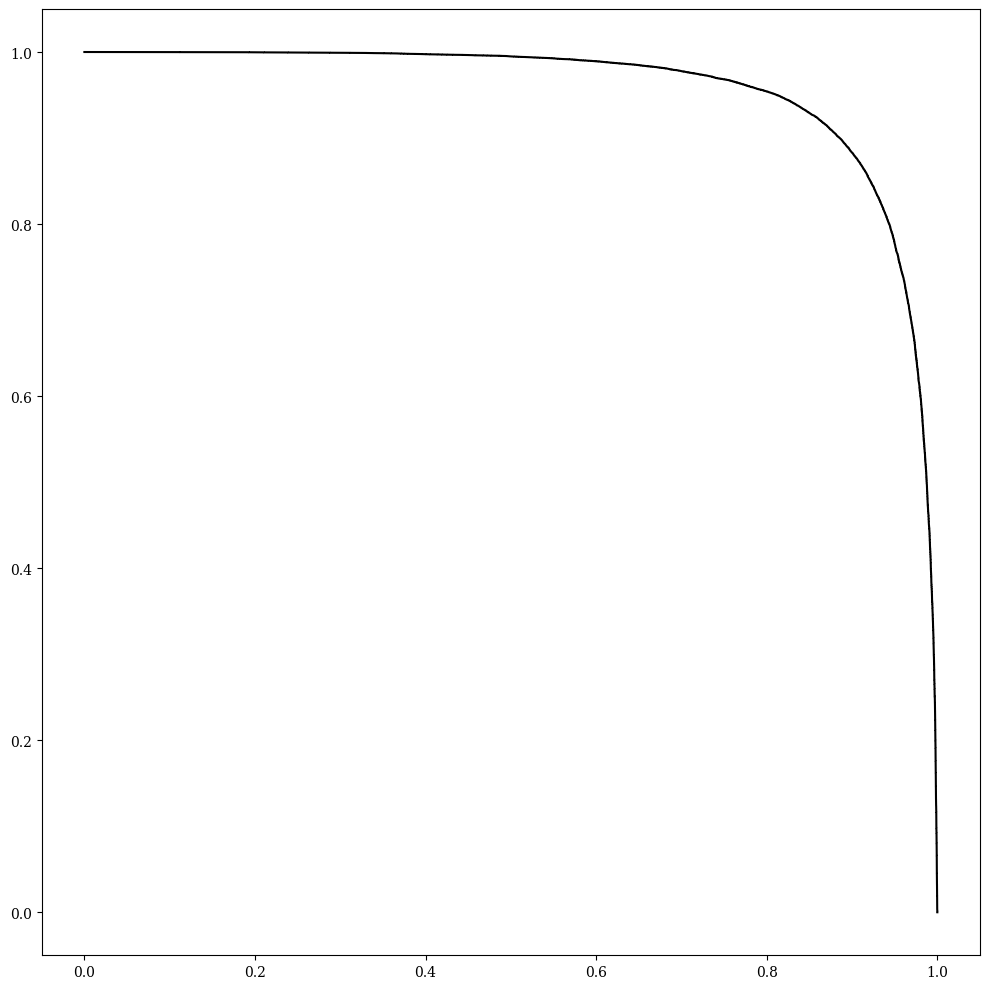

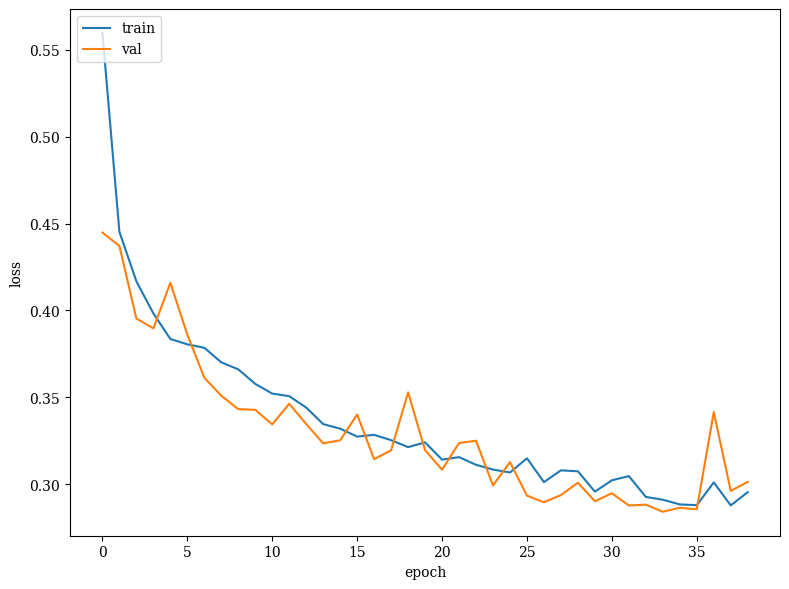

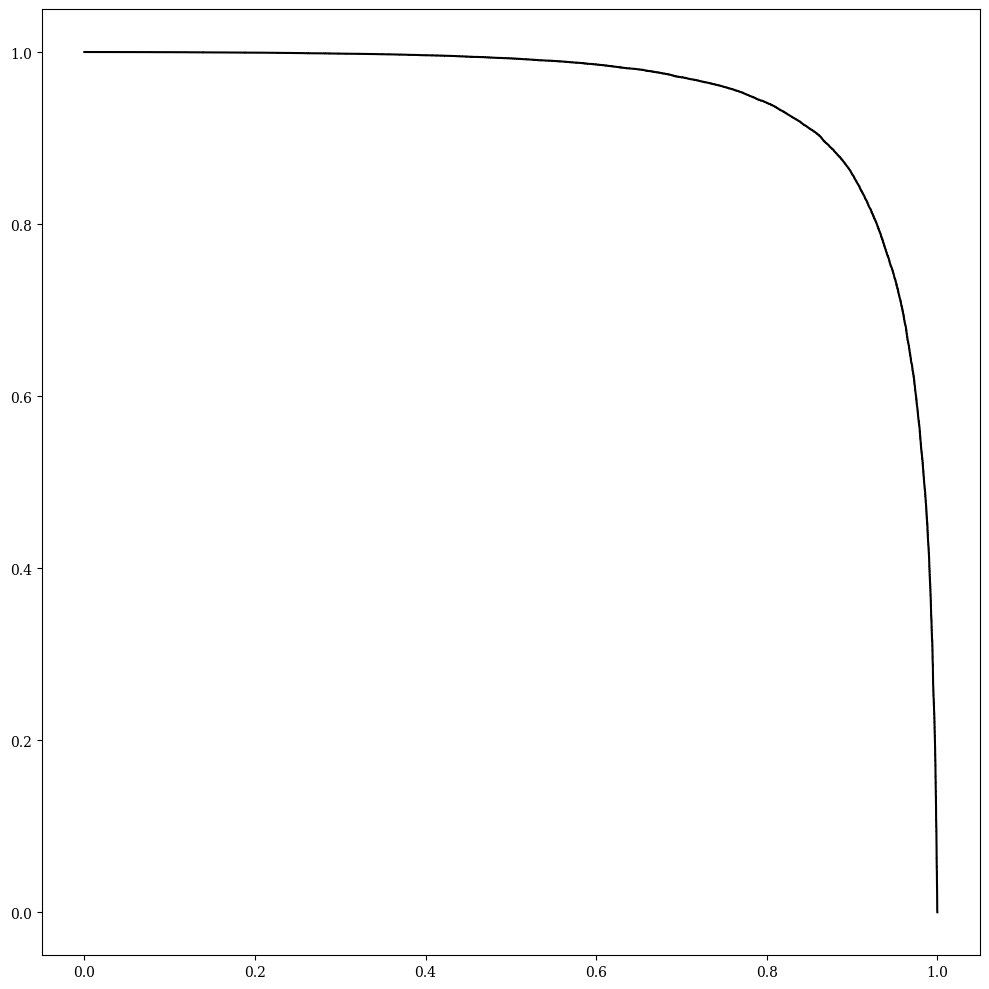

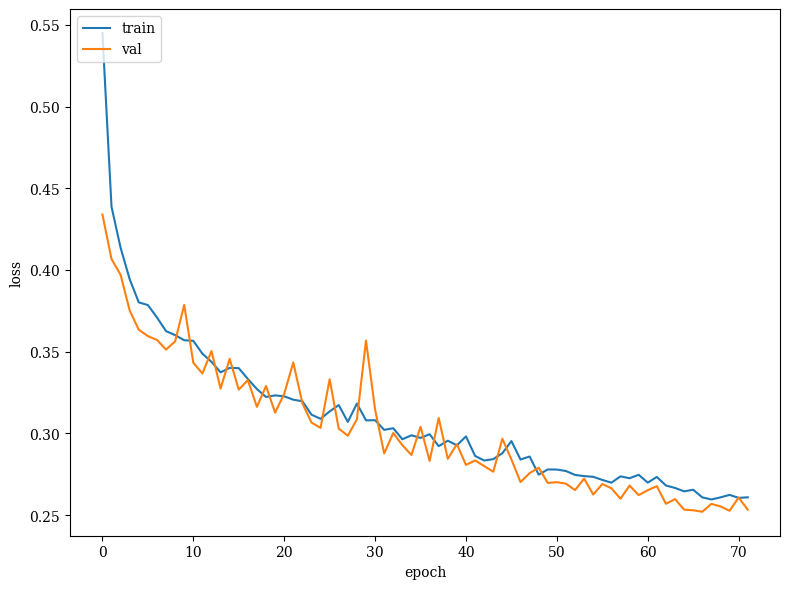

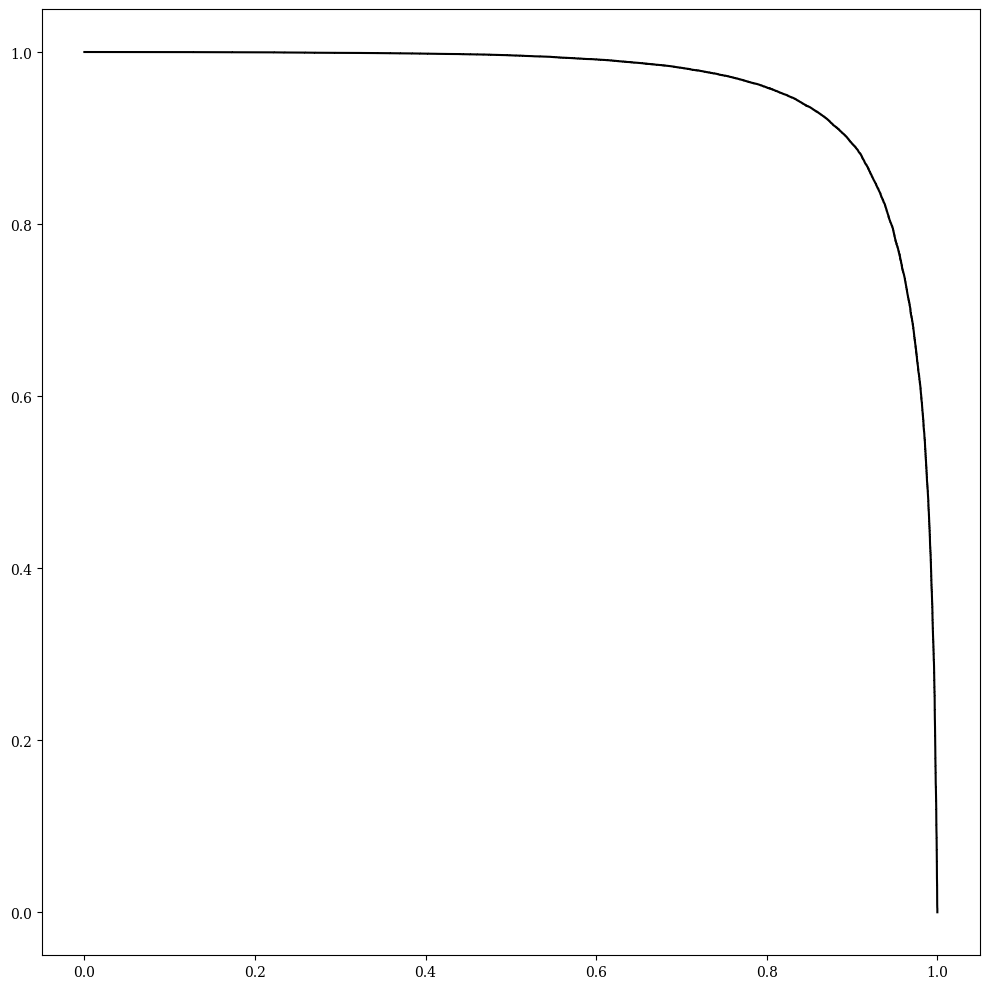

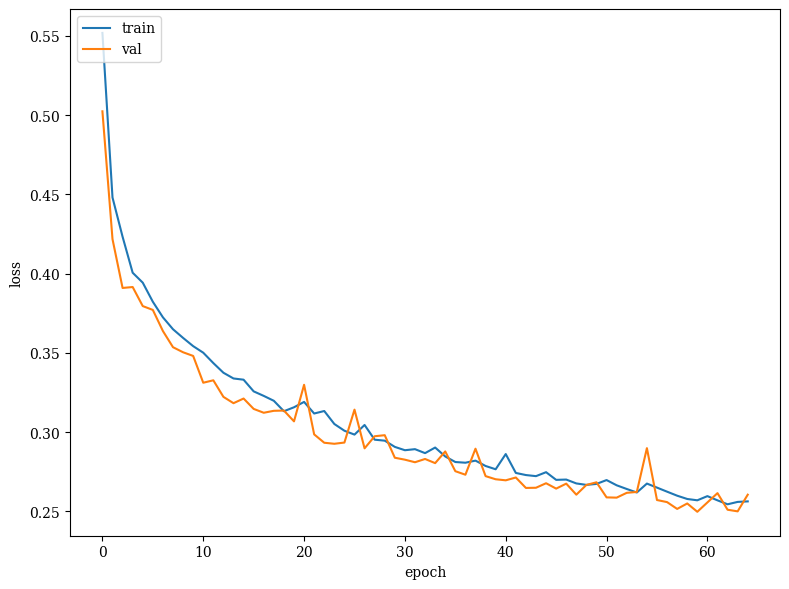

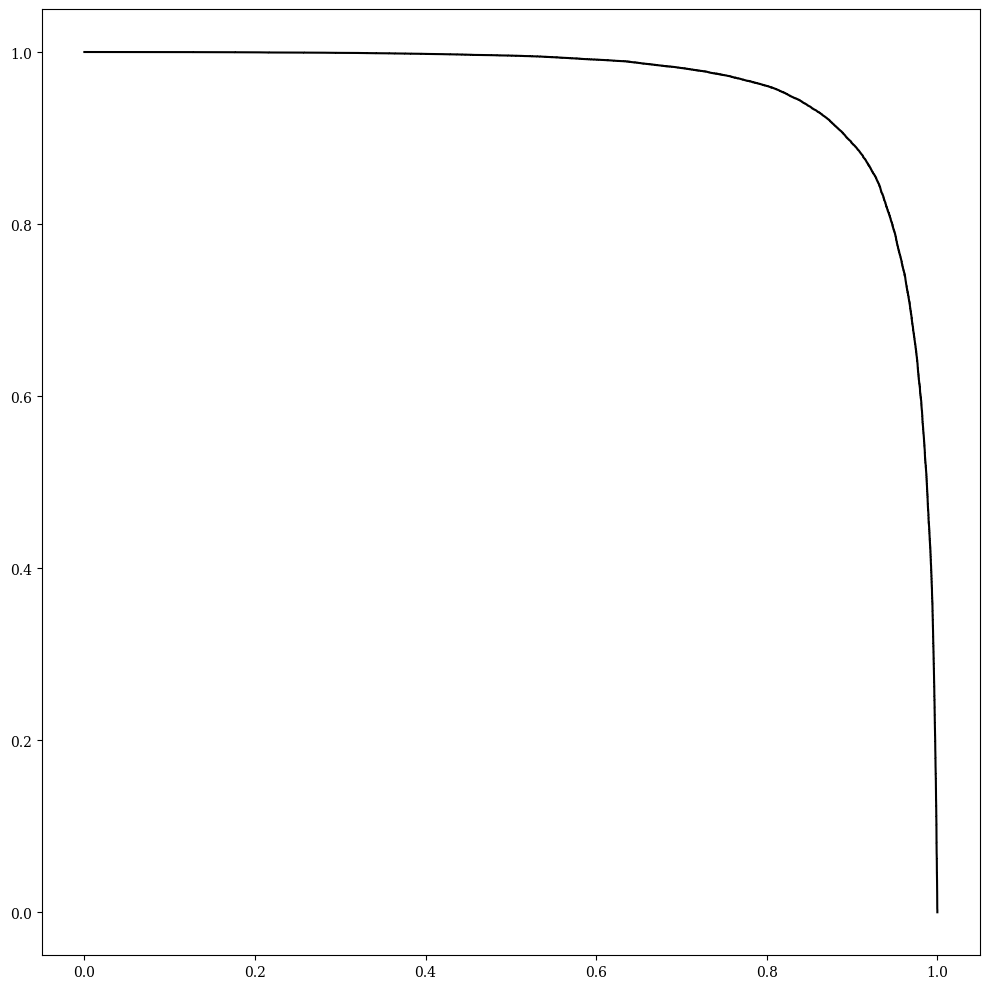

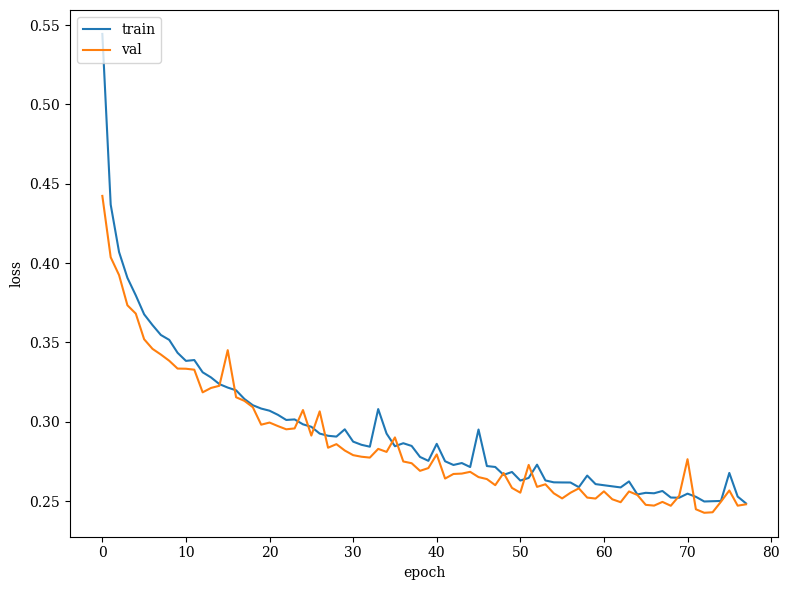

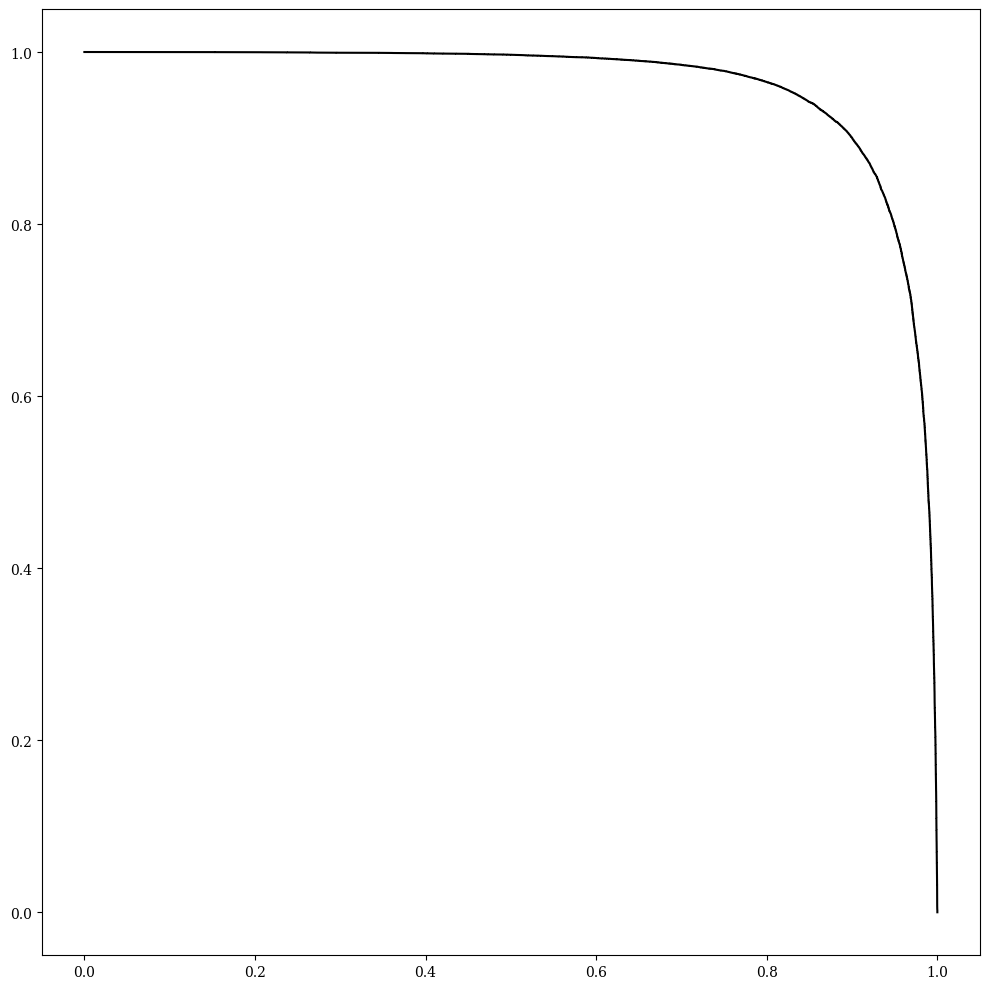

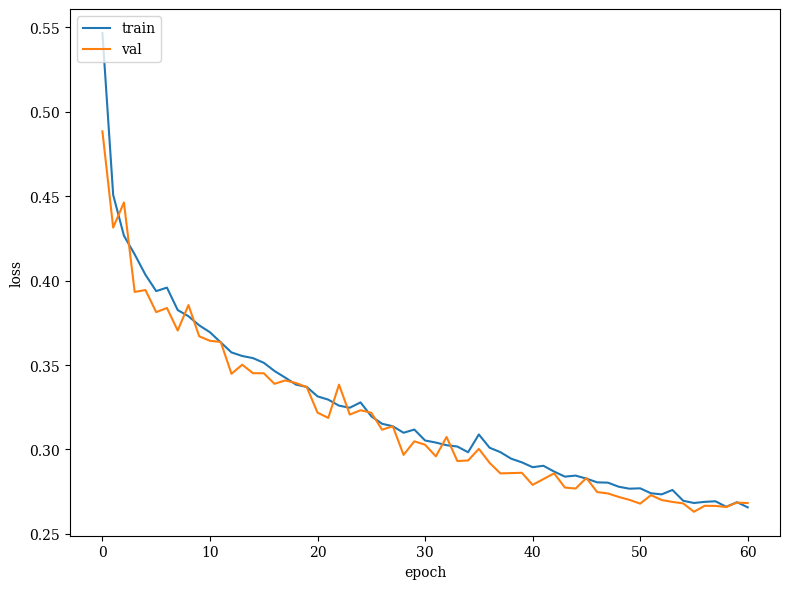

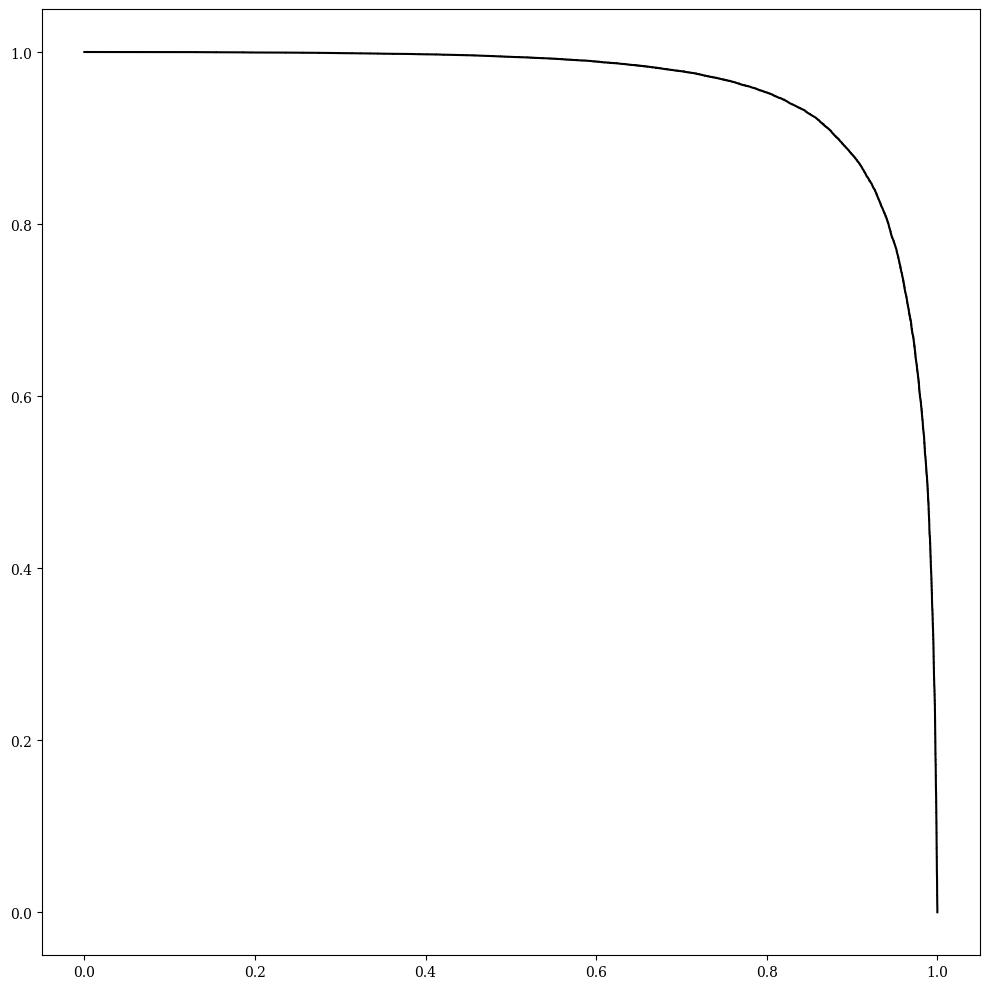

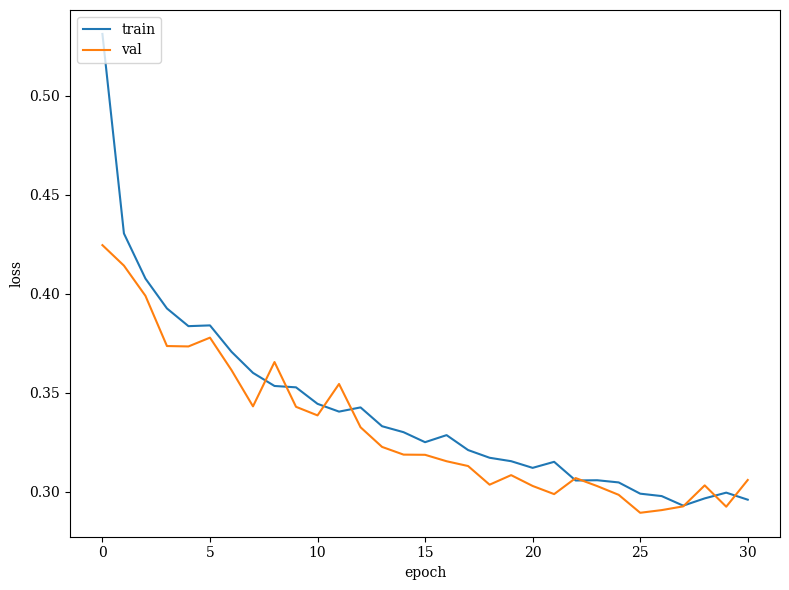

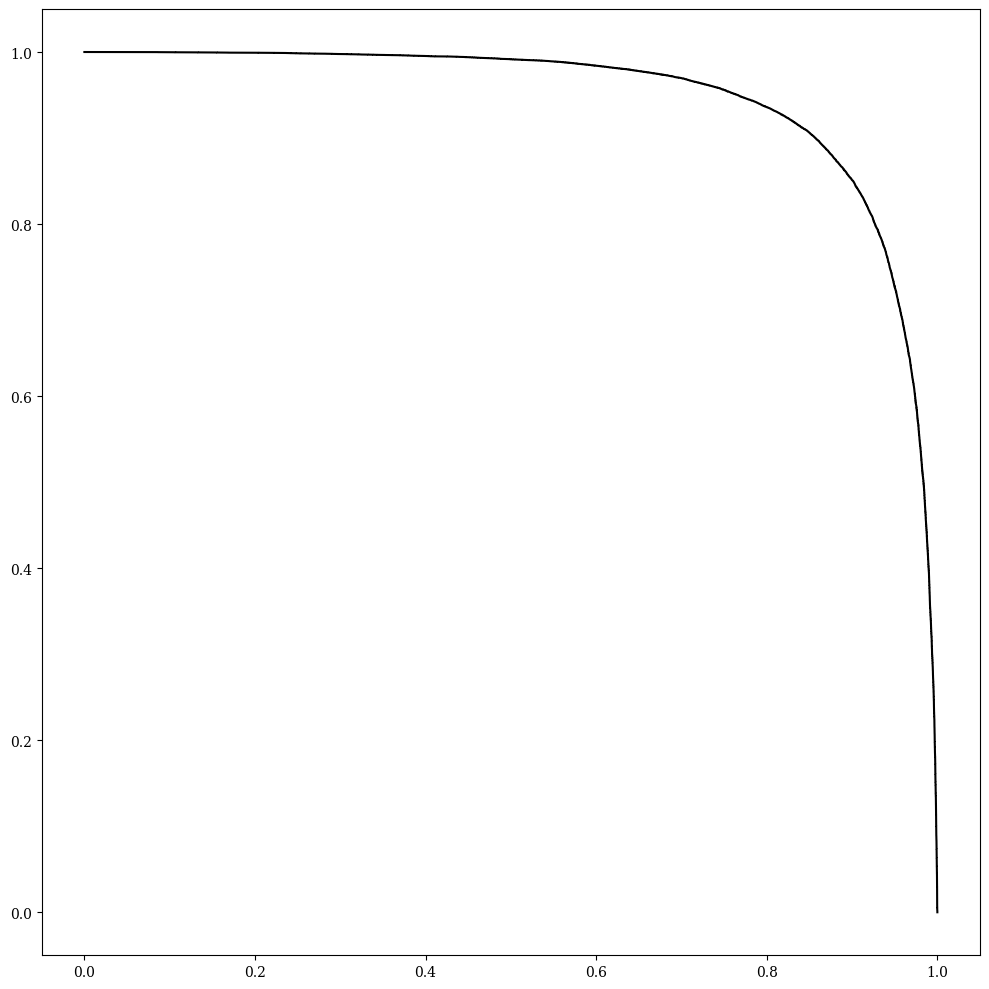

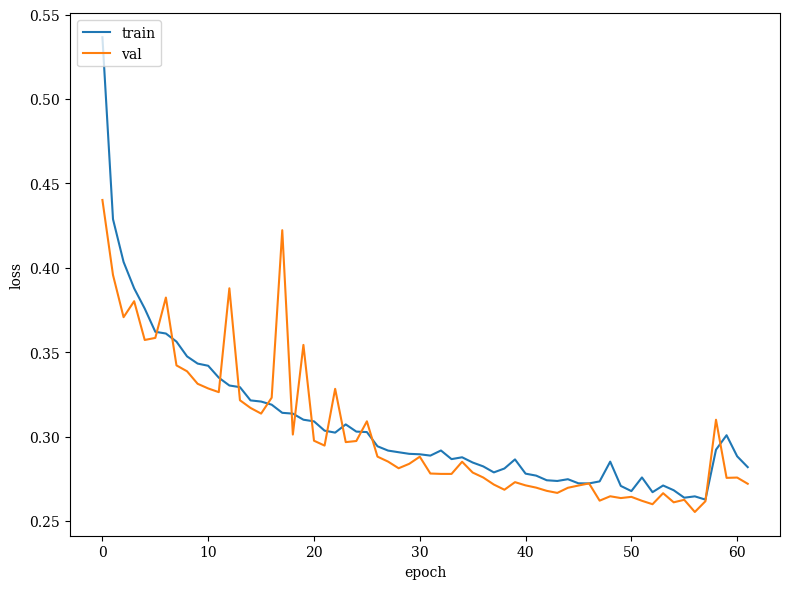

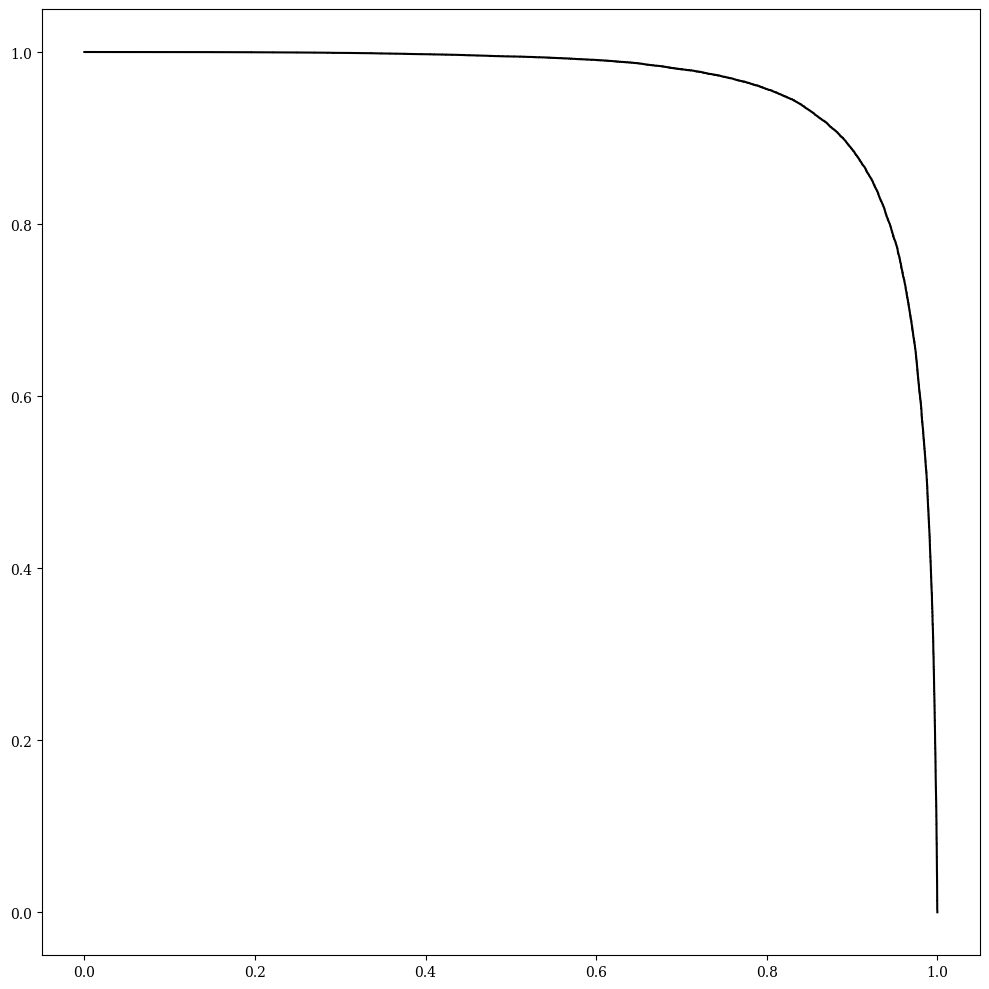

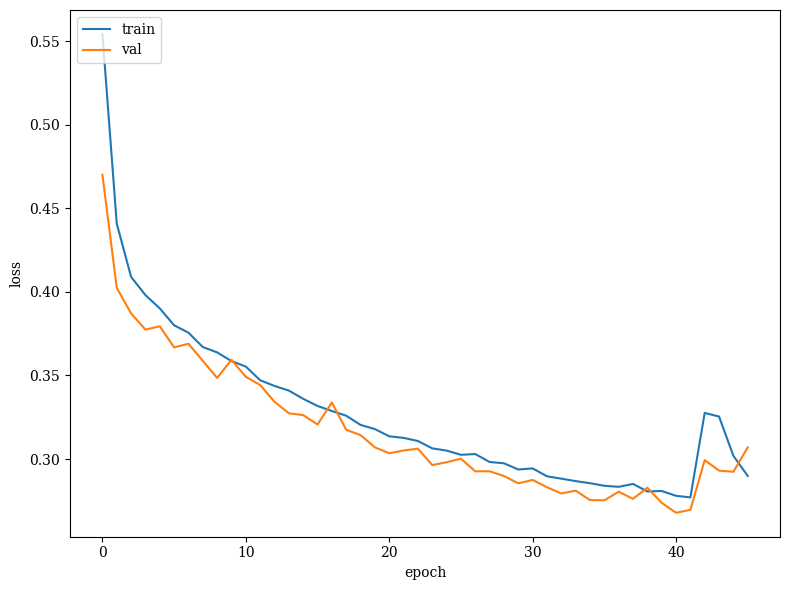

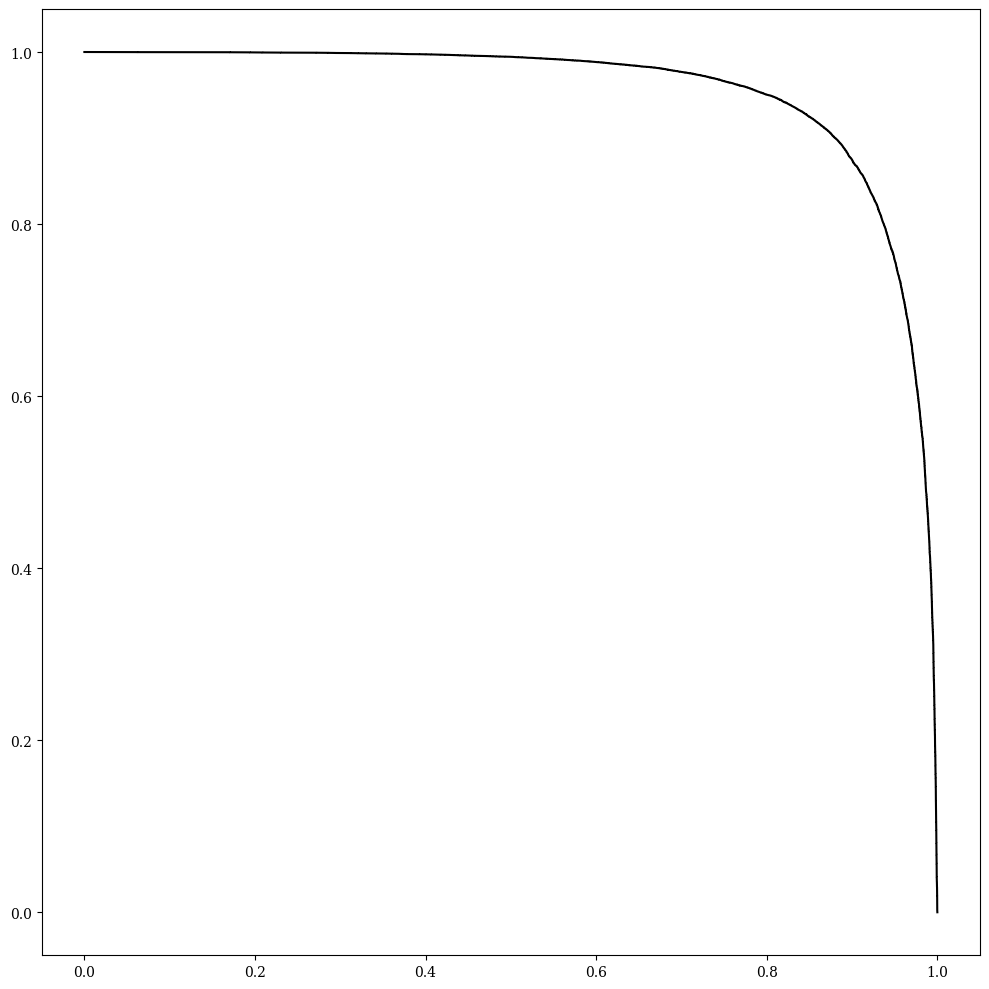

In [3]:
# Regular EFN, no spectral normalization
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":100,"verbose":1,"batch_size":512}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta/qjet_EFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

In [ ]:
# EFN with spectral normalization
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta/qjet_spectralEFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

2023-09-19 16:13:59.721682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 16:14:00.353770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 16:14:00.354130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 16:14:00.374829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation[0][0]']             
                                                                                              

2023-09-19 16:14:05.382150: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/150
20/20 [==============================] - 6s 173ms/step - loss: 0.6931 - acc: 0.5100 - val_loss: 0.6931 - val_acc: 0.5420
Epoch 2/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6930 - acc: 0.5323 - val_loss: 0.6930 - val_acc: 0.5286
Epoch 3/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6930 - acc: 0.5305 - val_loss: 0.6930 - val_acc: 0.5262
Epoch 4/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6930 - acc: 0.5235 - val_loss: 0.6929 - val_acc: 0.5251
Epoch 5/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6929 - acc: 0.5227 - val_loss: 0.6929 - val_acc: 0.5194
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5167 - val_loss: 0.6929 - val_acc: 0.5208
Epoch 7/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6929 - acc: 0.5272 - val_loss: 0.6929 - val_acc: 0.5201
Epoch 8/150
20/20 [==============================] - 3s 141ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 163ms/step - loss: 0.6931 - acc: 0.5312 - val_loss: 0.6930 - val_acc: 0.5203
Epoch 2/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6930 - acc: 0.5180 - val_loss: 0.6930 - val_acc: 0.5187
Epoch 3/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6930 - acc: 0.5162 - val_loss: 0.6929 - val_acc: 0.5159
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6929 - acc: 0.5155 - val_loss: 0.6929 - val_acc: 0.5176
Epoch 5/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6929 - acc: 0.5151 - val_loss: 0.6929 - val_acc: 0.5167
Epoch 6/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6929 - acc: 0.5174 - val_loss: 0.6928 - val_acc: 0.5168
Epoch 7/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6928 - acc: 0.5152 - val_loss: 0.6928 - val_acc: 0.5144
Epoch 8/150
20/20 [==============================] - 3s 132ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 170ms/step - loss: 0.6931 - acc: 0.5200 - val_loss: 0.6930 - val_acc: 0.5214
Epoch 2/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6930 - acc: 0.5229 - val_loss: 0.6929 - val_acc: 0.5207
Epoch 3/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6929 - acc: 0.5193 - val_loss: 0.6929 - val_acc: 0.5167
Epoch 4/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5175 - val_loss: 0.6929 - val_acc: 0.5177
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6928 - acc: 0.5161 - val_loss: 0.6928 - val_acc: 0.5166
Epoch 6/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6928 - acc: 0.5175 - val_loss: 0.6928 - val_acc: 0.5130
Epoch 7/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6928 - acc: 0.5138 - val_loss: 0.6928 - val_acc: 0.5130
Epoch 8/150
20/20 [==============================] - 3s 133ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 174ms/step - loss: 0.6931 - acc: 0.5344 - val_loss: 0.6931 - val_acc: 0.5466
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5382 - val_loss: 0.6930 - val_acc: 0.5392
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5321 - val_loss: 0.6930 - val_acc: 0.5213
Epoch 4/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5191 - val_loss: 0.6929 - val_acc: 0.5196
Epoch 5/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6929 - acc: 0.5179 - val_loss: 0.6929 - val_acc: 0.5192
Epoch 6/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6929 - acc: 0.5170 - val_loss: 0.6929 - val_acc: 0.5156
Epoch 7/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6929 - acc: 0.5182 - val_loss: 0.6929 - val_acc: 0.5139
Epoch 8/150
20/20 [==============================] - 3s 139ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 170ms/step - loss: 0.6931 - acc: 0.5287 - val_loss: 0.6931 - val_acc: 0.5252
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5223 - val_loss: 0.6930 - val_acc: 0.5193
Epoch 3/150
20/20 [==============================] - 3s 147ms/step - loss: 0.6930 - acc: 0.5249 - val_loss: 0.6930 - val_acc: 0.5164
Epoch 4/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5184 - val_loss: 0.6929 - val_acc: 0.5171
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5217 - val_loss: 0.6929 - val_acc: 0.5179
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5159 - val_loss: 0.6929 - val_acc: 0.5162
Epoch 7/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6929 - acc: 0.5147 - val_loss: 0.6929 - val_acc: 0.5157
Epoch 8/150
20/20 [==============================] - 3s 139ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 173ms/step - loss: 0.6931 - acc: 0.5358 - val_loss: 0.6930 - val_acc: 0.5308
Epoch 2/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6930 - acc: 0.5267 - val_loss: 0.6930 - val_acc: 0.5252
Epoch 3/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6930 - acc: 0.5236 - val_loss: 0.6929 - val_acc: 0.5220
Epoch 4/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6929 - acc: 0.5183 - val_loss: 0.6929 - val_acc: 0.5240
Epoch 5/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6929 - acc: 0.5189 - val_loss: 0.6929 - val_acc: 0.5179
Epoch 6/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6929 - acc: 0.5189 - val_loss: 0.6929 - val_acc: 0.5176
Epoch 7/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6929 - acc: 0.5171 - val_loss: 0.6928 - val_acc: 0.5161
Epoch 8/150
20/20 [==============================] - 3s 142ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 174ms/step - loss: 0.6931 - acc: 0.5099 - val_loss: 0.6930 - val_acc: 0.5232
Epoch 2/150
20/20 [==============================] - 3s 146ms/step - loss: 0.6930 - acc: 0.5242 - val_loss: 0.6929 - val_acc: 0.5221
Epoch 3/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6929 - acc: 0.5188 - val_loss: 0.6929 - val_acc: 0.5197
Epoch 4/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6929 - acc: 0.5212 - val_loss: 0.6929 - val_acc: 0.5183
Epoch 5/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6928 - acc: 0.5163 - val_loss: 0.6928 - val_acc: 0.5184
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6928 - acc: 0.5174 - val_loss: 0.6928 - val_acc: 0.5159
Epoch 7/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6928 - acc: 0.5149 - val_loss: 0.6928 - val_acc: 0.5173
Epoch 8/150
20/20 [==============================] - 3s 137ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 169ms/step - loss: 0.6931 - acc: 0.5227 - val_loss: 0.6930 - val_acc: 0.5441
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6930 - acc: 0.5339 - val_loss: 0.6930 - val_acc: 0.5304
Epoch 3/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6930 - acc: 0.5247 - val_loss: 0.6929 - val_acc: 0.5252
Epoch 4/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6929 - acc: 0.5237 - val_loss: 0.6929 - val_acc: 0.5202
Epoch 5/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6929 - acc: 0.5226 - val_loss: 0.6929 - val_acc: 0.5182
Epoch 6/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6929 - acc: 0.5175 - val_loss: 0.6929 - val_acc: 0.5182
Epoch 7/150
20/20 [==============================] - 3s 147ms/step - loss: 0.6929 - acc: 0.5190 - val_loss: 0.6928 - val_acc: 0.5155
Epoch 8/150
20/20 [==============================] - 3s 135ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 153ms/step - loss: 0.6931 - acc: 0.5125 - val_loss: 0.6931 - val_acc: 0.5328
Epoch 2/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6930 - acc: 0.5265 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 3/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6930 - acc: 0.5279 - val_loss: 0.6929 - val_acc: 0.5192
Epoch 4/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6929 - acc: 0.5230 - val_loss: 0.6929 - val_acc: 0.5177
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5176 - val_loss: 0.6929 - val_acc: 0.5164
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5155 - val_loss: 0.6929 - val_acc: 0.5188
Epoch 7/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6929 - acc: 0.5231 - val_loss: 0.6928 - val_acc: 0.5188
Epoch 8/150
20/20 [==============================] - 3s 139ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 161ms/step - loss: 0.6931 - acc: 0.5308 - val_loss: 0.6931 - val_acc: 0.5395
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6931 - acc: 0.5343 - val_loss: 0.6930 - val_acc: 0.5256
Epoch 3/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6930 - acc: 0.5246 - val_loss: 0.6930 - val_acc: 0.5245
Epoch 4/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6930 - acc: 0.5245 - val_loss: 0.6930 - val_acc: 0.5206
Epoch 5/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6929 - acc: 0.5209 - val_loss: 0.6929 - val_acc: 0.5198
Epoch 6/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6929 - acc: 0.5188 - val_loss: 0.6929 - val_acc: 0.5159
Epoch 7/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6927 - acc: 0.5161 - val_loss: 0.6927 - val_acc: 0.5154
Epoch 25/150
20/20 [==============================] - 3s 146ms/step -

In [4]:
# EFN with spectral normalization and eps_bjorck = None and bound_only = True
Ls = [100]
#for L in range(1,11,1):
for L in Ls:
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(100,100,128), "F_sizes":(100,100,100),
                    "F_acts":"relu","Phi_acts":"relu",
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,
                    "output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    model_kwargs['lip_const'] = float(L)
    model_kwargs['eps_bjorck'] = None
    model_kwargs['bound_only'] = True
    train_kwargs = {"epochs":200,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta/qjet_spectralEFN_L{int(L)}_noBjorck_boundOnly_zpT.keras")
    del efn
    gc.collect()

2024-02-12 20:38:49.682742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 20:38:49.713473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 20:38:49.713845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-12 20:38:49.714748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

InternalError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul]

## L = 2

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    300         ['phats_input[0][0]']            
                                                                                                  
 activation_7 (Activation)      (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation_7[0][0]']           
                                                                                            

2067

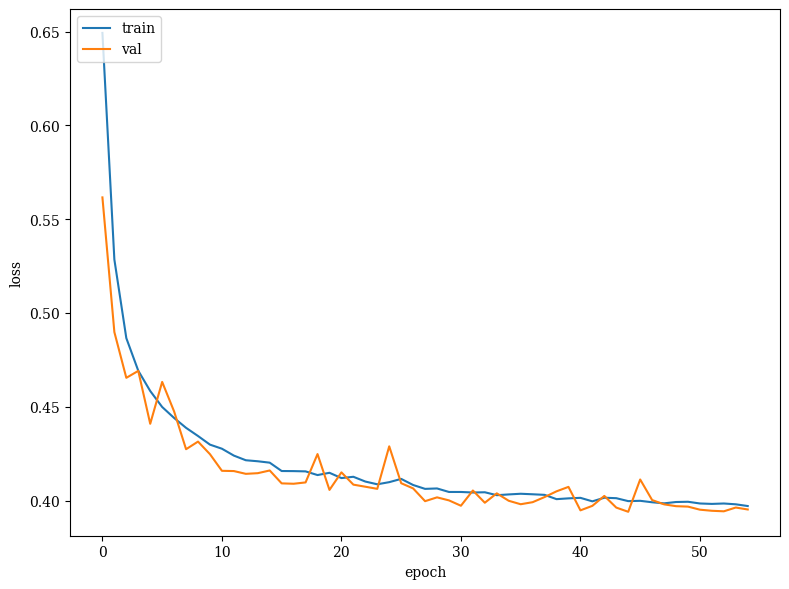

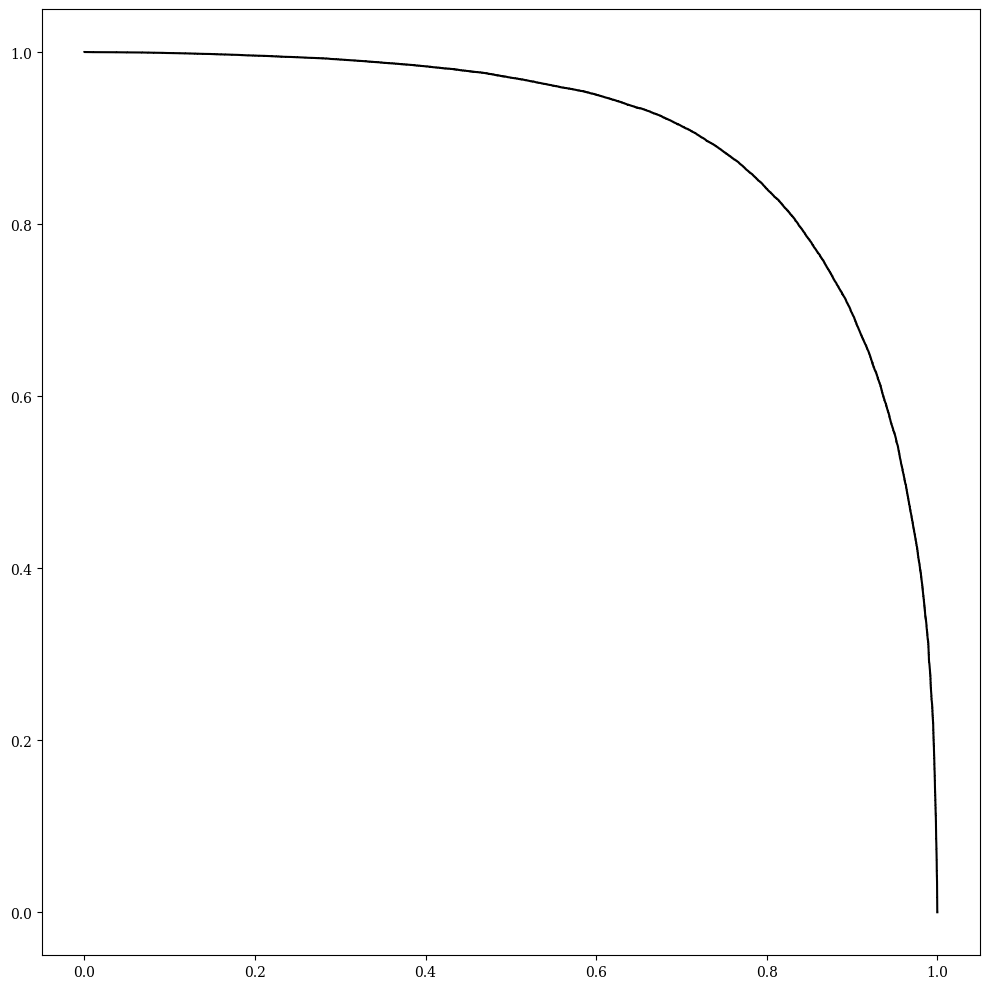

In [10]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 2
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
#efn.save("keras_models_wta_Lsmall/qjet_EFN_zpT_L2.keras")
#del efn
gc.collect()

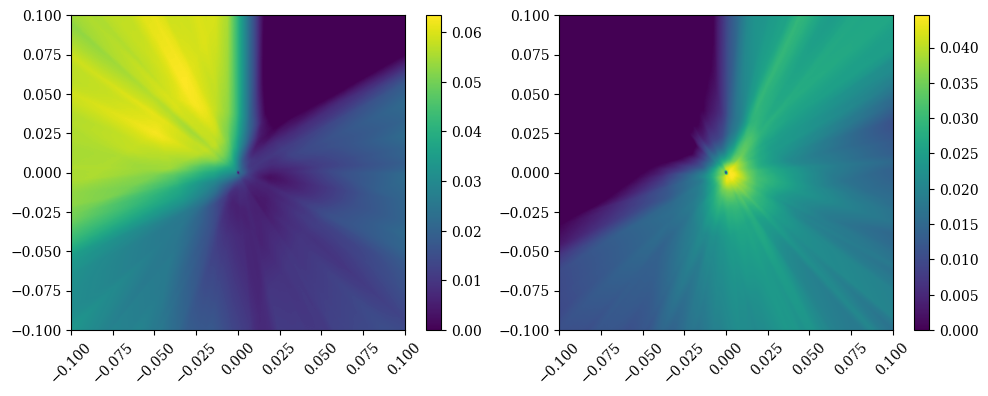

In [12]:
from matplotlib.colors import LogNorm, Normalize
R = 0.1
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

In [11]:
import tensorflow.keras.backend as K

In [12]:
s = efn.Phi_sizes[-1]
in_t, out_t = efn.inputs[1], efn._tensors[efn._tensor_inds['latent'][0]-1]
# construct function
kf = K.function(in_t,out_t)
kf2 = K.function(efn._tensors[efn._tensor_inds['latent'][1]-1],efn._tensors[-1])

In [18]:
nx=300
ny=300
xmax = 0.5
xmin = 0
ymax= 0.5
ymin = 0
xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(xs, ys, indexing='ij')
XY = np.asarray([X, Y]).reshape((2, nx*ny)).transpose(1,0)
s = 1

# evaluate function
Z = kf2(XY).reshape(nx, ny)

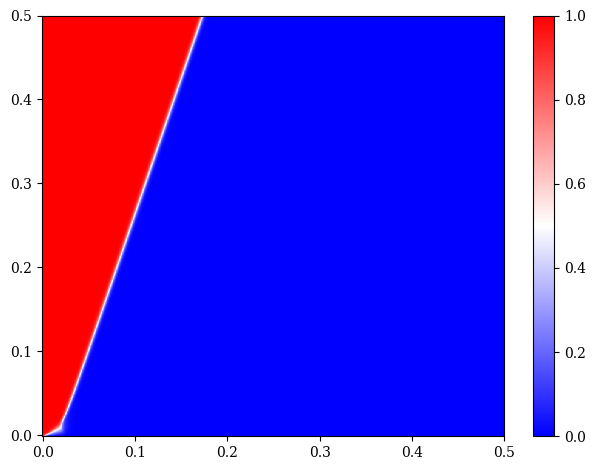

In [19]:
plt.imshow(Z.T,origin='lower',extent=[-0.001,xmax,-0.001,ymax],aspect='auto',cmap='bwr')
plt.colorbar()

In [63]:
def process(chunk):
    return np.sum(chunk[:,:,:1]*kf(chunk[:,:,1:]),axis=1)
def label(chunk):
    return kf2(chunk)
split = np.array_split(np.arange(len(test)),len(test)//1000)
latent = []
out = []
out2 = []
for sp in split:
    l = process(test[sp])
    o = label(l)
    latent.append(l)
    out.append(o)
    out2.append(efn.predict([test[sp][:,:,0],test[sp][:,:,1:]]))
latent = np.concatenate(latent,axis=0)
out = np.concatenate(out,axis=0)
out2 = np.concatenate(out2,axis=0)

32/32 [==============================] - 0s 1ms/step


## L = 1

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 150)    450         ['phats_input[0][0]']            
                                                                                                  
 activation_14 (Activation)     (None, None, 150)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 150)    22650       ['activation_14[0][0]']          
                                                                                            

0

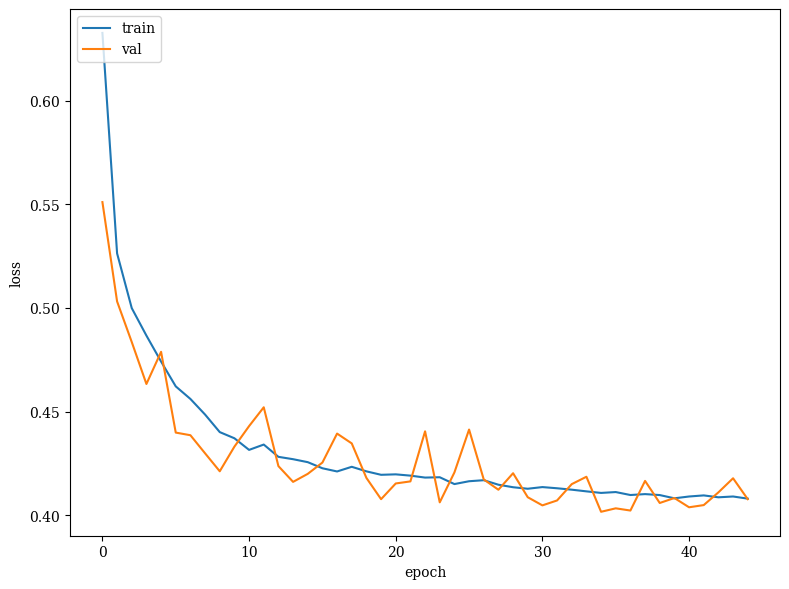

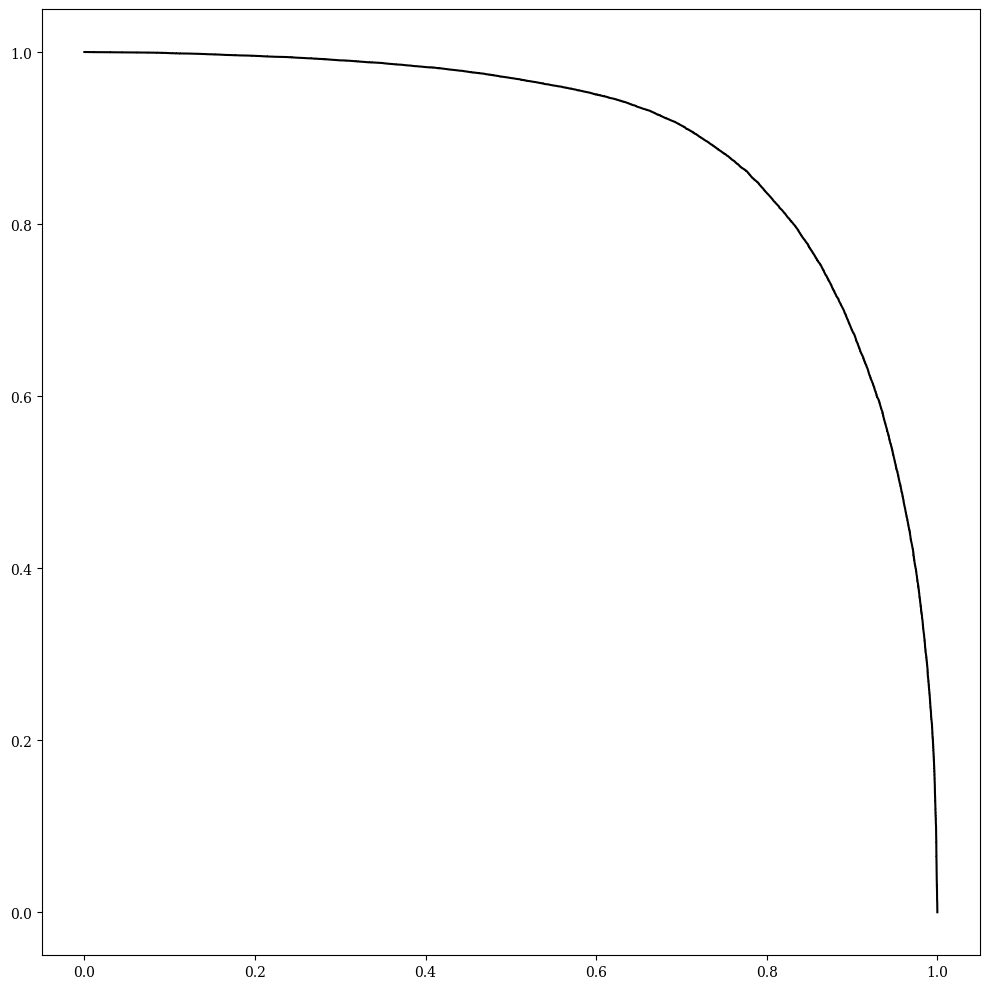

In [14]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 1
model_kwargs = {"Phi_sizes":(150,150,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models_wta_Lsmall/qjet_EFN_zpT_L1.keras")
#del efn
gc.collect()

In [25]:
import tensorflow.keras.backend as K
model = keras.models.load_model("keras_models_wta_Lsmall/qjet_EFN_zpT_L1_iter1.keras")

In [15]:
model = efn.model
kf = K.function(model.layers[0].input,model.layers[8].output)
def eval_filter(kf,R,n=100):
    xmin, ymin, xmax, ymax = -R, -R, R, R
    nx = ny = n
    # construct grid of inputs
    xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    XY = np.asarray([X, Y]).reshape((1, 2, nx*ny)).transpose((0, 2, 1))
    # evaluate function
    Z = kf(XY)[0].reshape(nx, ny, L).transpose((2, 0, 1))
    return X, Y, Z

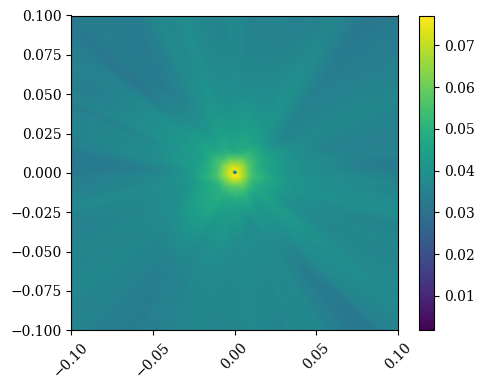

In [20]:
from matplotlib.colors import LogNorm, Normalize
from scipy.optimize import curve_fit
R = 0.1
#X,Y,Z = efn.eval_filters(R,prune=False,n=1000)
X,Y,Z = eval_filter(kf,R,n=1000)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,1,figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes)
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

/tmp/ipykernel_33647/550370407.py:2: RuntimeWarning: invalid value encountered in log
  return a - b*np.log(x+c)


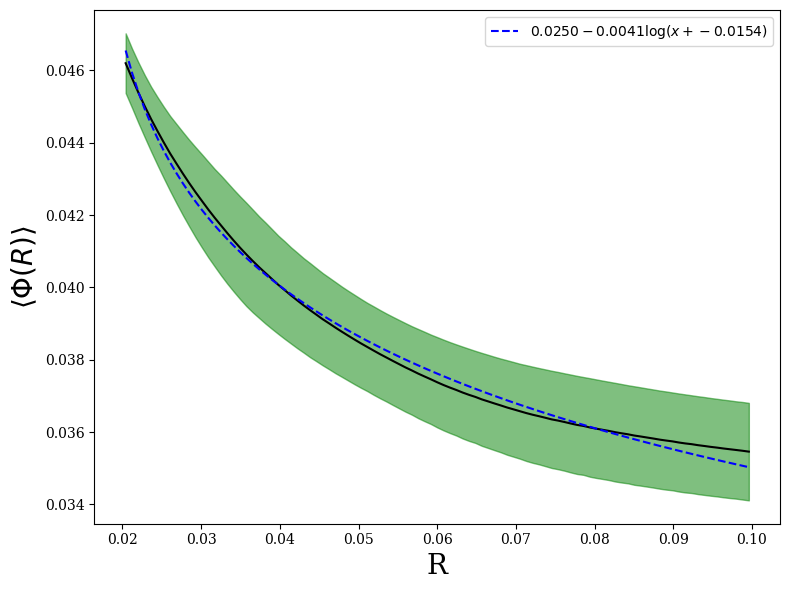

In [22]:
def log_func(x,a,b,c):
    return a - b*np.log(x+c)
R = np.sqrt(X**2 + Y**2)
rbins = np.linspace(0.02,0.1,100)
bin_centers = (rbins[:-1]+rbins[1:])/2
r_inds = np.digitize(R.flatten(),rbins)-1
z_means = np.array([np.mean(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])
z_stds = np.array([np.std(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])

remove = np.isnan(z_means) | np.isnan(z_stds)

popt, pcov = curve_fit(log_func, bin_centers[~remove], z_means[~remove], sigma=z_stds[~remove])
#popt, pcov = curve_fit(log_func, R.flatten(),Z.flatten())
plt.figure(figsize=(8,6))
plt.plot(bin_centers,z_means,zorder=2,color='black')
plt.fill_between(bin_centers,z_means+z_stds,z_means-z_stds,color='green',alpha=0.5,zorder=1)
plt.xlabel("R",fontsize=20)
plt.ylabel(r"$\langle \Phi(R) \rangle$",fontsize=20)
plt.plot(bin_centers,log_func(bin_centers,*popt),color='blue',linestyle='--',
         label=r"${0:.4f} - {1:.4f}\log(x+{2:.4f})$".format(popt[0],popt[1],popt[2]))
plt.legend()
#plt.plot(bin_centers,popt[0]*np.log(1/(0.01*bin_centers)))

## L = 2 Spectral

2023-10-04 20:41:20.223055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:41:20.612585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:41:20.612988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:41:20.613715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2023-10-04 20:41:24.739787: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
391/391 [==============================] - 13s 28ms/step - loss: 0.6931 - acc: 0.5069 - val_loss: 0.6930 - val_acc: 0.5150
Epoch 2/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6930 - acc: 0.5150 - val_loss: 0.6929 - val_acc: 0.5119
Epoch 3/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6929 - acc: 0.5176 - val_loss: 0.6929 - val_acc: 0.5063
Epoch 4/200
391/391 [==============================] - 10s 25ms/step - loss: 0.6929 - acc: 0.5156 - val_loss: 0.6929 - val_acc: 0.5221
Epoch 5/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6929 - acc: 0.5174 - val_loss: 0.6928 - val_acc: 0.5175
Epoch 6/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6928 - acc: 0.5176 - val_loss: 0.6929 - val_acc: 0.5048
Epoch 7/200
391/391 [==============================] - 10s 25ms/step - loss: 0.6928 - acc: 0.5183 - val_loss: 0.6928 - val_acc: 0.5082
Epoch 8/200
391/391 [==============================] - 

694

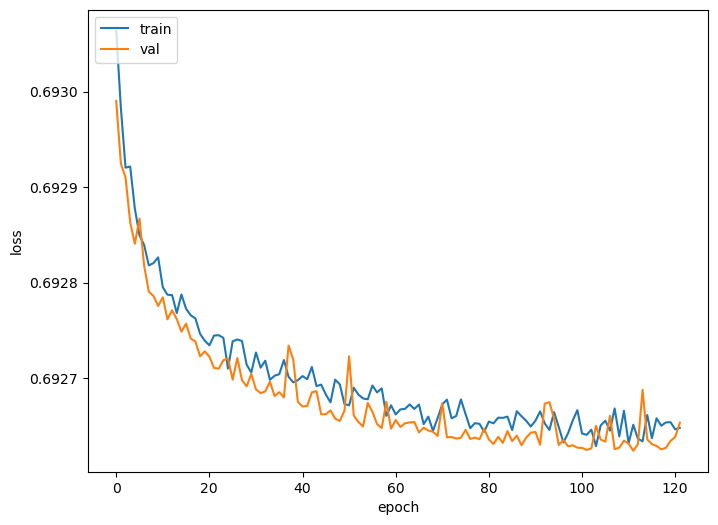

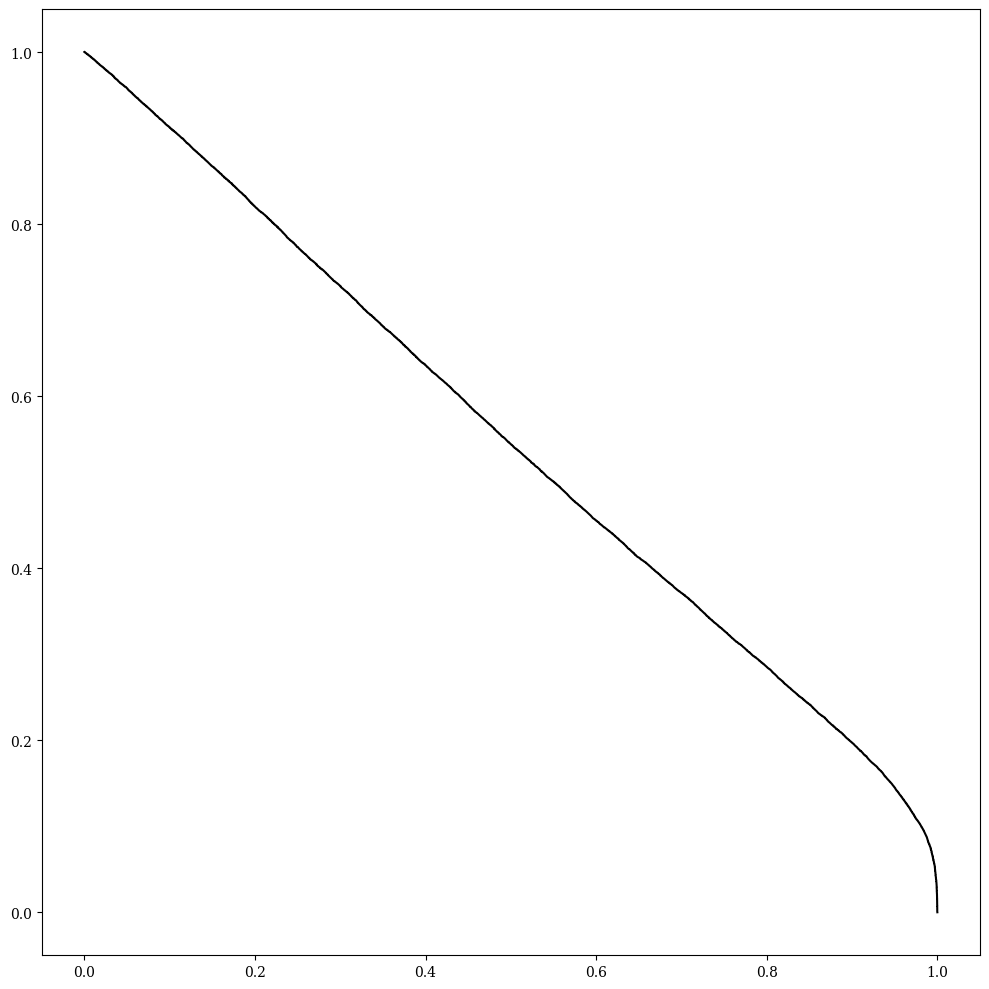

In [3]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 2
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models_wta_Lsmall/qjet_spectralEFN_zpT_L2.keras")
#del efn
gc.collect()

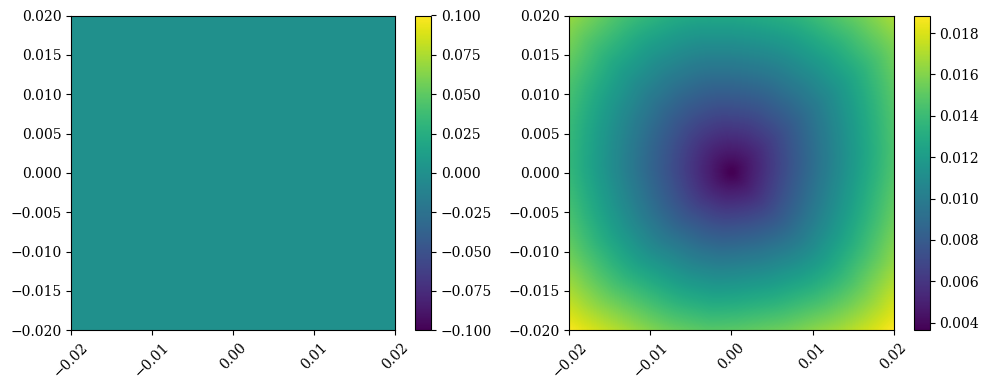

In [4]:
from matplotlib.colors import LogNorm, Normalize
R = 0.02
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

In [5]:
import tensorflow.keras.backend as K

In [6]:
s = efn.Phi_sizes[-1]
in_t, out_t = efn.inputs[1], efn._tensors[efn._tensor_inds['latent'][0]-1]
# construct function
kf = K.function(in_t,out_t)
kf2 = K.function(efn._tensors[efn._tensor_inds['latent'][1]-1],efn._tensors[-1])

In [7]:
nx=300
ny=300
xmax = 0.5
xmin = 0
ymax= 0.5
ymin = 0
xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(xs, ys, indexing='ij')
XY = np.asarray([X, Y]).reshape((2, nx*ny)).transpose(1,0)
s = 1

# evaluate function
Z = kf2(XY).reshape(nx, ny)

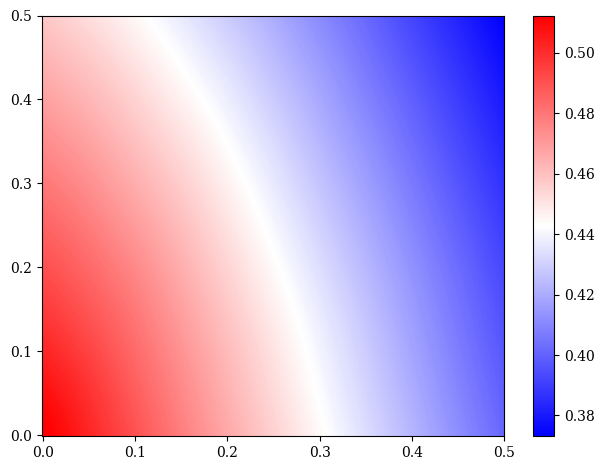

In [8]:
plt.imshow(Z.T,origin='lower',extent=[-0.001,xmax,-0.001,ymax],aspect='auto',cmap='bwr')
plt.colorbar()

## L = 2 spectral, no bjorck, bound only

2024-01-12 19:53:29.510813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 19:53:30.040729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 19:53:30.041131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-12 19:53:30.042084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2024-01-12 19:53:32.914041: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
391/391 [==============================] - 9s 19ms/step - loss: 0.6931 - acc: 0.5027 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 2/200
391/391 [==============================] - 8s 21ms/step - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6930 - val_acc: 0.5145
Epoch 3/200
391/391 [==============================] - 10s 25ms/step - loss: 0.6929 - acc: 0.5188 - val_loss: 0.6929 - val_acc: 0.5527
Epoch 4/200
391/391 [==============================] - 10s 25ms/step - loss: 0.6928 - acc: 0.5187 - val_loss: 0.6928 - val_acc: 0.5177
Epoch 5/200
391/391 [==============================] - 9s 22ms/step - loss: 0.6928 - acc: 0.5228 - val_loss: 0.6927 - val_acc: 0.5185
Epoch 6/200
391/391 [==============================] - 9s 23ms/step - loss: 0.6927 - acc: 0.5168 - val_loss: 0.6927 - val_acc: 0.5218
Epoch 7/200
391/391 [==============================] - 9s 24ms/step - loss: 0.6928 - acc: 0.5232 - val_loss: 0.6927 - val_acc: 0.5527
Epoch 8/200
391/391 [==============================] - 9s 22

704

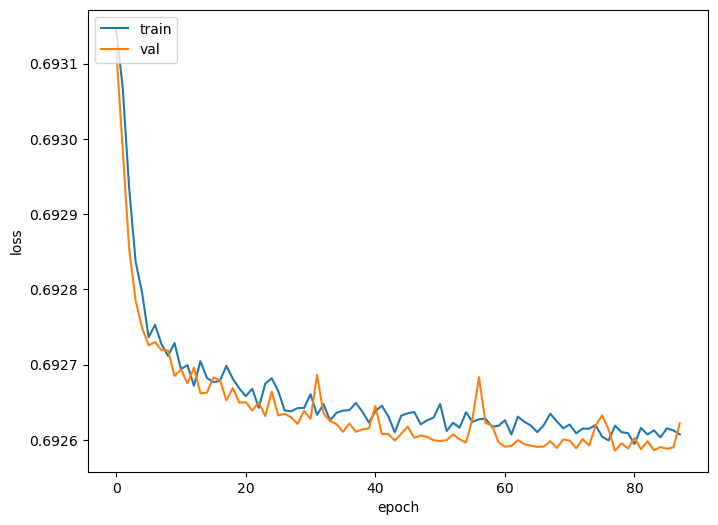

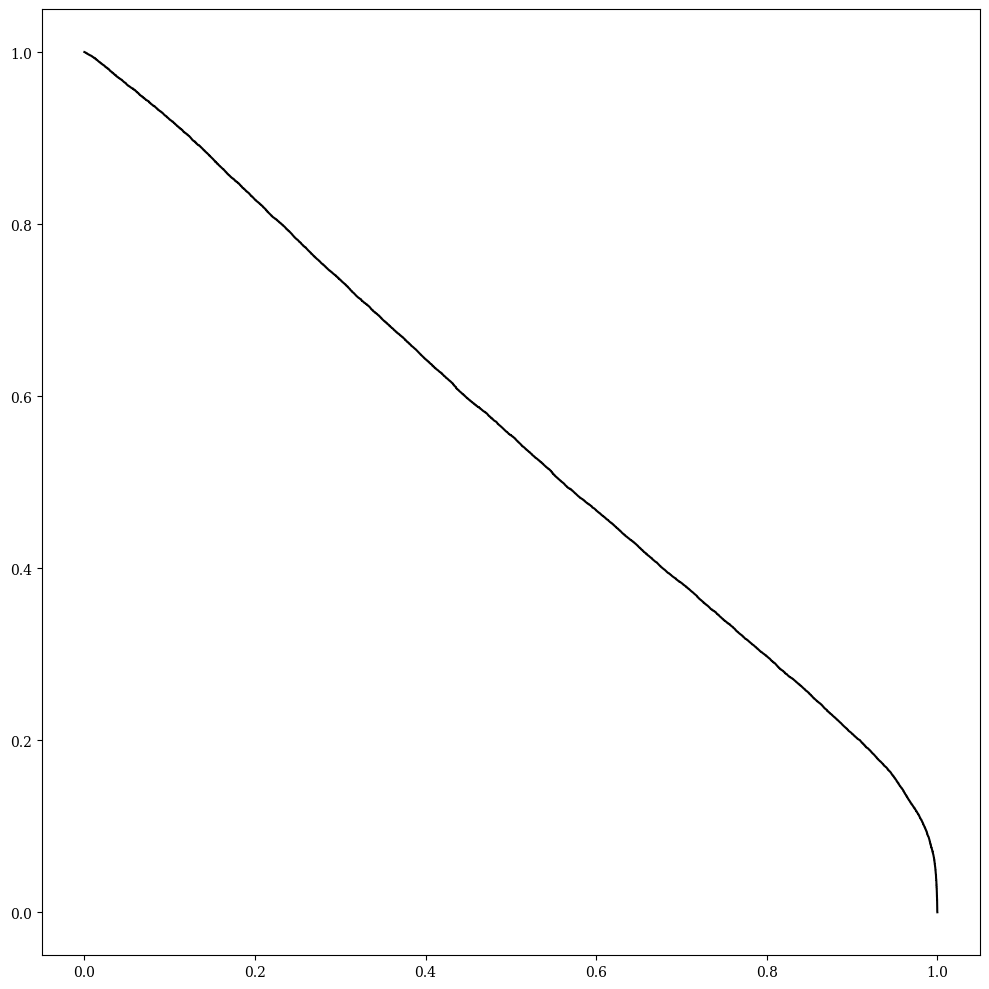

In [3]:
# Regular EFN, no spectral normalization, no bjorck, bound only
loss = BinaryCrossentropy(from_logits=False)
L = 2
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
model_kwargs['eps_bjorck'] = None
model_kwargs['bound_only'] = True
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models_wta_Lsmall/qjet_spectralEFN_noBjorck_boundOnly_zpT_L2.keras")
#del efn
gc.collect()

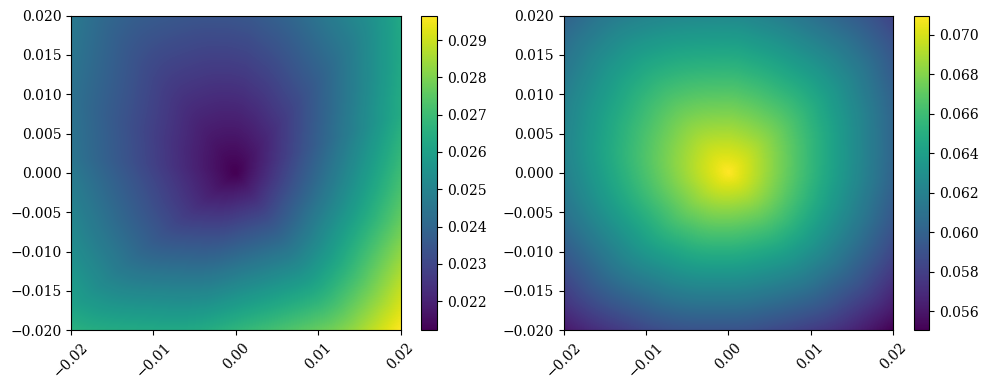

In [6]:
from matplotlib.colors import LogNorm, Normalize
R = 0.02
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

## L = 1 Spectral

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation_7 (Activation)      (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation_7[0][0]']           
                                                                                            

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 164ms/step - loss: 0.6931 - acc: 0.5193 - val_loss: 0.6931 - val_acc: 0.5148
Epoch 2/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6931 - acc: 0.5215 - val_loss: 0.6931 - val_acc: 0.5133
Epoch 3/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6931 - acc: 0.5173 - val_loss: 0.6931 - val_acc: 0.5131
Epoch 4/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6931 - acc: 0.5155 - val_loss: 0.6931 - val_acc: 0.5209
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6931 - acc: 0.5131 - val_loss: 0.6930 - val_acc: 0.5136
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5185 - val_loss: 0.6930 - val_acc: 0.5204
Epoch 7/150
20/20 [==============================] - 3s 148ms/step - loss: 0.6930 - acc: 0.5205 - val_loss: 0.6930 - val_acc: 0.5170
Epoch 8/150
20/20 [==============================] - 3s 140ms/step - 

3594

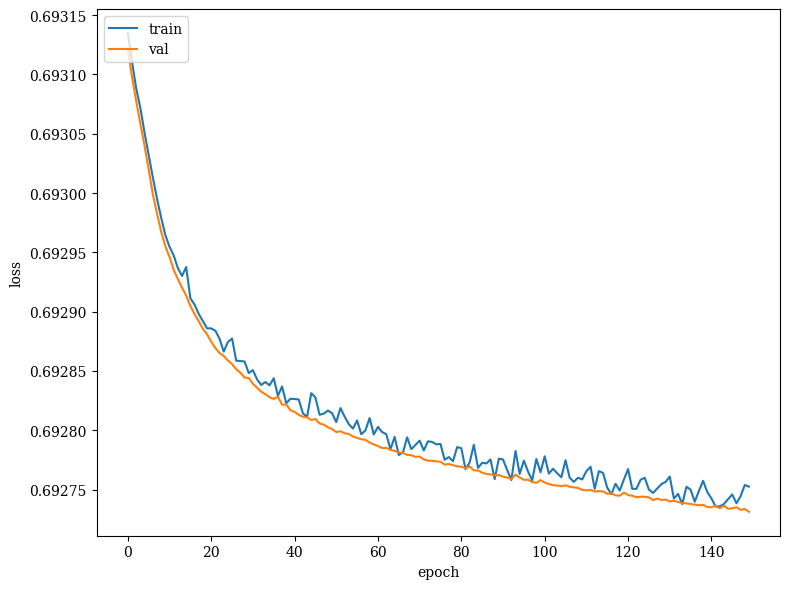

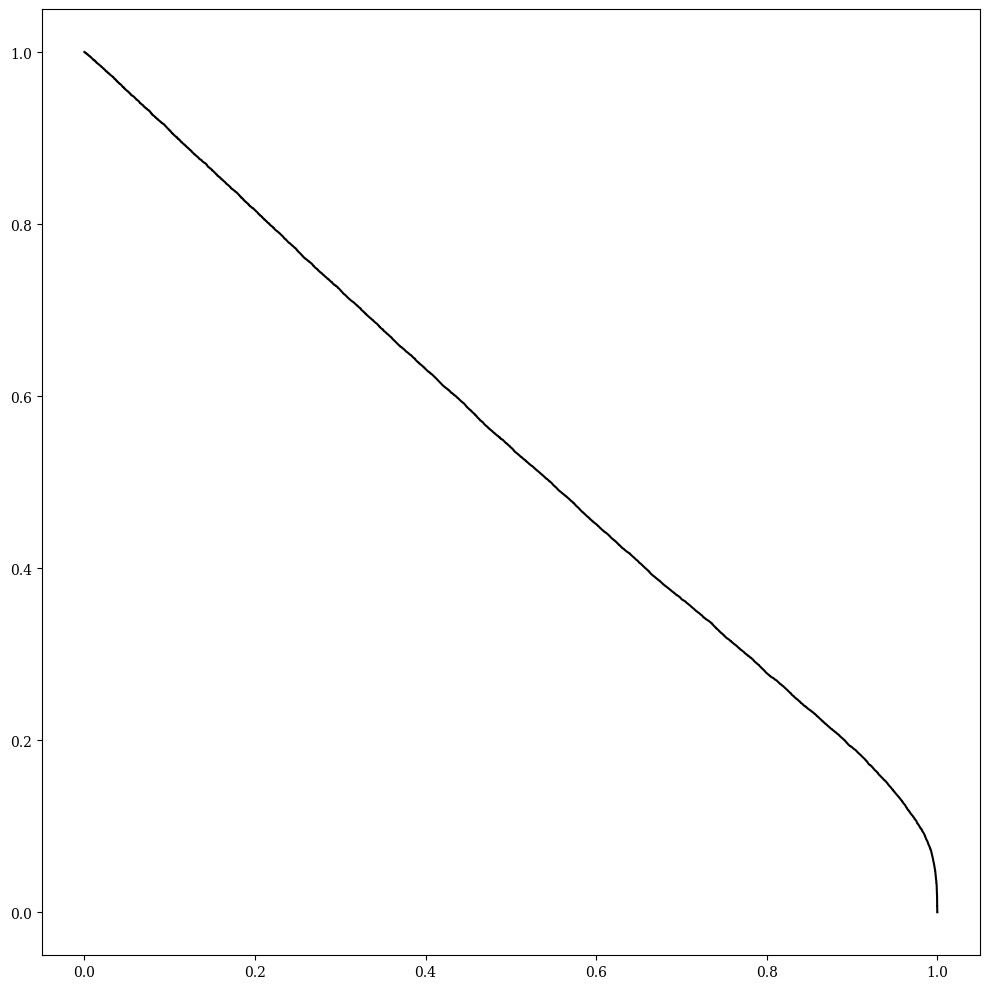

In [7]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 1
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
#del efn
gc.collect()

In [10]:
efn.save(f"keras_models_wta_Lsmall/qjet_spectralEFN_zpT_L1.keras")

In [4]:
import tensorflow.keras.backend as K
model = keras.models.load_model("keras_models_wta_Lsmall/qjet_EFN_zpT_L1_iter1.keras")

OSError: No file or directory found at keras_models_wta_Lsmall/qjet_EFN_zpT_L1_iter1.keras

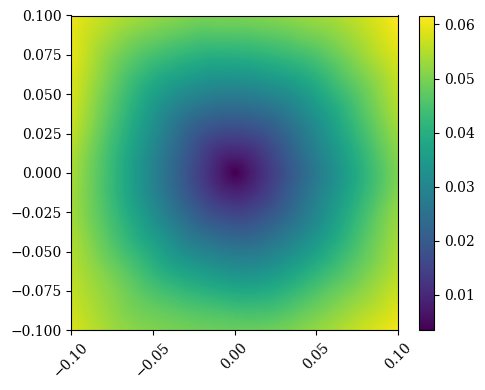

In [8]:
from matplotlib.colors import LogNorm, Normalize
R = 0.1
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
#fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
plt.figure(figsize=(5,4))
for i in range(len(Z)):
    #plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$\\langle \\Phi(R) \\rangle$')

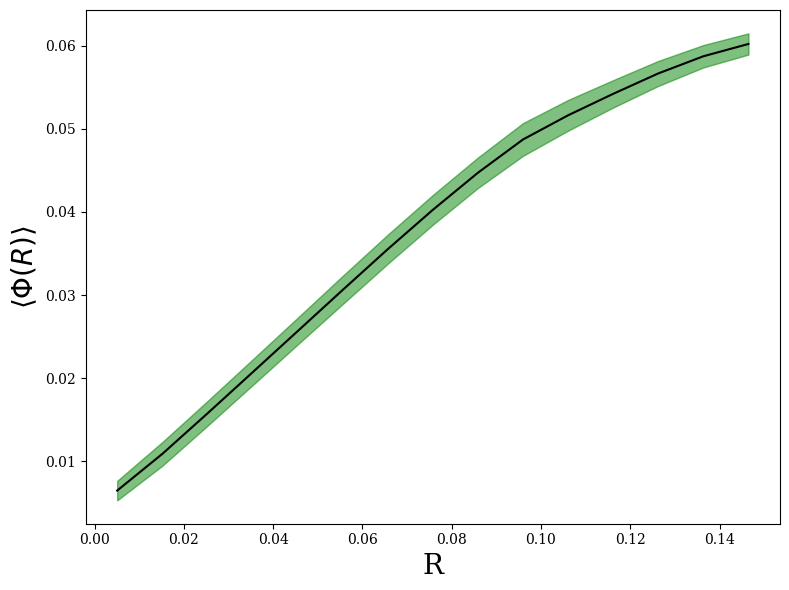

In [9]:
def log_func(x,a,b,c):
    return a - b*np.log(x+c)
R = np.sqrt(X**2 + Y**2)
rbins = np.linspace(0.0,1,100)
bin_centers = (rbins[:-1]+rbins[1:])/2
r_inds = np.digitize(R.flatten(),rbins)-1
z_means = np.array([np.mean(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])
z_stds = np.array([np.std(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])

remove = np.isnan(z_means) | np.isnan(z_stds)

#popt, pcov = curve_fit(log_func, bin_centers[~remove], z_means[~remove], sigma=z_stds[~remove])
#popt, pcov = curve_fit(log_func, R.flatten(),Z.flatten())
plt.figure(figsize=(8,6))
plt.plot(bin_centers,z_means,zorder=2,color='black')
plt.fill_between(bin_centers,z_means+z_stds,z_means-z_stds,color='green',alpha=0.5,zorder=1)
plt.xlabel("R",fontsize=20)
plt.ylabel(r"$\langle \Phi(R) \rangle$",fontsize=20)
#plt.plot(bin_centers,log_func(bin_centers,*popt),color='blue',linestyle='--',
#         label=r"${0:.4f} - {1:.4f}\log(x+{2:.4f})$".format(popt[0],popt[1],popt[2]))
#plt.legend()
#plt.plot(bin_centers,popt[0]*np.log(1/(0.01*bin_centers)))

# Gluon jets, R = 0.8

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('g',hlevel=True,efrac=False,base=base,nmax=nmax,wta=True)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=False,base=base,nmax=nmax,wta=True)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall_WTA.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall_WTA.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_

In [7]:
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2gg_WTA_testSet_inputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("test",data=test)
    f.create_dataset("labels",data=test_labels)

## Make non-WTA input files

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('g',hlevel=True,efrac=False,base=base,nmax=nmax,wta=False)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=False,base=base,nmax=nmax,wta=False)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall.h5


In [3]:
import h5py
with h5py.File("/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable/h2gg_testSet_inputs_v2_pTinclusive_R1.0.h5","w") as f:
    f.create_dataset("test",data=test)
    f.create_dataset("labels",data=test_labels)

## EFNs

2023-09-19 17:39:18.637345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:39:19.726030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:39:19.726512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-19 17:39:19.728080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     180         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2023-09-19 17:39:25.579535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 7s 12ms/step - loss: 0.5325 - acc: 0.7192 - val_loss: 0.4587 - val_acc: 0.7807
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 0.4127 - acc: 0.8143 - val_loss: 0.4048 - val_acc: 0.8189
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3912 - acc: 0.8262 - val_loss: 0.3836 - val_acc: 0.8275
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3824 - acc: 0.8311 - val_loss: 0.3699 - val_acc: 0.8360
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3790 - acc: 0.8331 - val_loss: 0.3687 - val_acc: 0.8371
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3739 - acc: 0.8369 - val_loss: 0.3757 - val_acc: 0.8345
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 0.3668 - acc: 0.8404 - val_loss: 0.3605 - val_acc: 0.8409
Epoch 8/100
391/391 [==============================] - 4s 10ms/step - loss

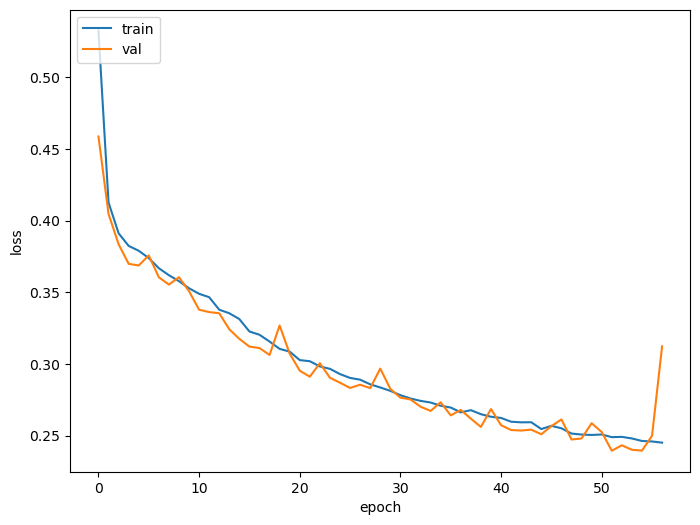

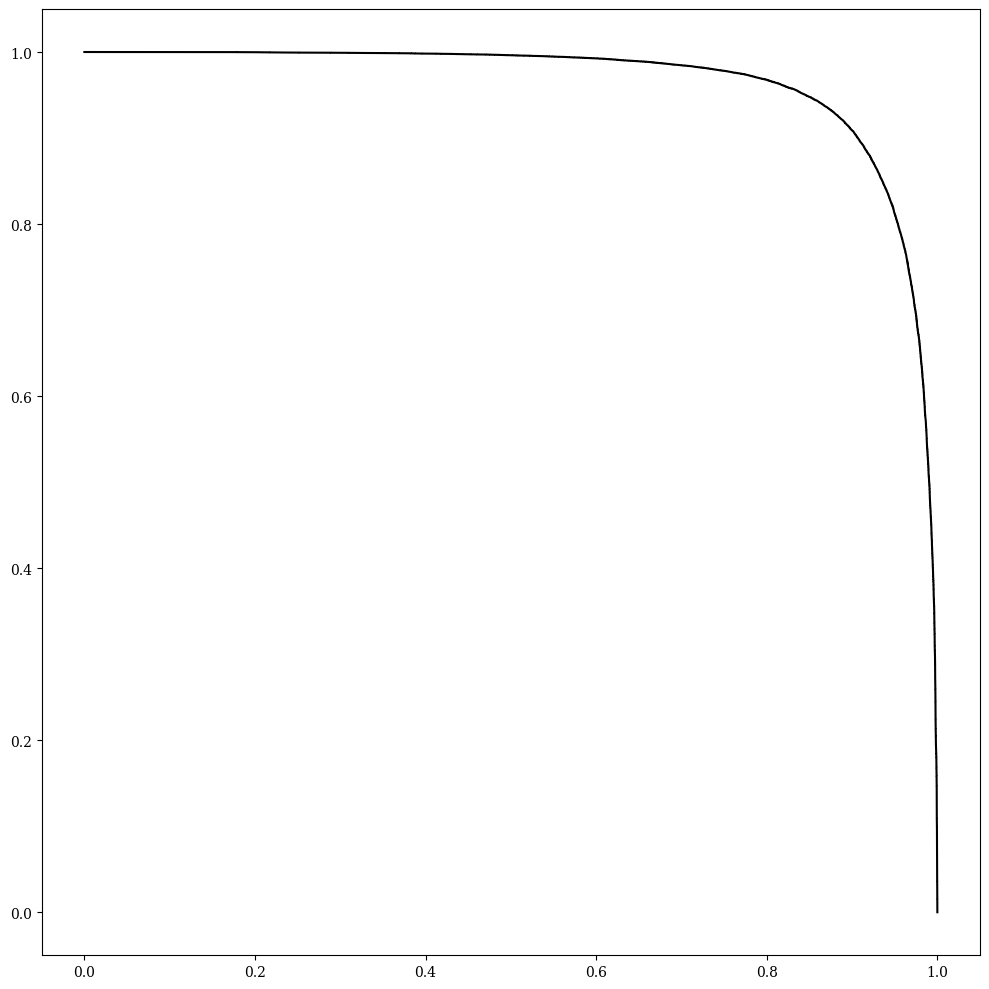

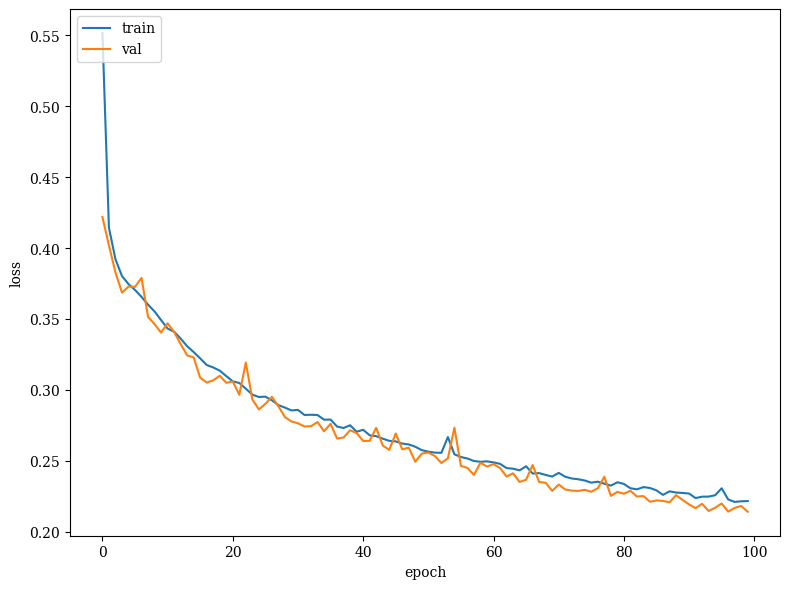

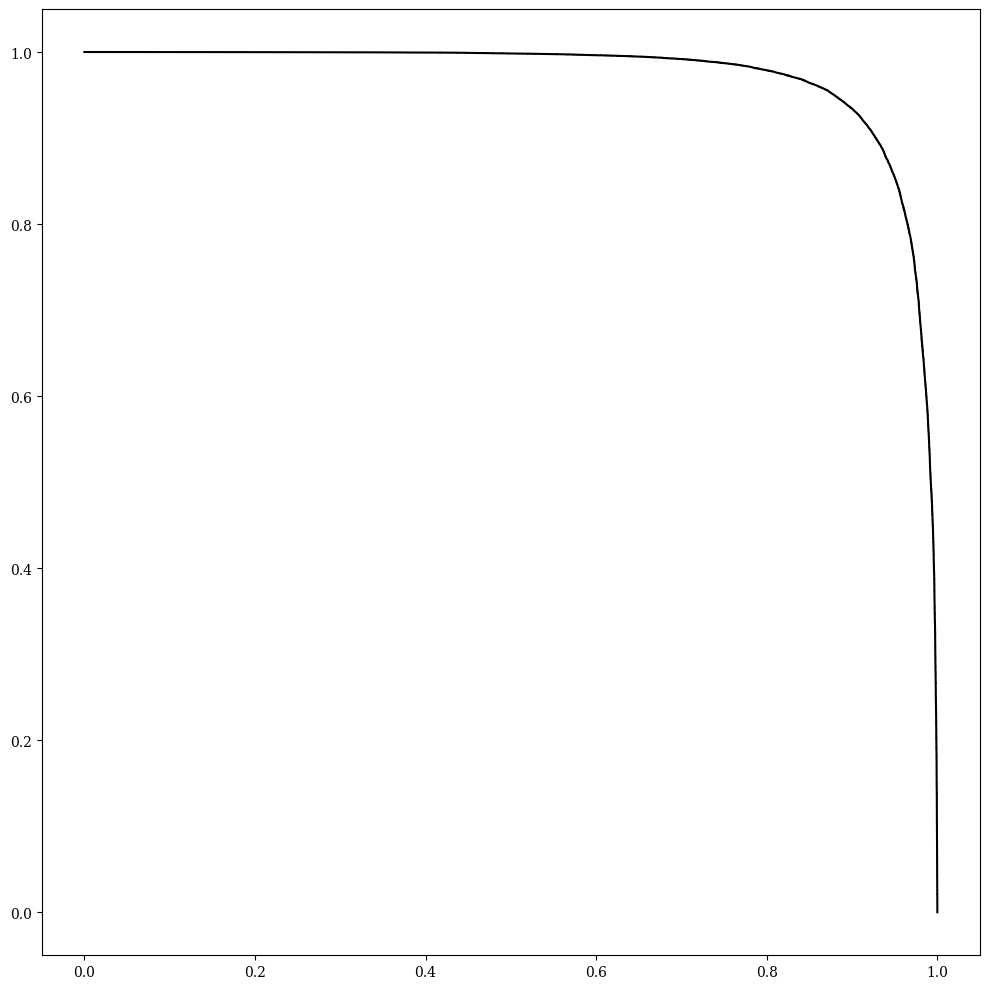

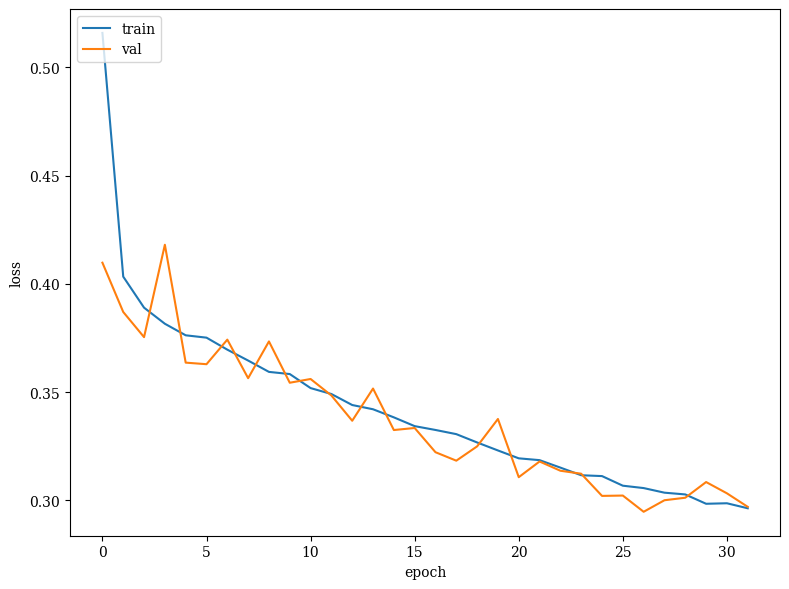

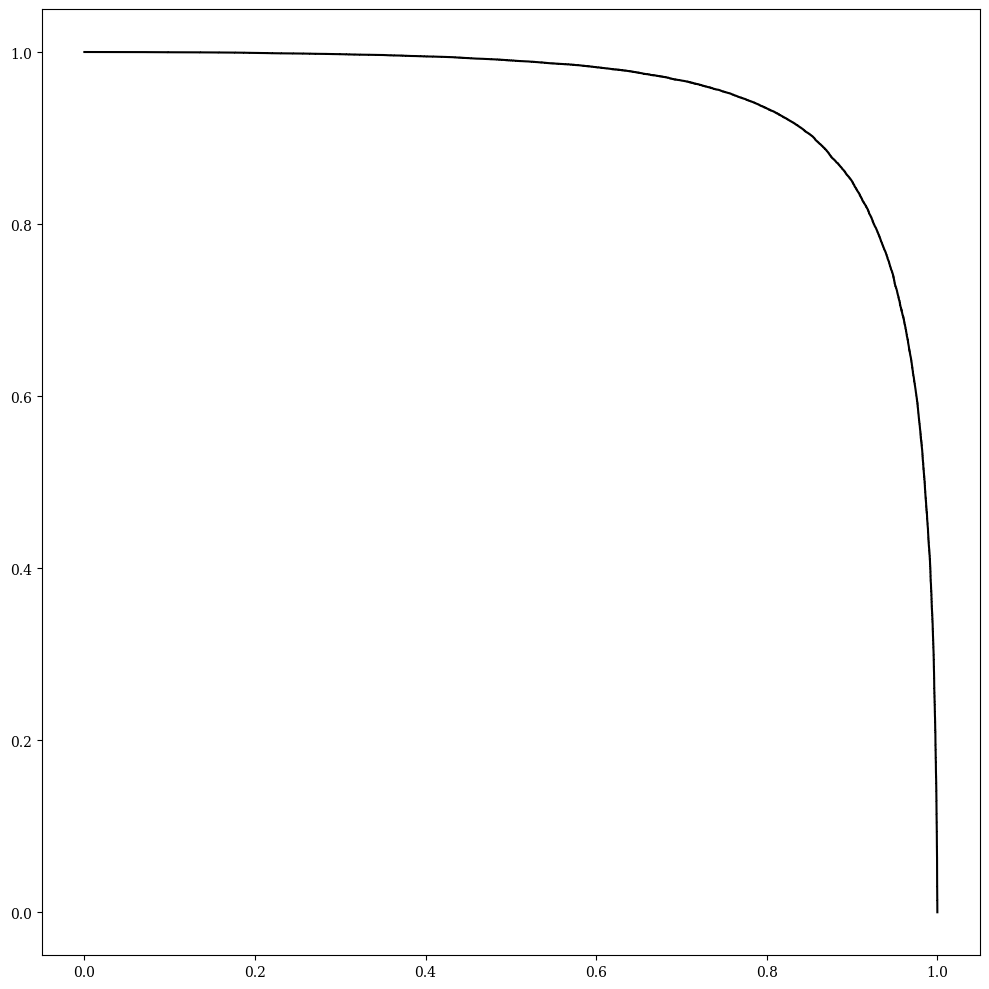

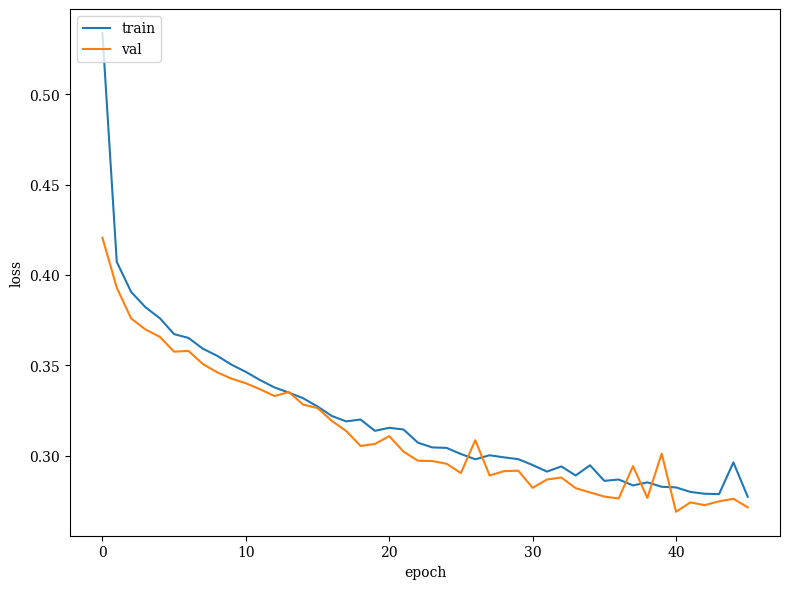

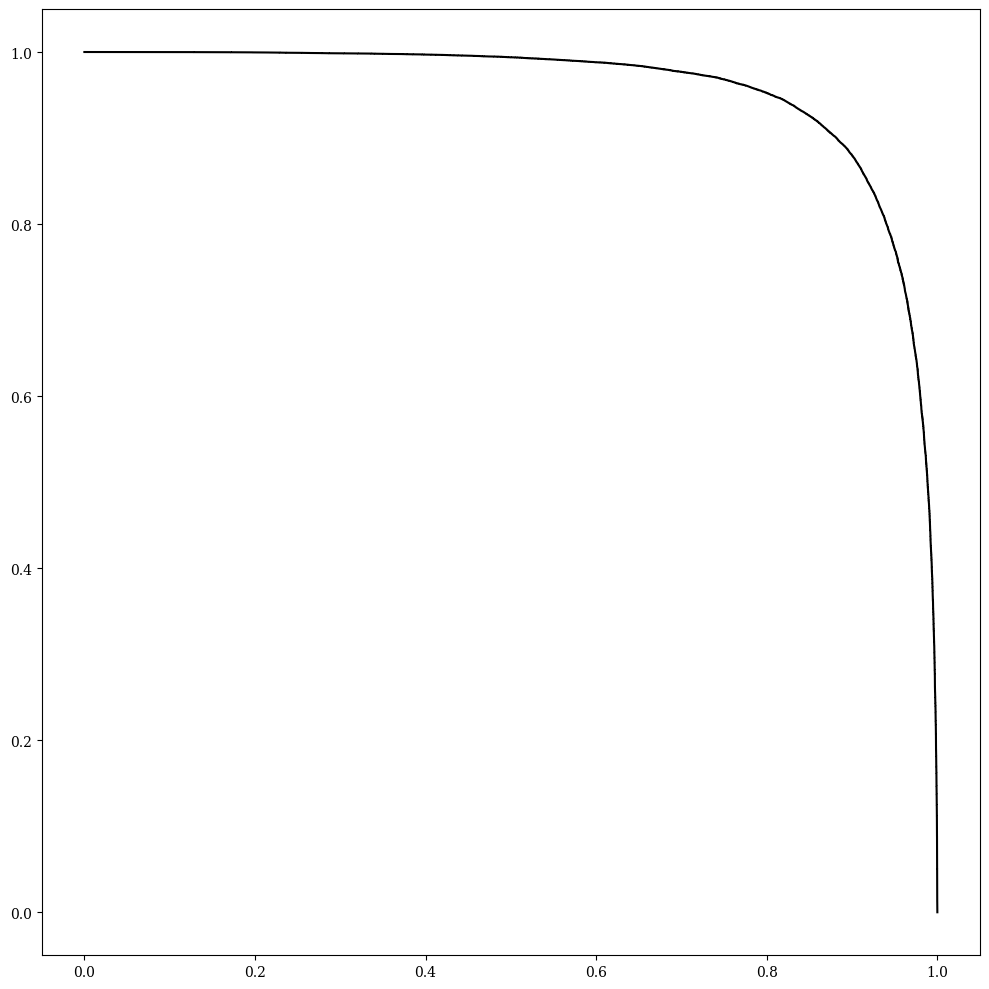

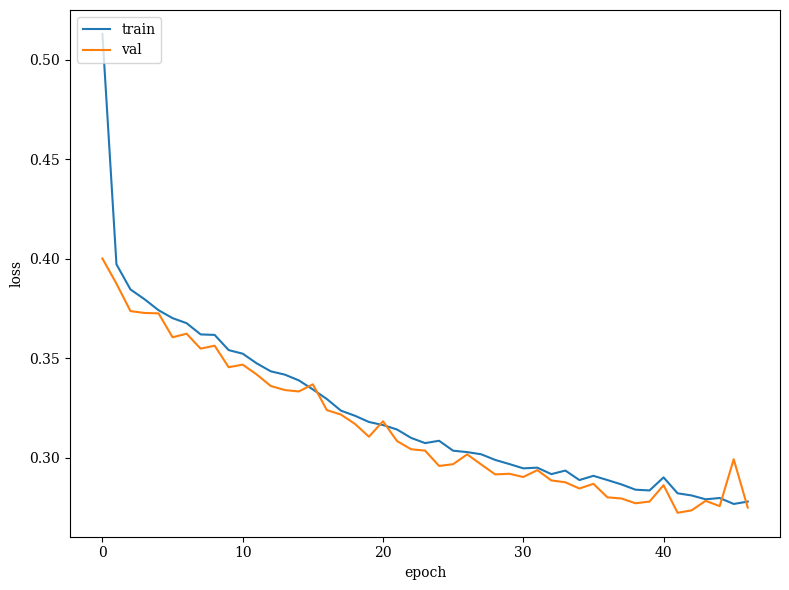

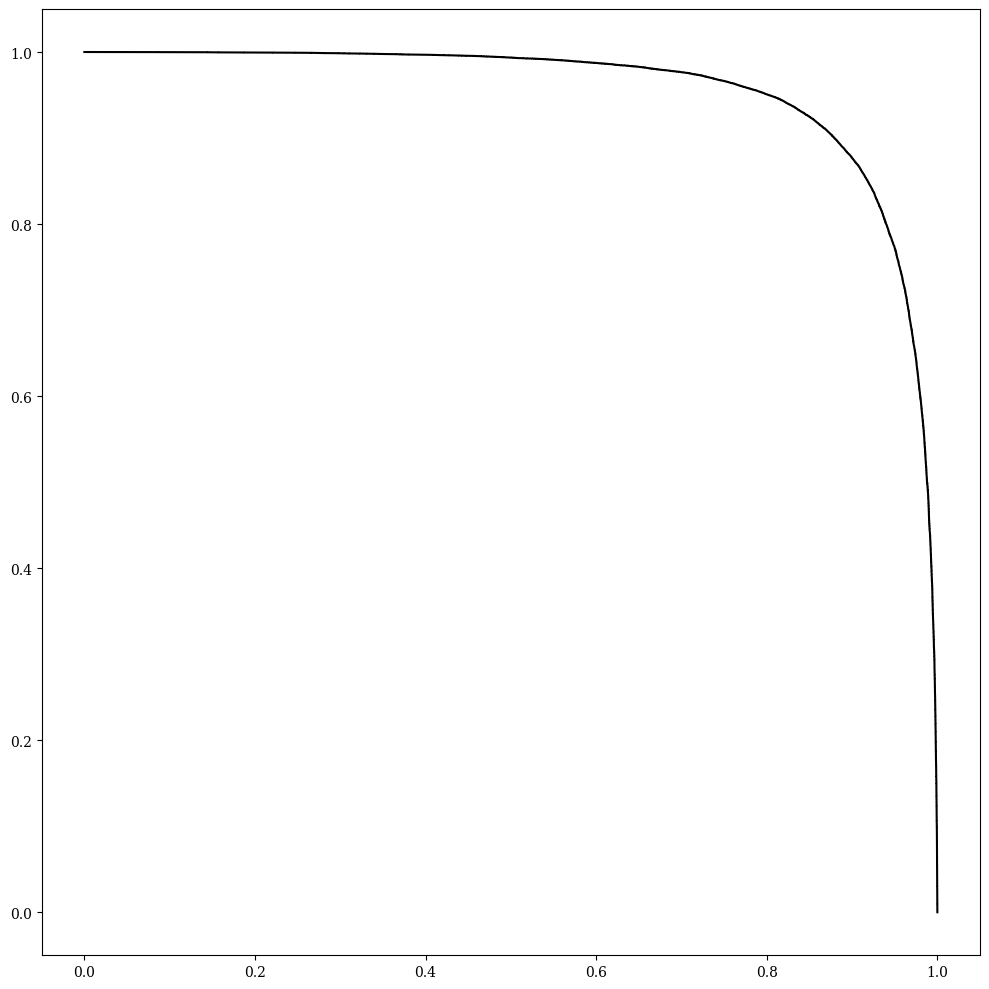

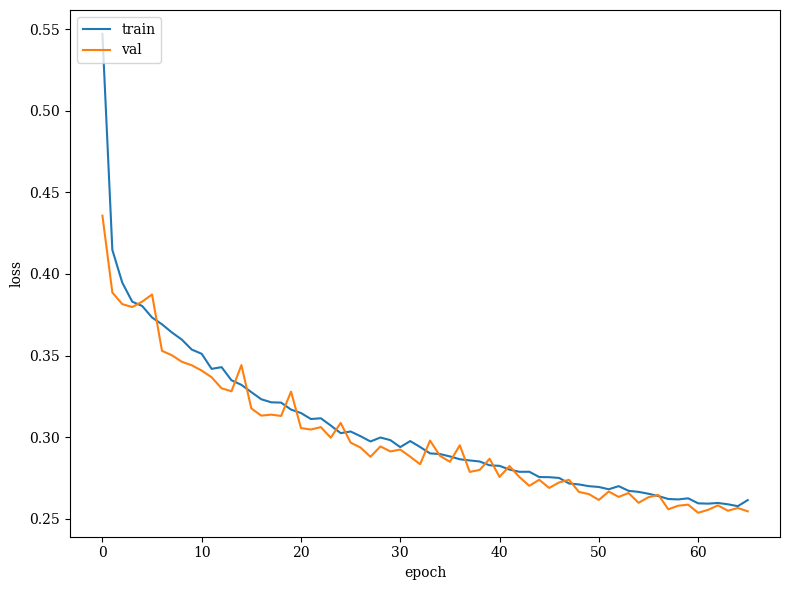

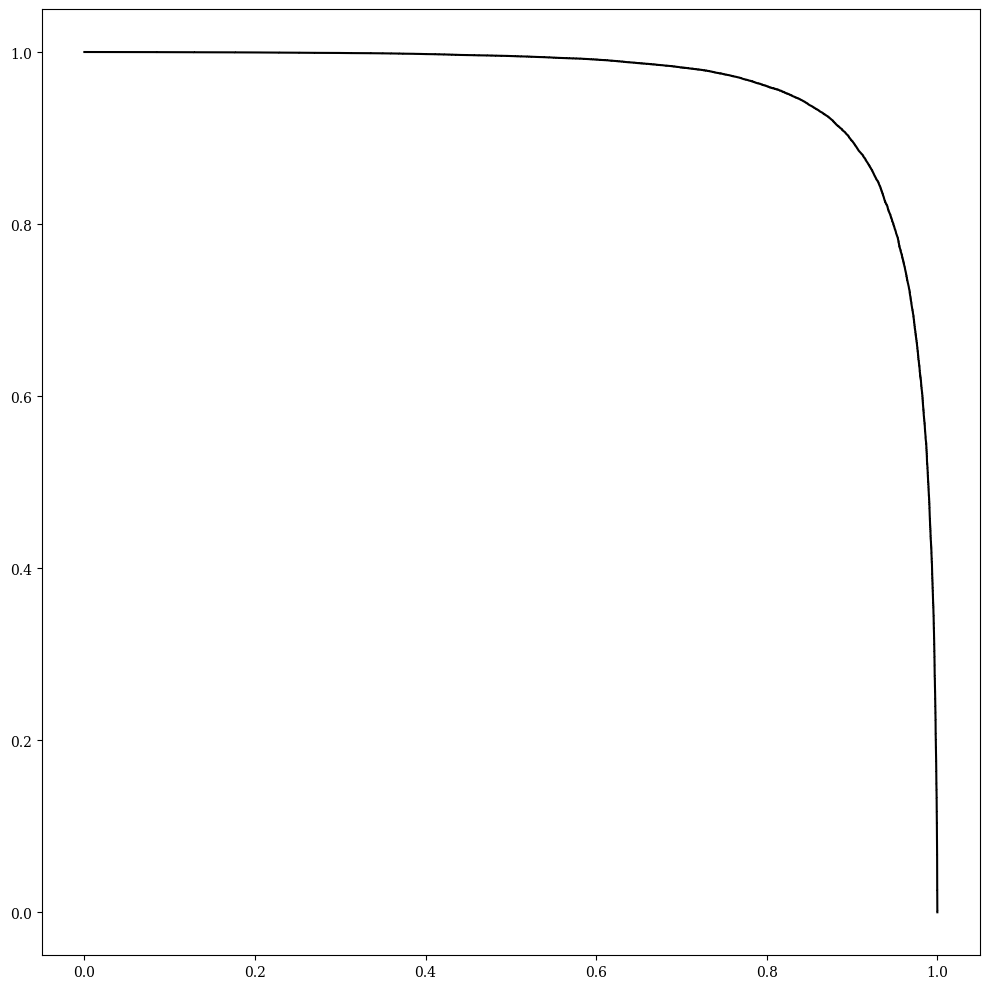

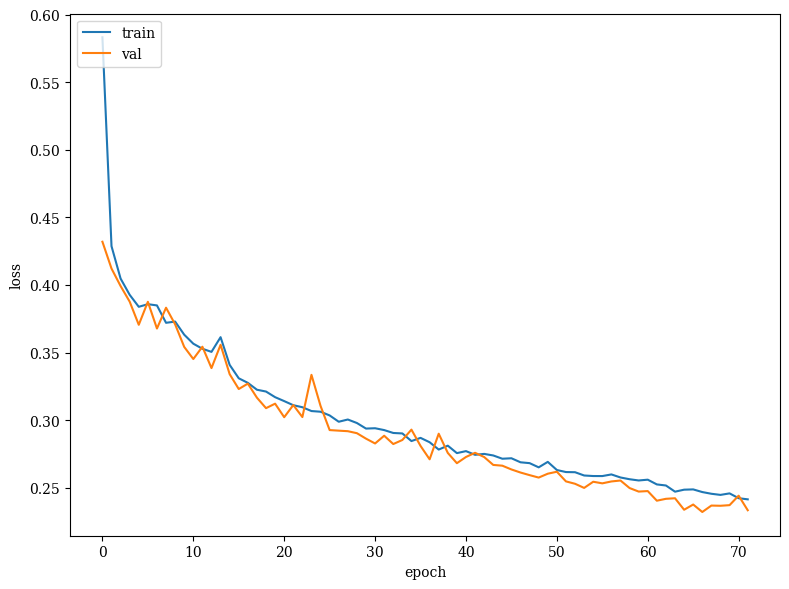

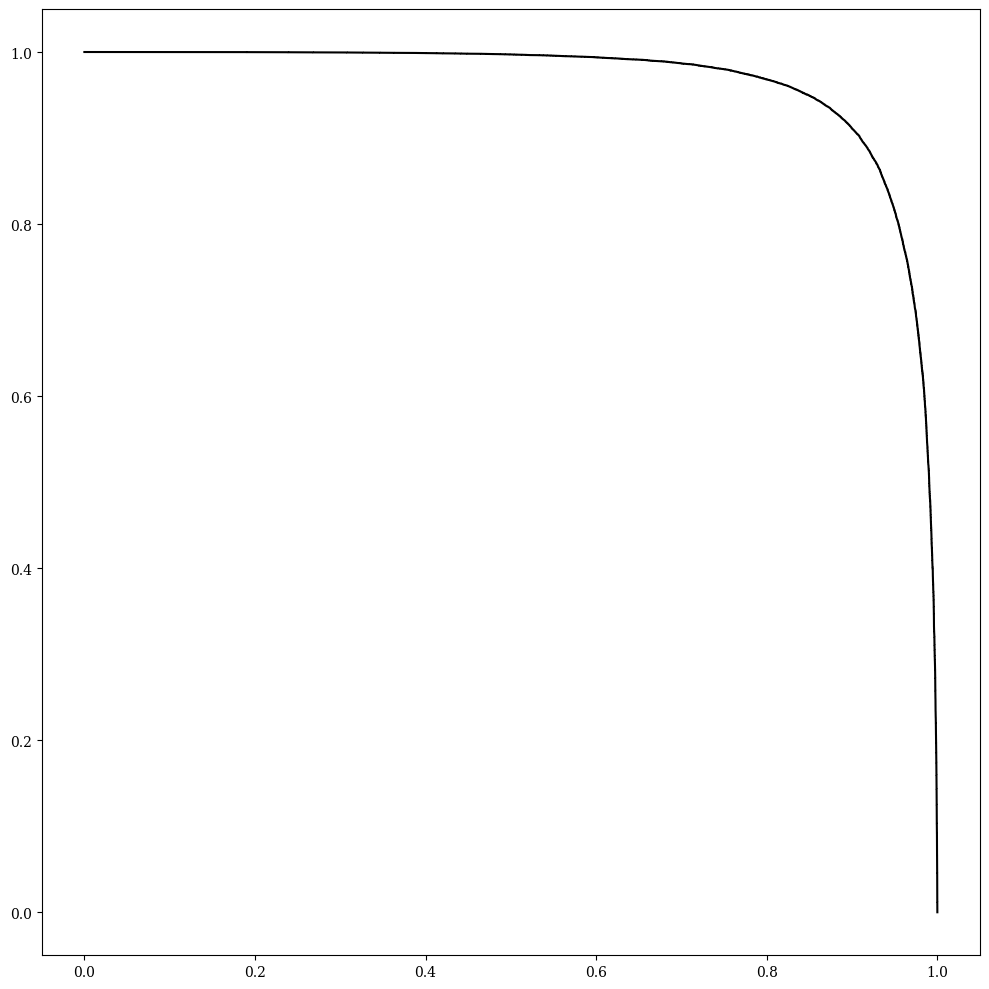

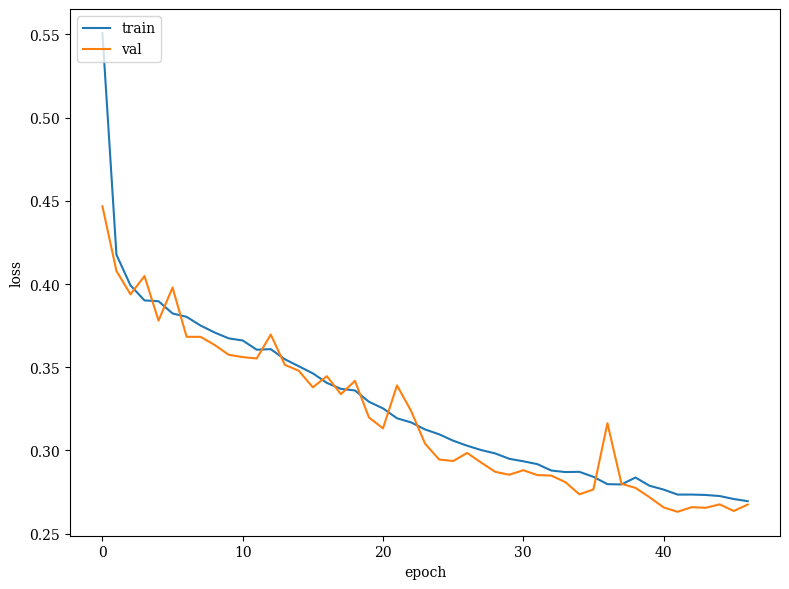

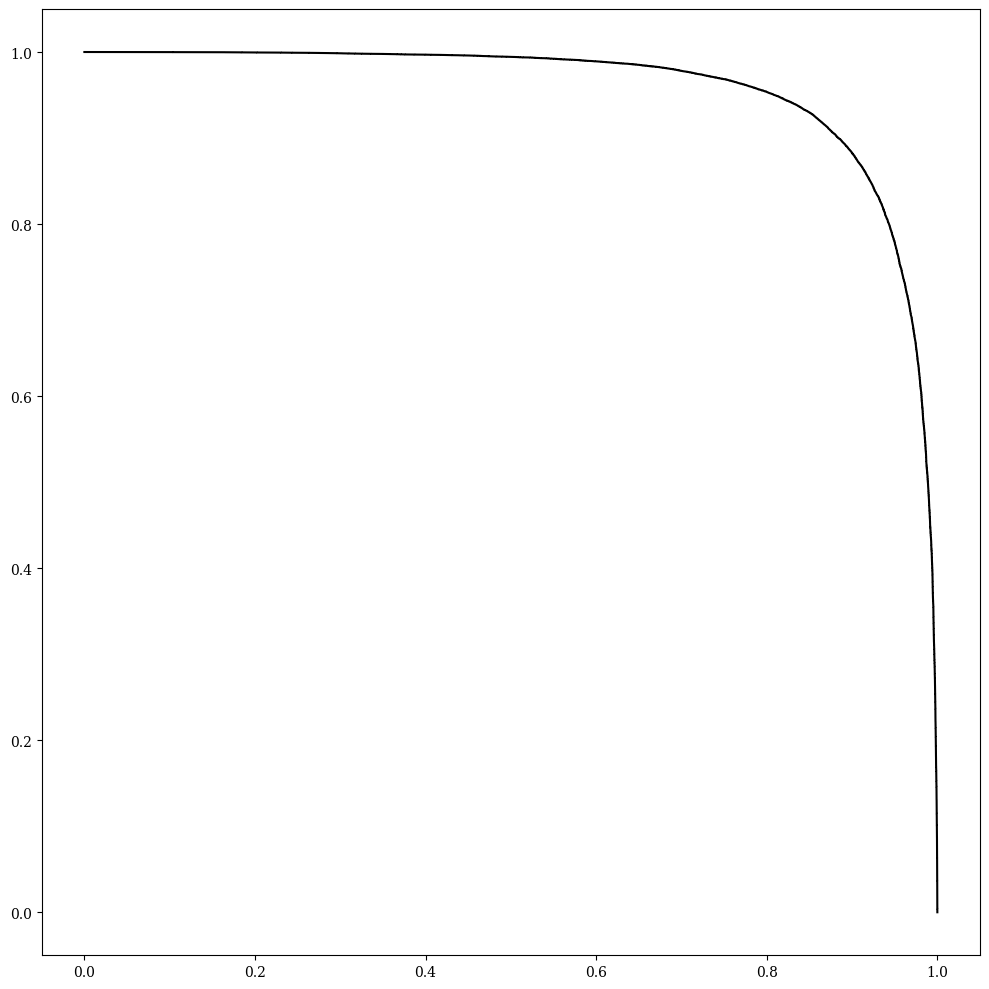

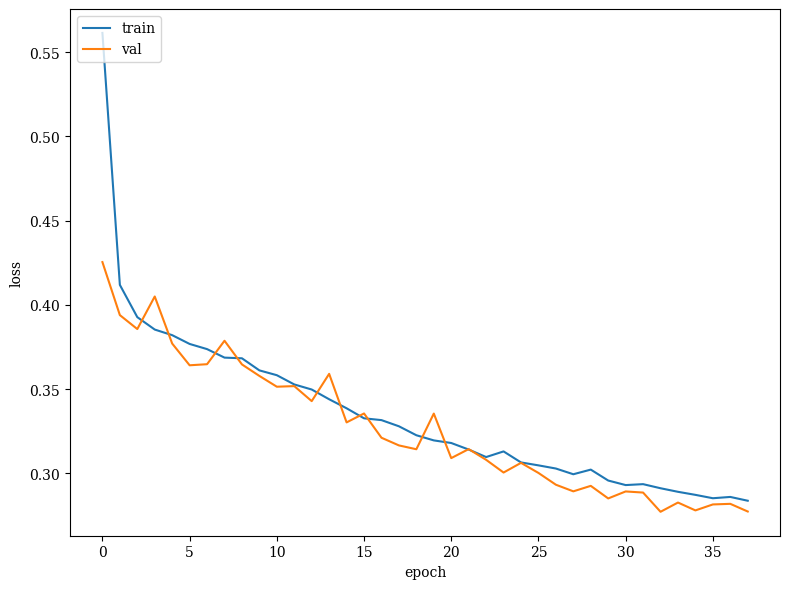

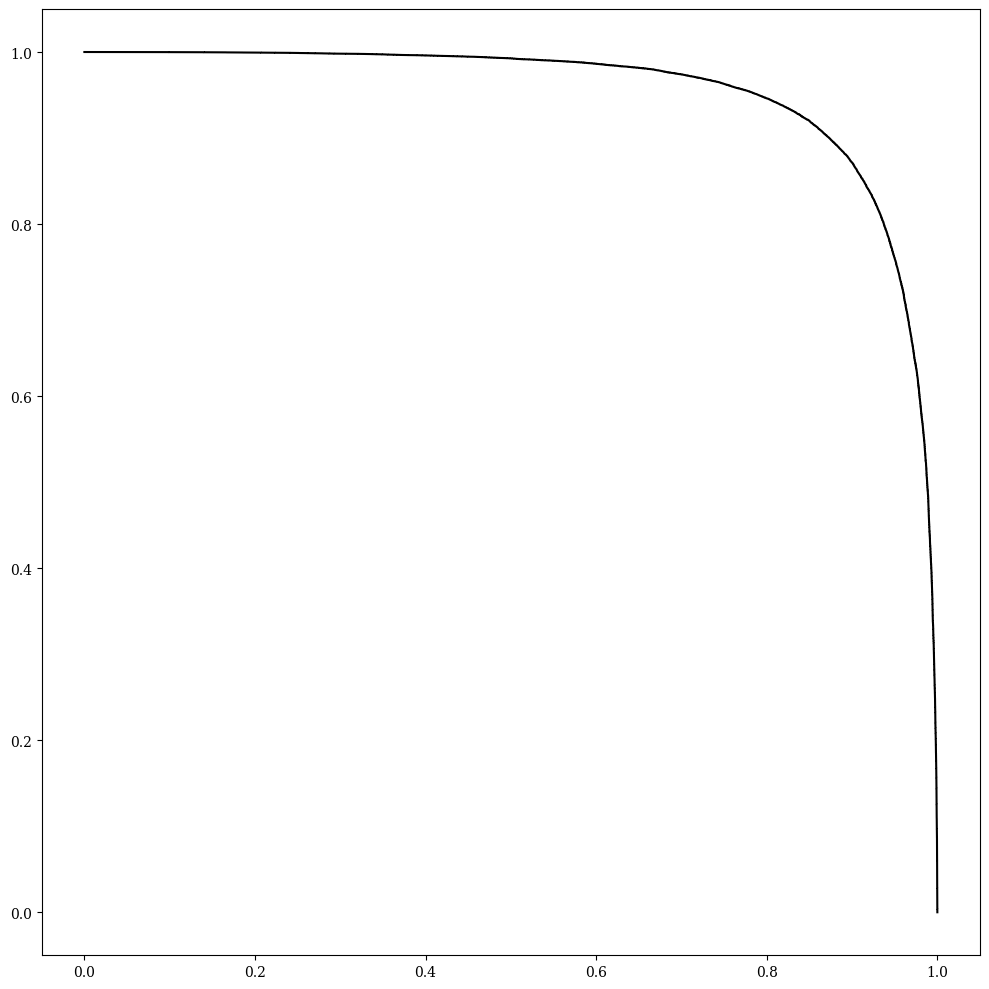

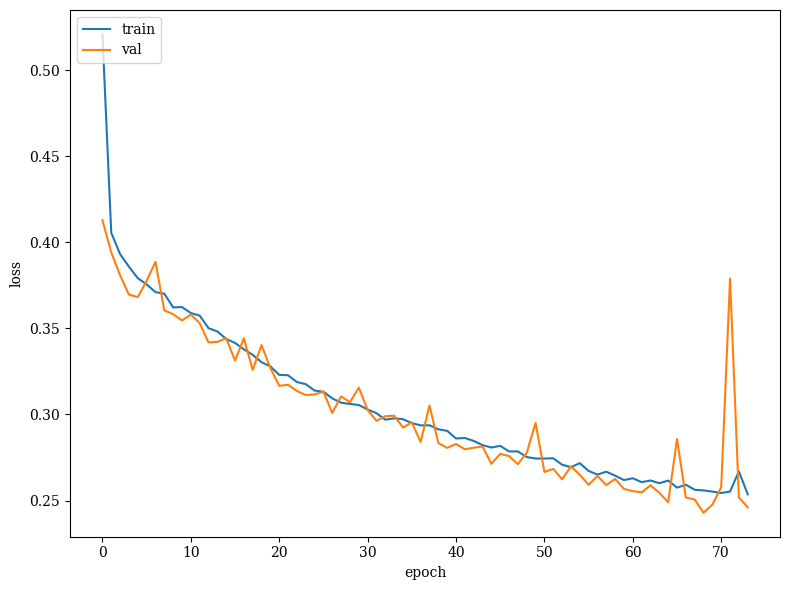

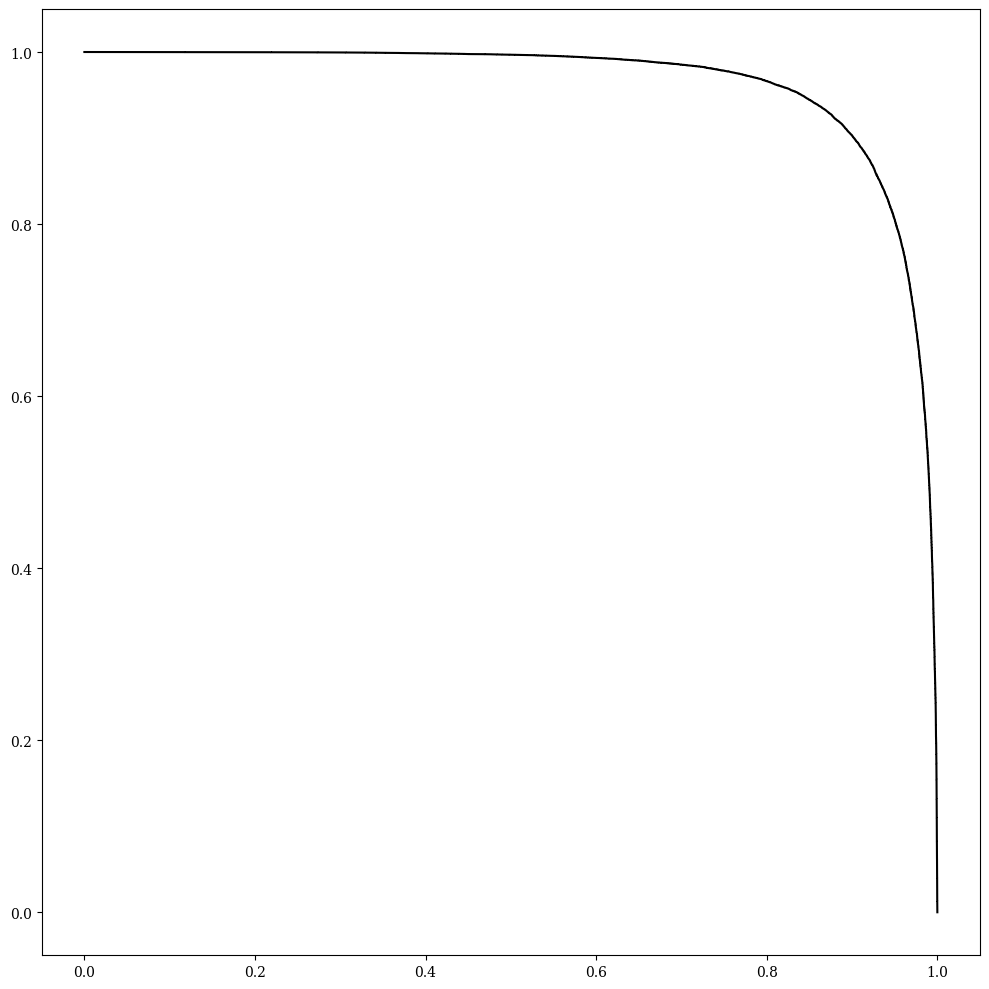

In [4]:
# Regular EFN, no spectral normalization
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":100,"verbose":1,"batch_size":512}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta/gjet_EFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     361         ['phats_input[0][0]']            
                                                                                                  
 activation_70 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_70[0][0]']          
                                                                                           

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 183ms/step - loss: 0.6931 - acc: 0.5244 - val_loss: 0.6930 - val_acc: 0.5284
Epoch 2/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6930 - acc: 0.5268 - val_loss: 0.6930 - val_acc: 0.5259
Epoch 3/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5228 - val_loss: 0.6929 - val_acc: 0.5252
Epoch 4/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5222 - val_loss: 0.6928 - val_acc: 0.5202
Epoch 5/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6928 - acc: 0.5215 - val_loss: 0.6928 - val_acc: 0.5191
Epoch 6/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6928 - acc: 0.5188 - val_loss: 0.6927 - val_acc: 0.5175
Epoch 7/150
20/20 [==============================] - 3s 148ms/step - loss: 0.6927 - acc: 0.5185 - val_loss: 0.6927 - val_acc: 0.5187
Epoch 8/150
20/20 [==============================] - 3s 138ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 165ms/step - loss: 0.6931 - acc: 0.5132 - val_loss: 0.6930 - val_acc: 0.5278
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6930 - acc: 0.5261 - val_loss: 0.6929 - val_acc: 0.5263
Epoch 3/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6929 - acc: 0.5260 - val_loss: 0.6929 - val_acc: 0.5250
Epoch 4/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5232 - val_loss: 0.6928 - val_acc: 0.5222
Epoch 5/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6928 - acc: 0.5184 - val_loss: 0.6928 - val_acc: 0.5210
Epoch 6/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6928 - acc: 0.5212 - val_loss: 0.6927 - val_acc: 0.5171
Epoch 7/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6927 - acc: 0.5167 - val_loss: 0.6927 - val_acc: 0.5181
Epoch 8/150
20/20 [==============================] - 3s 141ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 173ms/step - loss: 0.6930 - acc: 0.5109 - val_loss: 0.6930 - val_acc: 0.5255
Epoch 2/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5266 - val_loss: 0.6929 - val_acc: 0.5273
Epoch 3/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6929 - acc: 0.5259 - val_loss: 0.6928 - val_acc: 0.5255
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6928 - acc: 0.5253 - val_loss: 0.6928 - val_acc: 0.5246
Epoch 5/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6928 - acc: 0.5218 - val_loss: 0.6927 - val_acc: 0.5225
Epoch 6/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6927 - acc: 0.5227 - val_loss: 0.6927 - val_acc: 0.5232
Epoch 7/150
20/20 [==============================] - 3s 145ms/step - loss: 0.6927 - acc: 0.5190 - val_loss: 0.6927 - val_acc: 0.5218
Epoch 8/150
20/20 [==============================] - 3s 135ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 163ms/step - loss: 0.6931 - acc: 0.5201 - val_loss: 0.6930 - val_acc: 0.5299
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6930 - acc: 0.5276 - val_loss: 0.6929 - val_acc: 0.5292
Epoch 3/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5269 - val_loss: 0.6929 - val_acc: 0.5267
Epoch 4/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6928 - acc: 0.5258 - val_loss: 0.6928 - val_acc: 0.5258
Epoch 5/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6928 - acc: 0.5218 - val_loss: 0.6927 - val_acc: 0.5258
Epoch 6/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6927 - acc: 0.5236 - val_loss: 0.6927 - val_acc: 0.5217
Epoch 7/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6927 - acc: 0.5200 - val_loss: 0.6927 - val_acc: 0.5213
Epoch 8/150
20/20 [==============================] - 3s 134ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 166ms/step - loss: 0.6931 - acc: 0.5017 - val_loss: 0.6930 - val_acc: 0.5134
Epoch 2/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6930 - acc: 0.5237 - val_loss: 0.6929 - val_acc: 0.5282
Epoch 3/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6929 - acc: 0.5268 - val_loss: 0.6928 - val_acc: 0.5272
Epoch 4/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6928 - acc: 0.5250 - val_loss: 0.6928 - val_acc: 0.5257
Epoch 5/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6928 - acc: 0.5239 - val_loss: 0.6927 - val_acc: 0.5222
Epoch 6/150
20/20 [==============================] - 3s 142ms/step - loss: 0.6927 - acc: 0.5240 - val_loss: 0.6927 - val_acc: 0.5204
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6927 - acc: 0.5210 - val_loss: 0.6927 - val_acc: 0.5209
Epoch 8/150
20/20 [==============================] - 3s 139ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 175ms/step - loss: 0.6931 - acc: 0.5130 - val_loss: 0.6930 - val_acc: 0.5236
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.6930 - acc: 0.5256 - val_loss: 0.6929 - val_acc: 0.5268
Epoch 3/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5252 - val_loss: 0.6928 - val_acc: 0.5261
Epoch 4/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6928 - acc: 0.5232 - val_loss: 0.6928 - val_acc: 0.5238
Epoch 5/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6928 - acc: 0.5216 - val_loss: 0.6927 - val_acc: 0.5211
Epoch 6/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6927 - acc: 0.5200 - val_loss: 0.6927 - val_acc: 0.5216
Epoch 7/150
20/20 [==============================] - 3s 140ms/step - loss: 0.6927 - acc: 0.5203 - val_loss: 0.6927 - val_acc: 0.5193
Epoch 8/150
20/20 [==============================] - 3s 135ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 167ms/step - loss: 0.6931 - acc: 0.5153 - val_loss: 0.6930 - val_acc: 0.5271
Epoch 2/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6930 - acc: 0.5260 - val_loss: 0.6929 - val_acc: 0.5255
Epoch 3/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6929 - acc: 0.5242 - val_loss: 0.6928 - val_acc: 0.5239
Epoch 4/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6928 - acc: 0.5223 - val_loss: 0.6928 - val_acc: 0.5226
Epoch 5/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6928 - acc: 0.5220 - val_loss: 0.6927 - val_acc: 0.5212
Epoch 6/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6927 - acc: 0.5212 - val_loss: 0.6927 - val_acc: 0.5177
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6927 - acc: 0.5187 - val_loss: 0.6927 - val_acc: 0.5174
Epoch 8/150
20/20 [==============================] - 3s 143ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 165ms/step - loss: 0.6931 - acc: 0.5148 - val_loss: 0.6930 - val_acc: 0.5271
Epoch 2/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6930 - acc: 0.5271 - val_loss: 0.6929 - val_acc: 0.5266
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.6929 - acc: 0.5274 - val_loss: 0.6929 - val_acc: 0.5259
Epoch 4/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6929 - acc: 0.5239 - val_loss: 0.6928 - val_acc: 0.5236
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6928 - acc: 0.5243 - val_loss: 0.6928 - val_acc: 0.5240
Epoch 6/150
20/20 [==============================] - 3s 143ms/step - loss: 0.6928 - acc: 0.5238 - val_loss: 0.6927 - val_acc: 0.5231
Epoch 7/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6927 - acc: 0.5229 - val_loss: 0.6927 - val_acc: 0.5215
Epoch 8/150
20/20 [==============================] - 3s 142ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 166ms/step - loss: 0.6931 - acc: 0.5117 - val_loss: 0.6930 - val_acc: 0.5259
Epoch 2/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6930 - acc: 0.5263 - val_loss: 0.6929 - val_acc: 0.5278
Epoch 3/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6929 - acc: 0.5266 - val_loss: 0.6928 - val_acc: 0.5270
Epoch 4/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6928 - acc: 0.5257 - val_loss: 0.6928 - val_acc: 0.5246
Epoch 5/150
20/20 [==============================] - 3s 138ms/step - loss: 0.6928 - acc: 0.5238 - val_loss: 0.6927 - val_acc: 0.5232
Epoch 6/150
20/20 [==============================] - 3s 135ms/step - loss: 0.6927 - acc: 0.5210 - val_loss: 0.6927 - val_acc: 0.5242
Epoch 7/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6927 - acc: 0.5226 - val_loss: 0.6927 - val_acc: 0.5217
Epoch 8/150
20/20 [==============================] - 3s 138ms/step - 

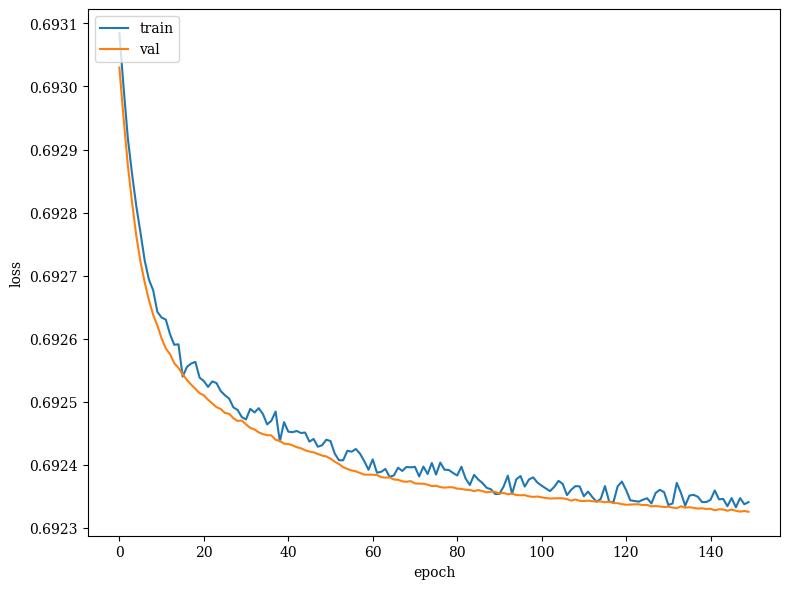

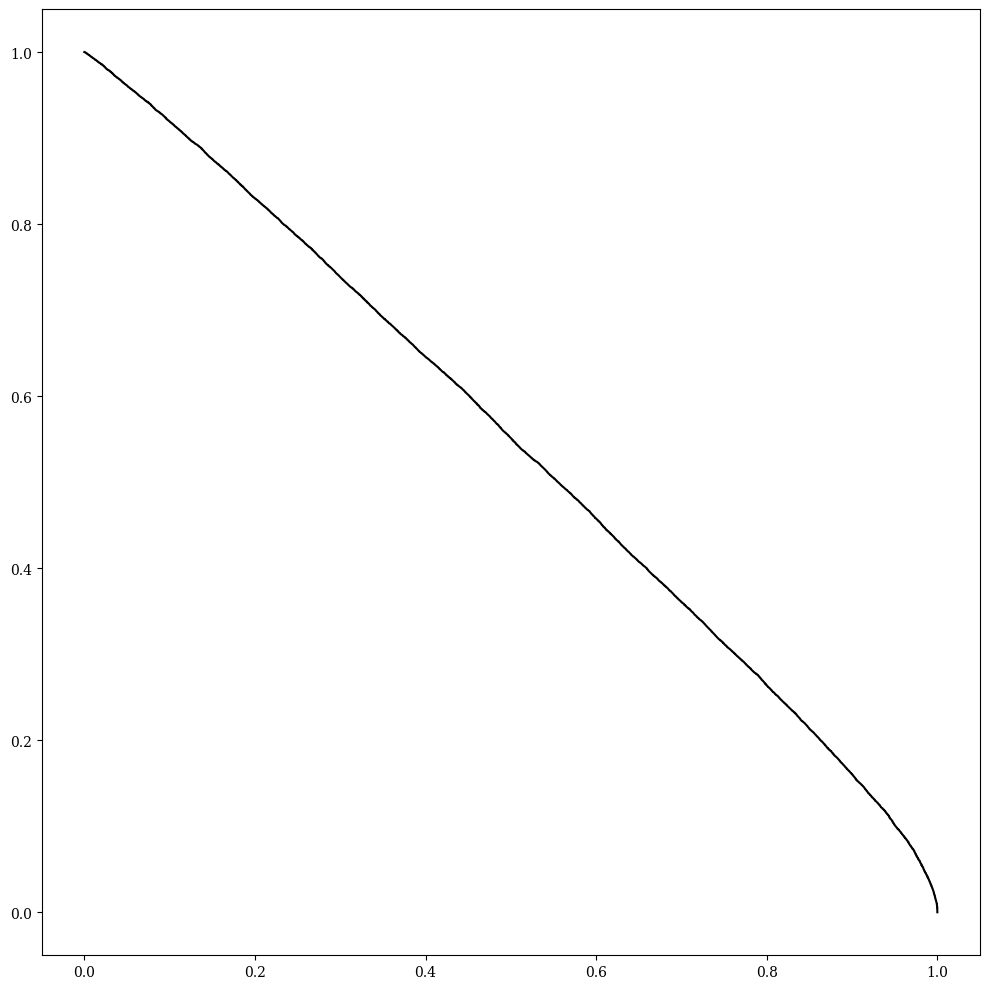

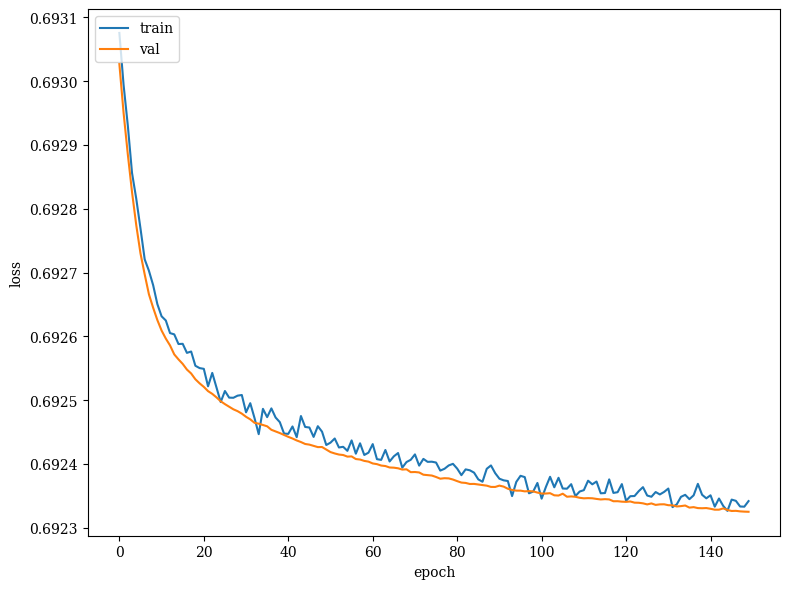

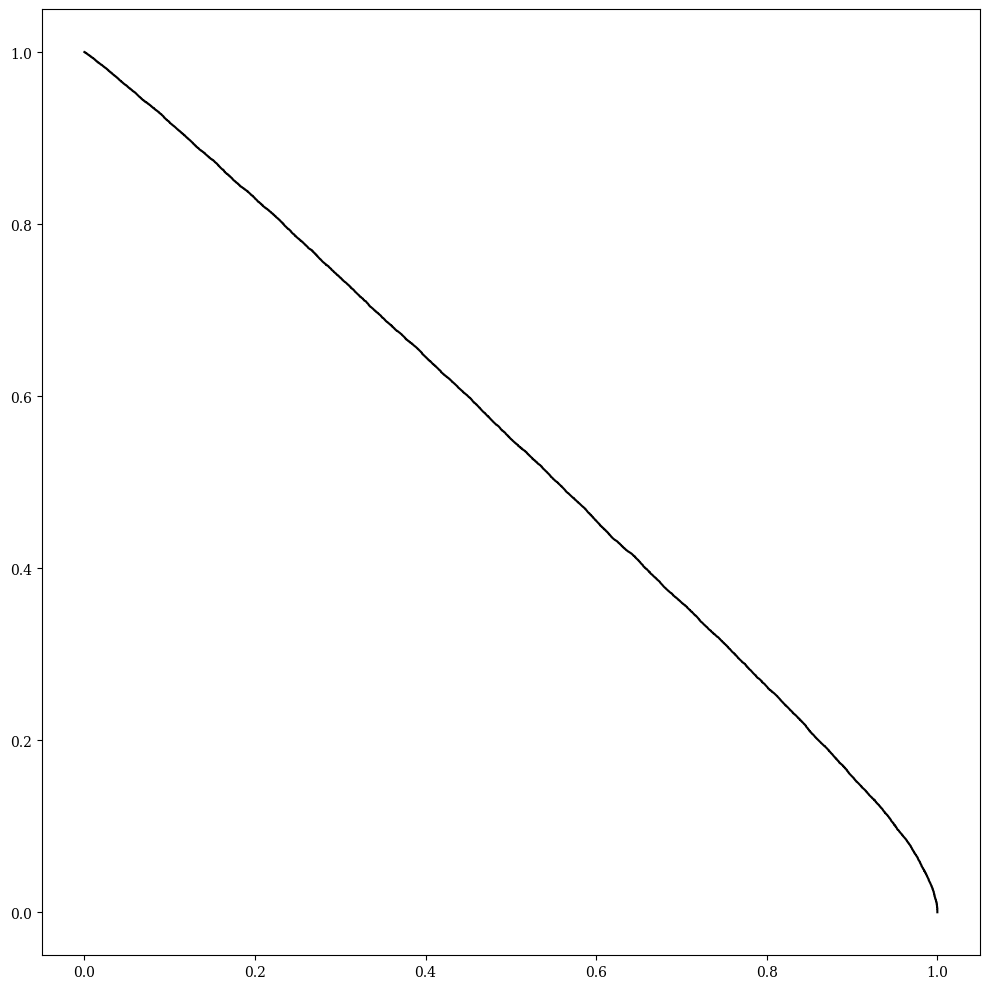

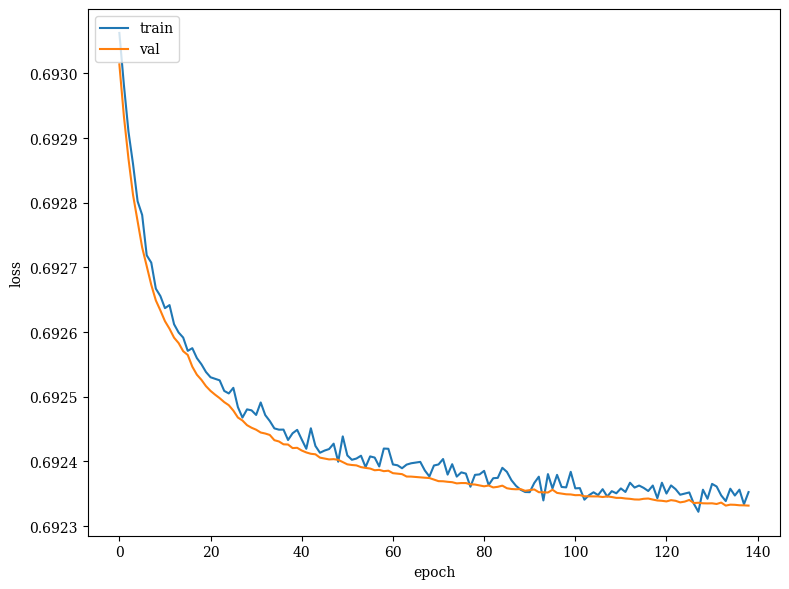

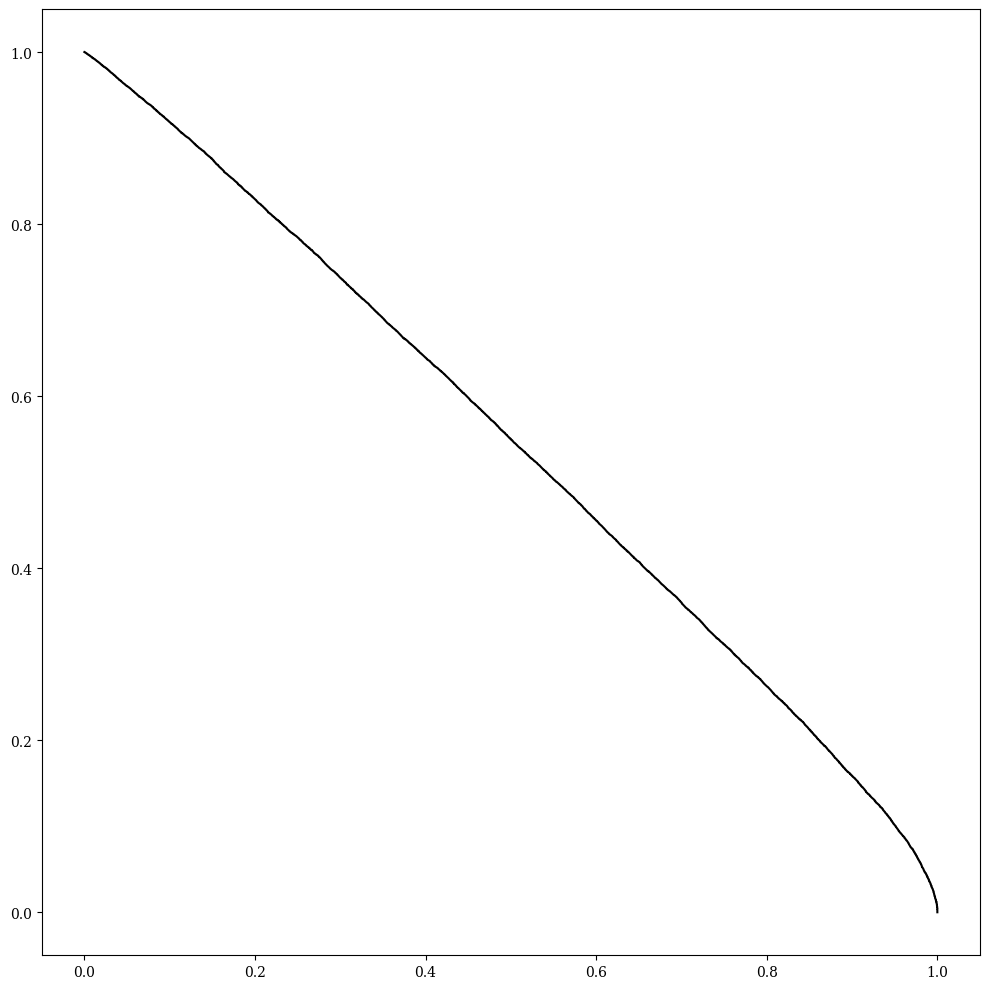

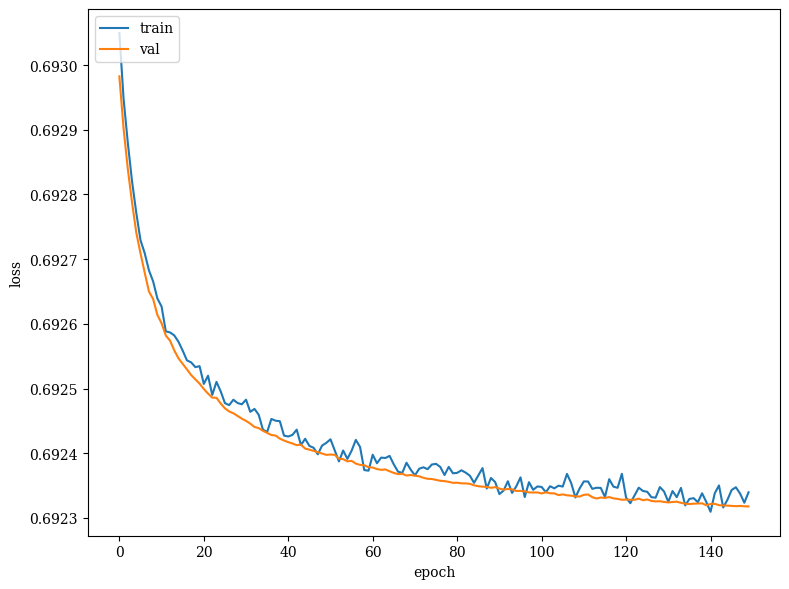

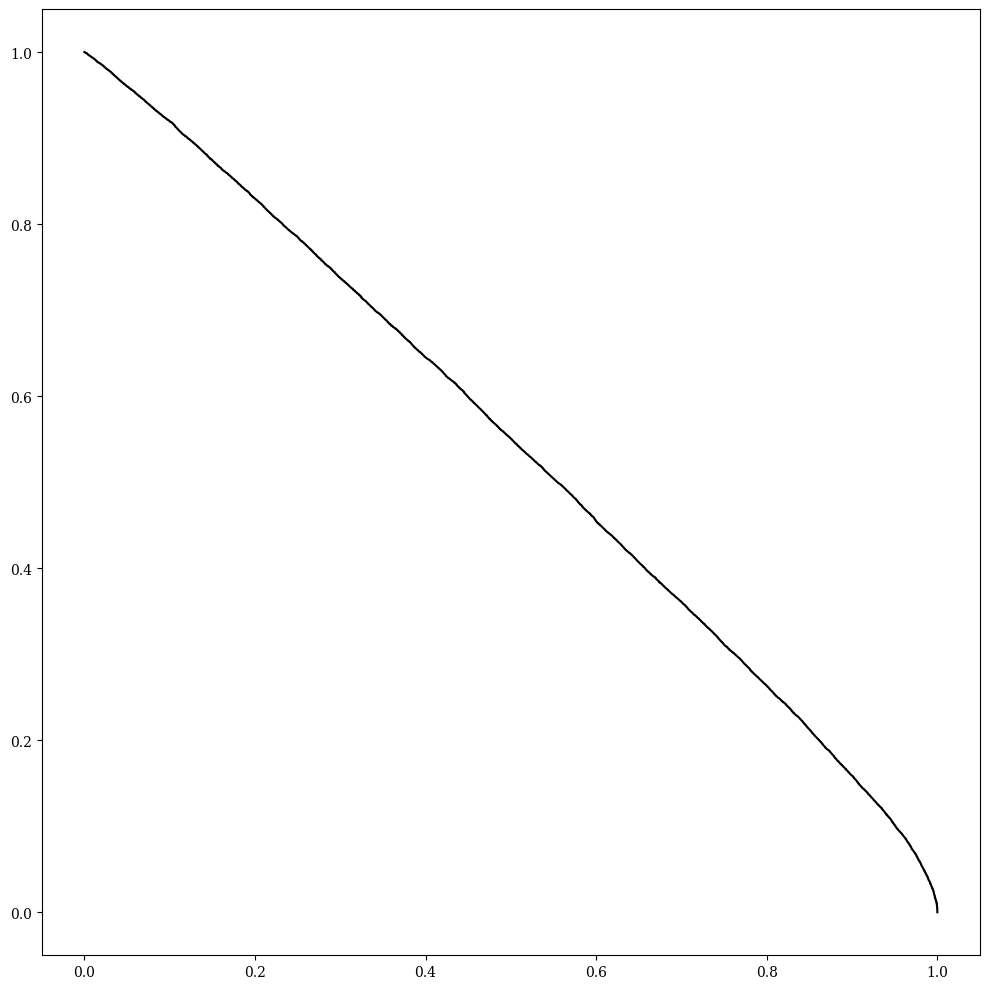

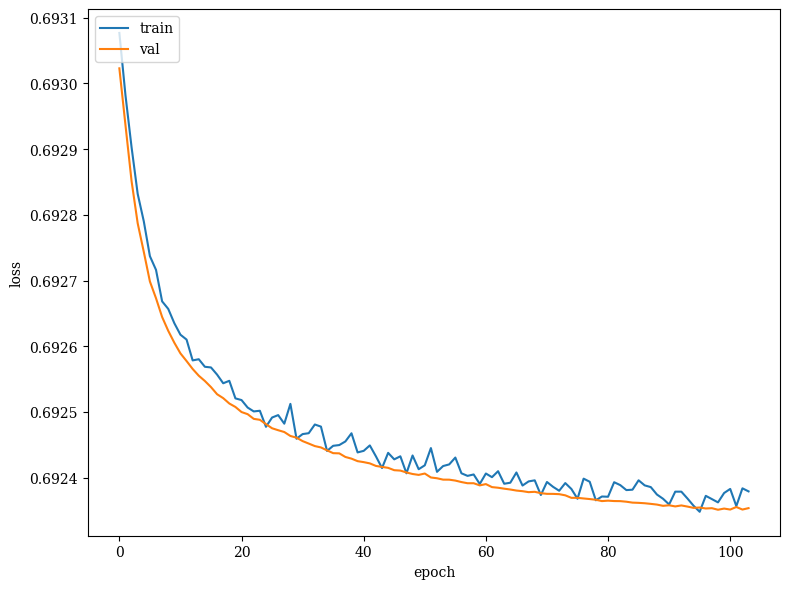

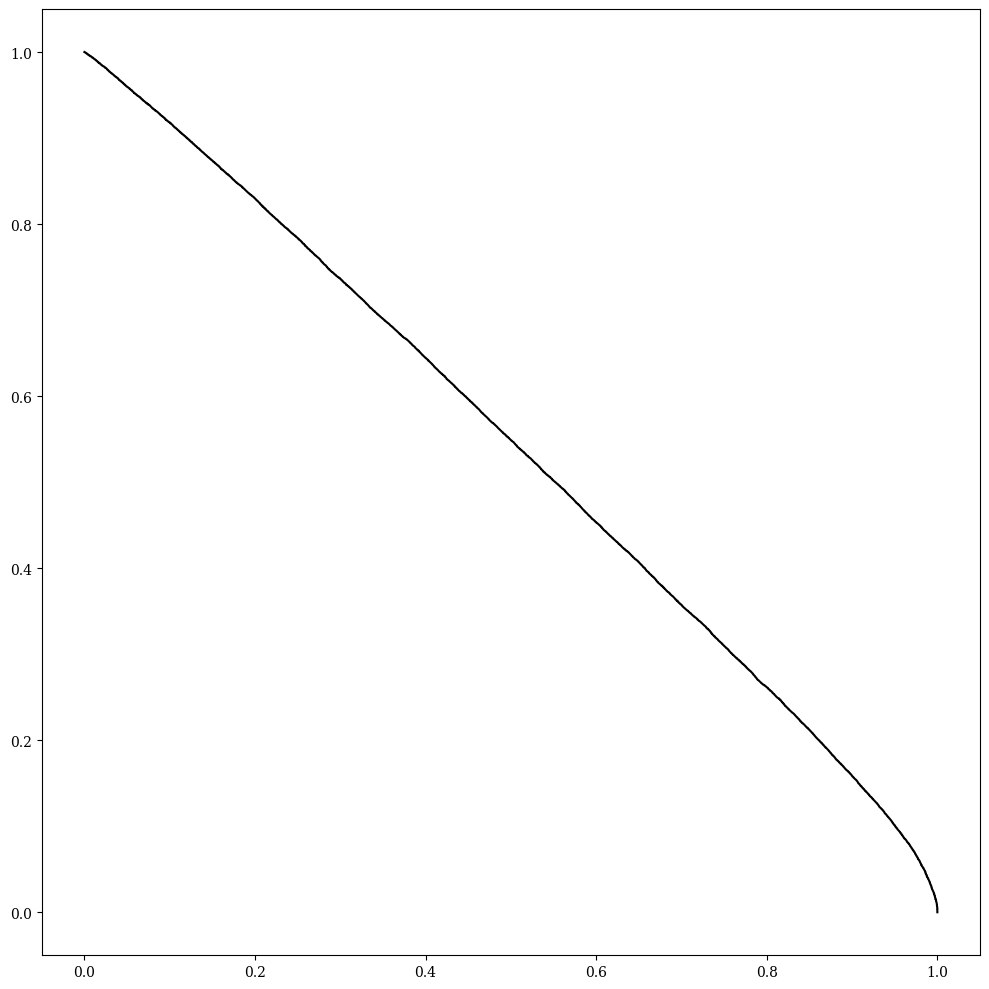

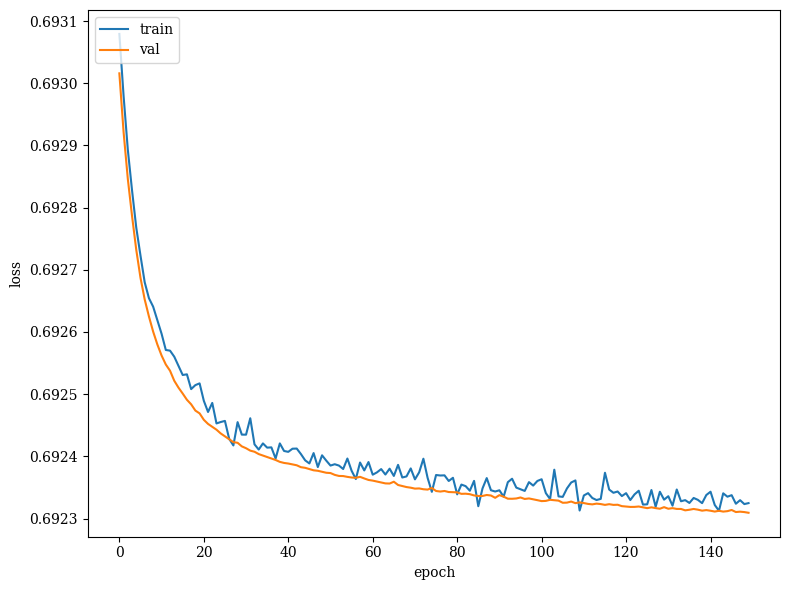

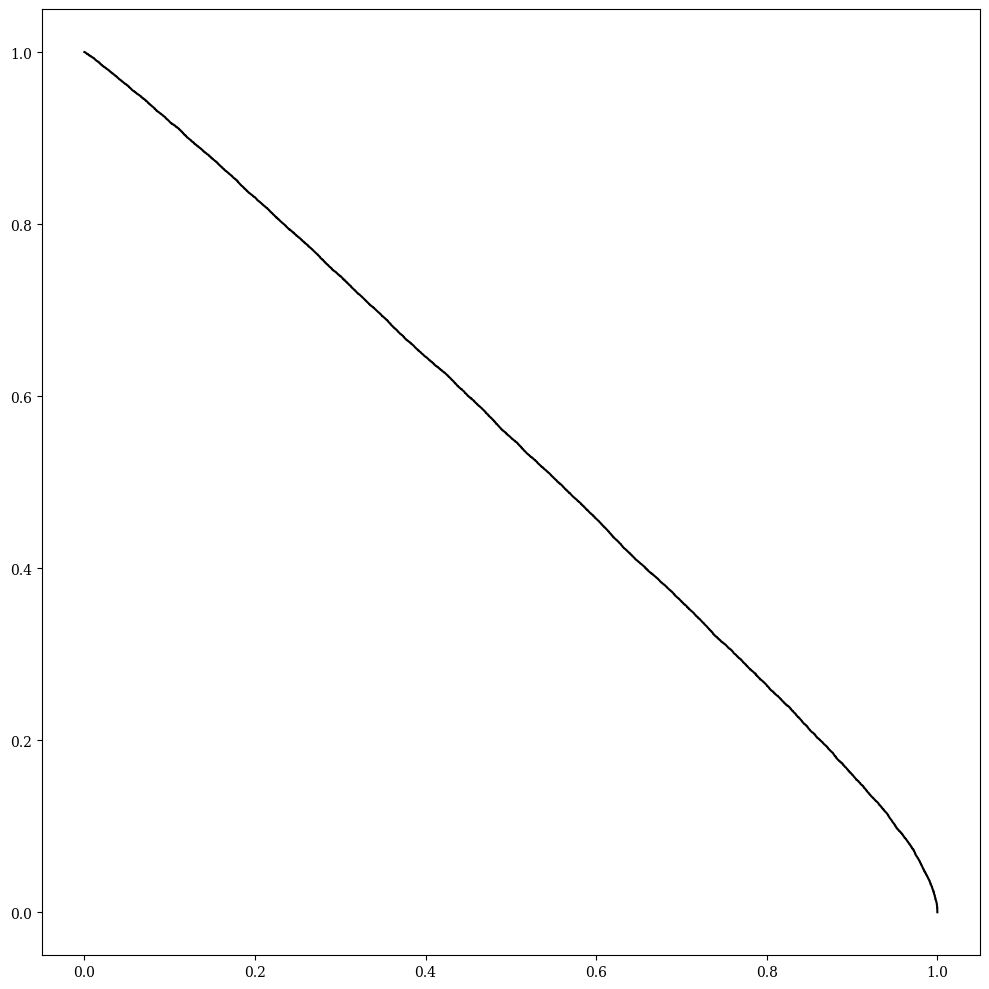

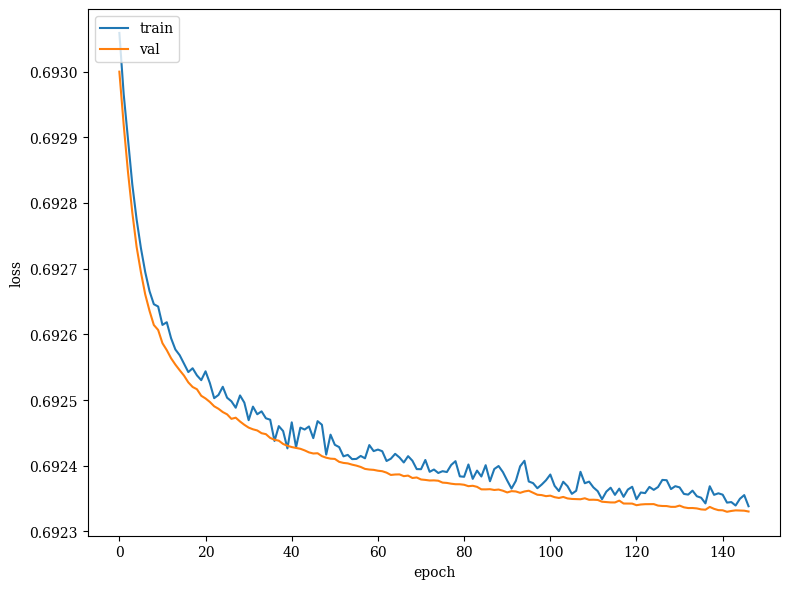

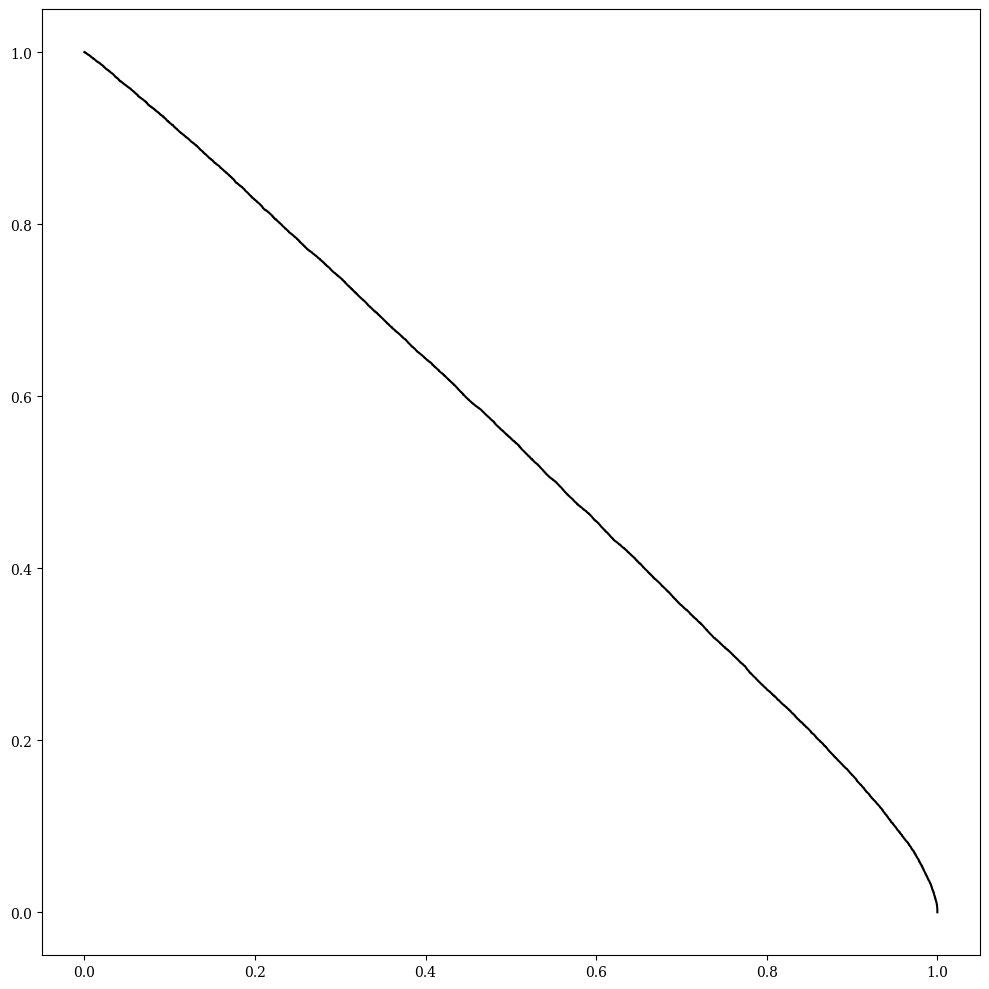

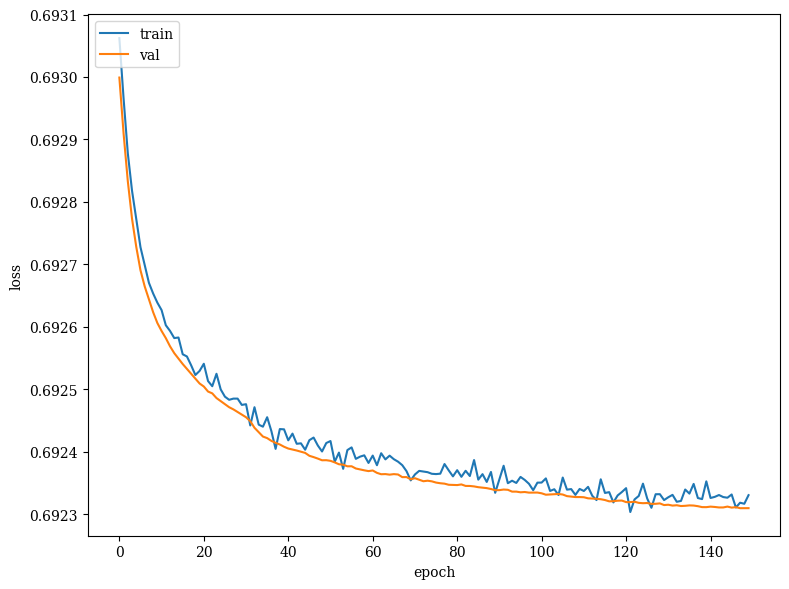

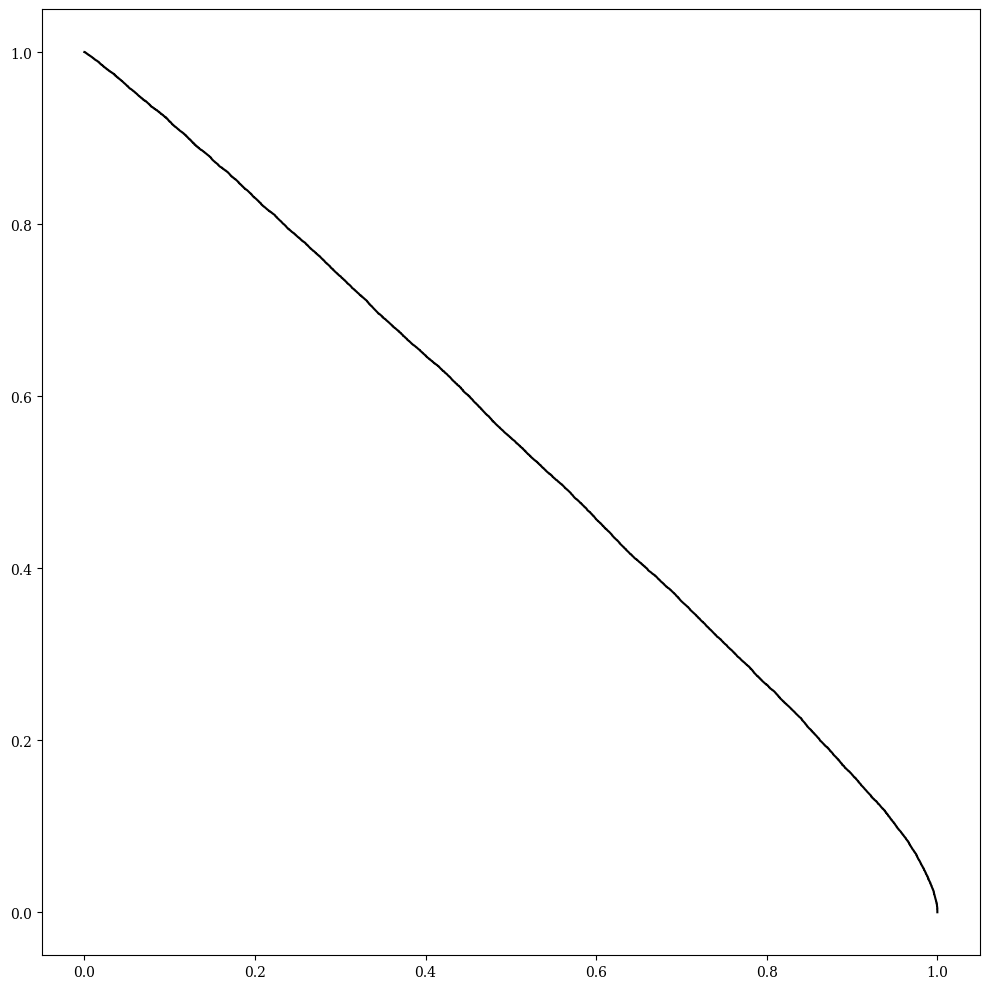

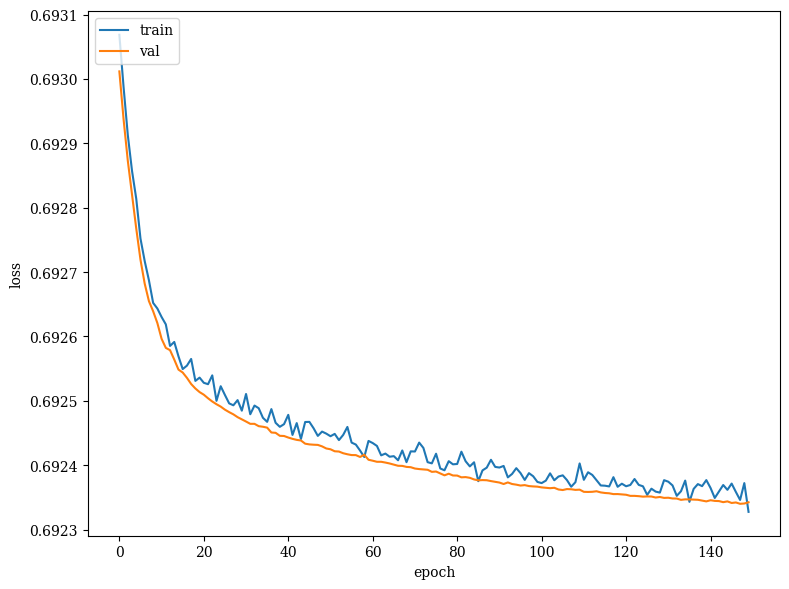

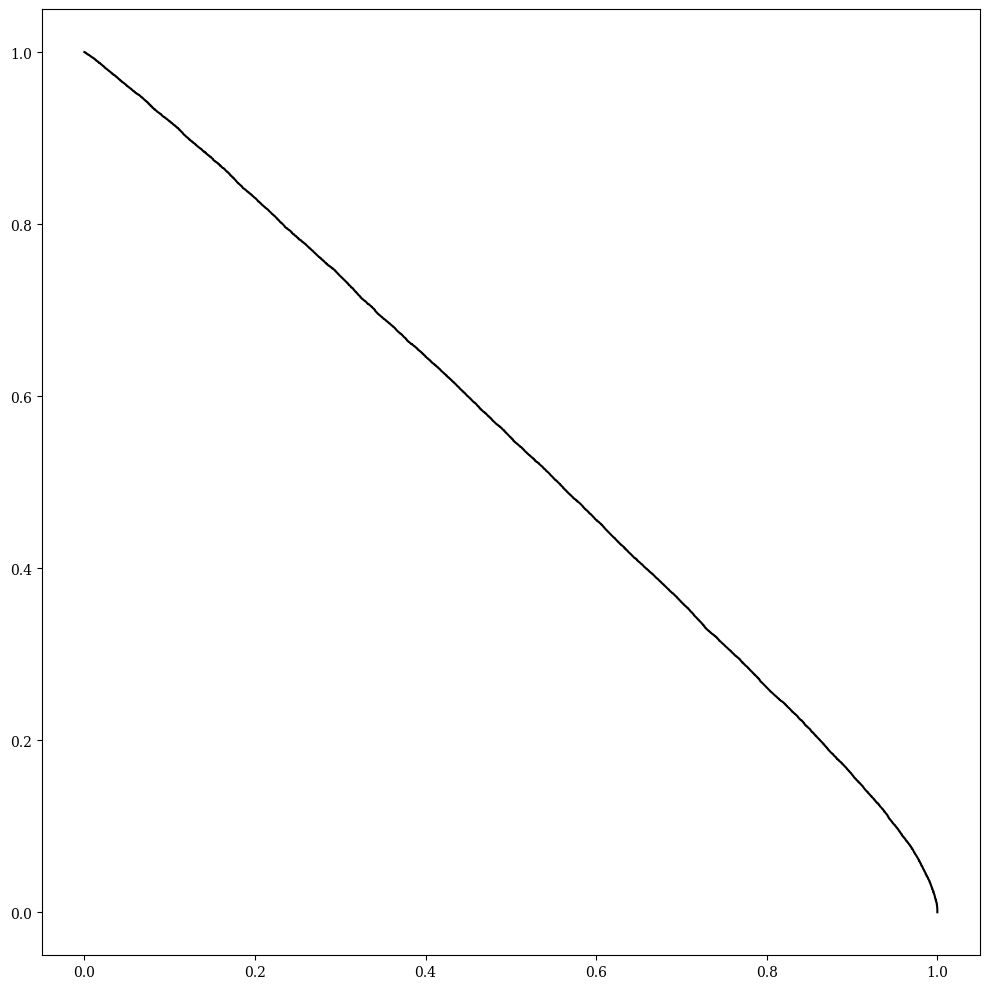

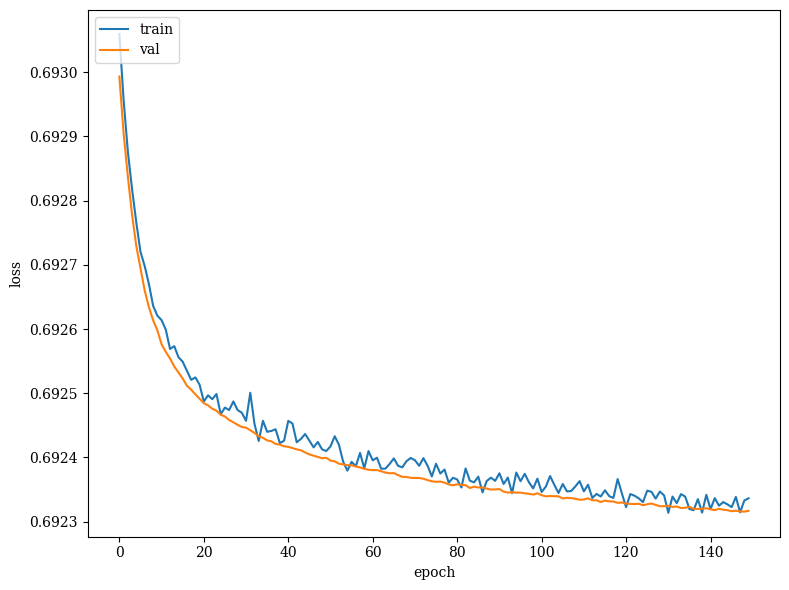

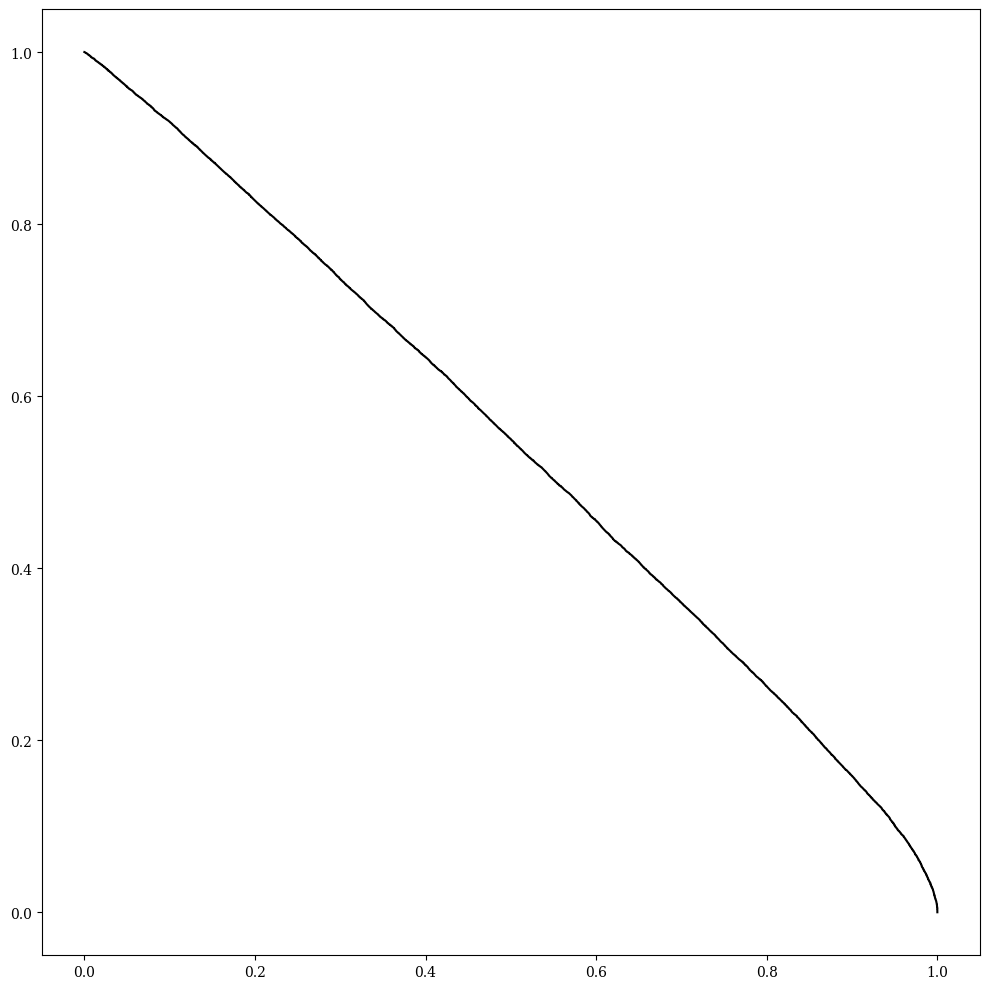

In [5]:
# EFN with spectral normalization
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":2,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    efn.save(f"keras_models_wta/gjet_spectralEFN_zpT_iter{i}.keras")
    del efn
    gc.collect()

## L = 2

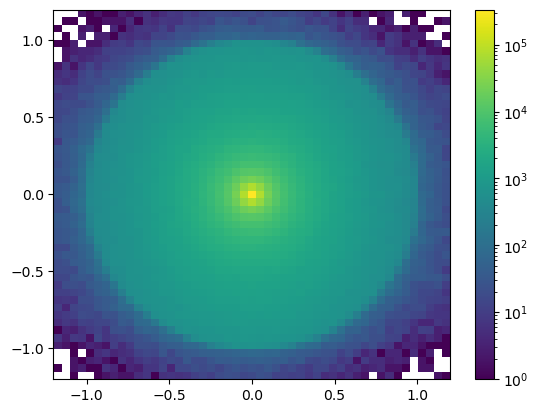

In [4]:
mask = test[test_labels[:,0]==1][:,:,0].flatten()>0
from matplotlib.colors import LogNorm
h = plt.hist2d(test[test_labels[:,0]==1][:,:,1].flatten()[mask],test[test_labels[:,0]==1][:,:,2].flatten()[mask],
               bins=np.linspace(-1.2,1.2,50),norm=LogNorm())
plt.colorbar()

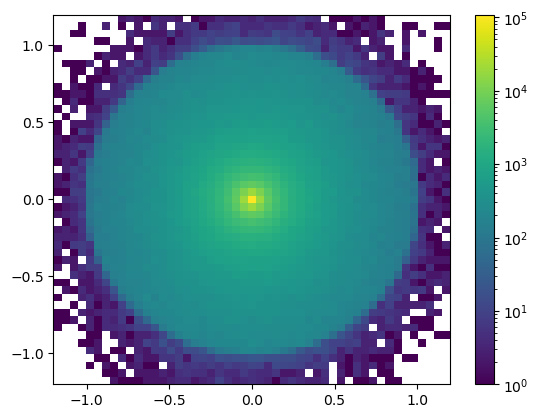

In [5]:
mask = test[test_labels[:,0]==0][:,:,0].flatten()>0
from matplotlib.colors import LogNorm
h = plt.hist2d(test[test_labels[:,0]==0][:,:,1].flatten()[mask],test[test_labels[:,0]==0][:,:,2].flatten()[mask],
               bins=np.linspace(-1.2,1.2,50),norm=LogNorm())
plt.colorbar()

In [ ]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 2
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save("keras_models_wta_Lsmall/gjet_EFN_zpT_L2.keras")
#del efn
gc.collect()

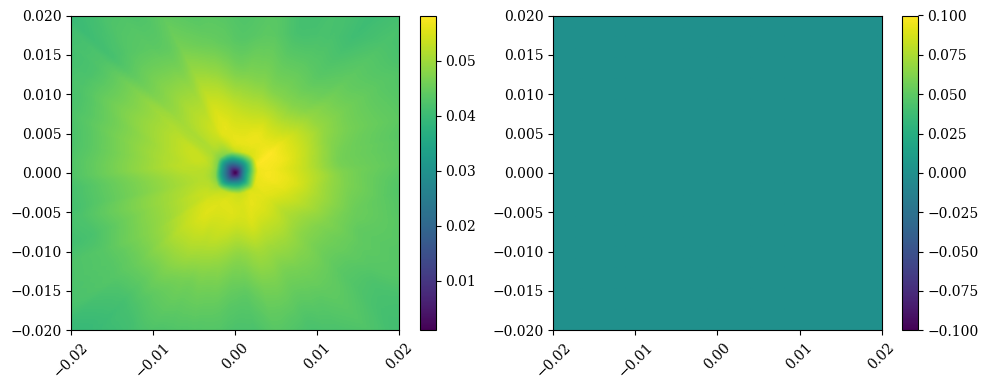

In [4]:
from matplotlib.colors import LogNorm, Normalize
R = 0.02
X,Y,Z = efn.eval_filters(R,prune=False,n=300)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

In [5]:
import tensorflow.keras.backend as K

In [6]:
s = efn.Phi_sizes[-1]
in_t, out_t = efn.inputs[1], efn._tensors[efn._tensor_inds['latent'][0]-1]
# construct function
kf = K.function(in_t,out_t)
kf2 = K.function(efn._tensors[efn._tensor_inds['latent'][1]-1],efn._tensors[-1])

In [7]:
nx=300
ny=300
xmax = 0.1
xmin = 0
ymax= 0.1
ymin = 0
xs, ys = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(xs, ys, indexing='ij')
XY = np.asarray([X, Y]).reshape((2, nx*ny)).transpose(1,0)
s = 1

# evaluate function
Z = kf2(XY).reshape(nx, ny)

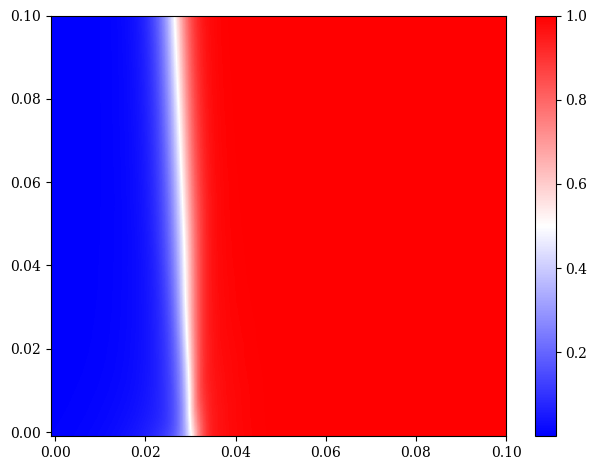

In [8]:
plt.imshow(Z.T,origin='lower',extent=[-0.001,xmax,-0.001,ymax],aspect='auto',cmap='bwr')
plt.colorbar()

## L = 1 study

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    300         ['phats_input[0][0]']            
                                                                                                  
 activation_7 (Activation)      (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation_7[0][0]']           
                                                                                            

1353

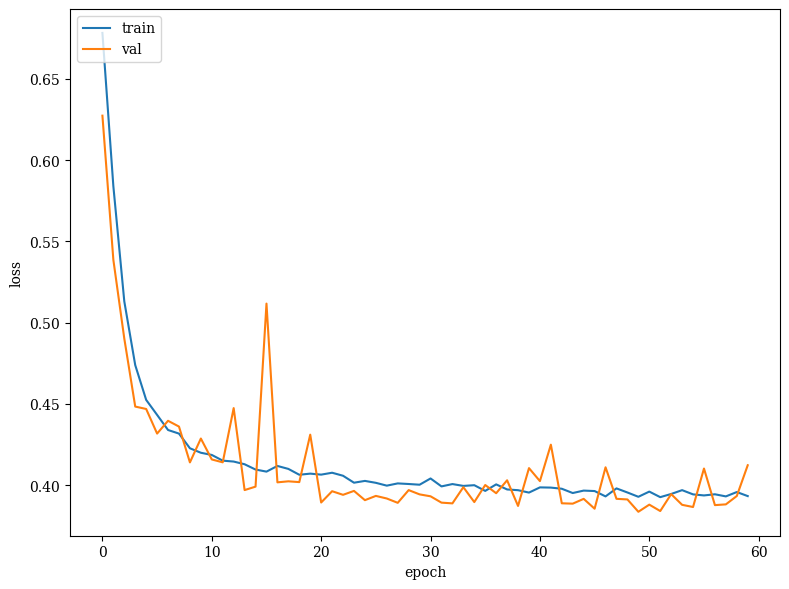

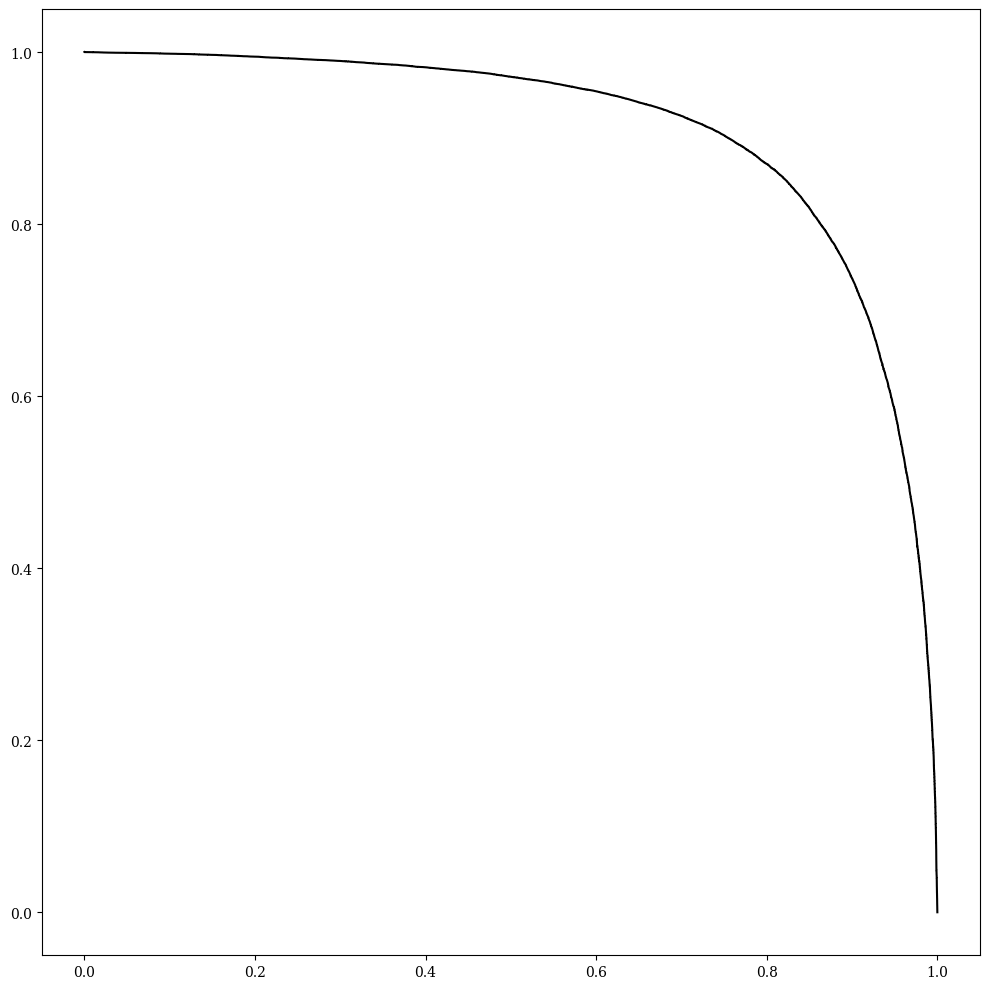

In [16]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 1
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = False
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models_wta_Lsmall/gjet_EFN_zpT_L1.keras")
#del efn
gc.collect()

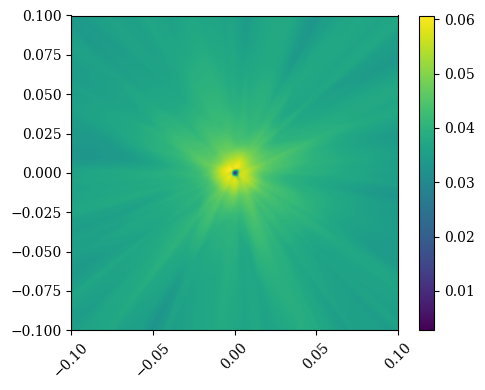

In [17]:
from matplotlib.colors import LogNorm, Normalize
from scipy.optimize import curve_fit
R = 0.1
X,Y,Z = efn.eval_filters(R,prune=False,n=1000)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,1,figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes)
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

/tmp/ipykernel_24961/3641381354.py:2: RuntimeWarning: invalid value encountered in log
  return a - b*np.log(x+c)


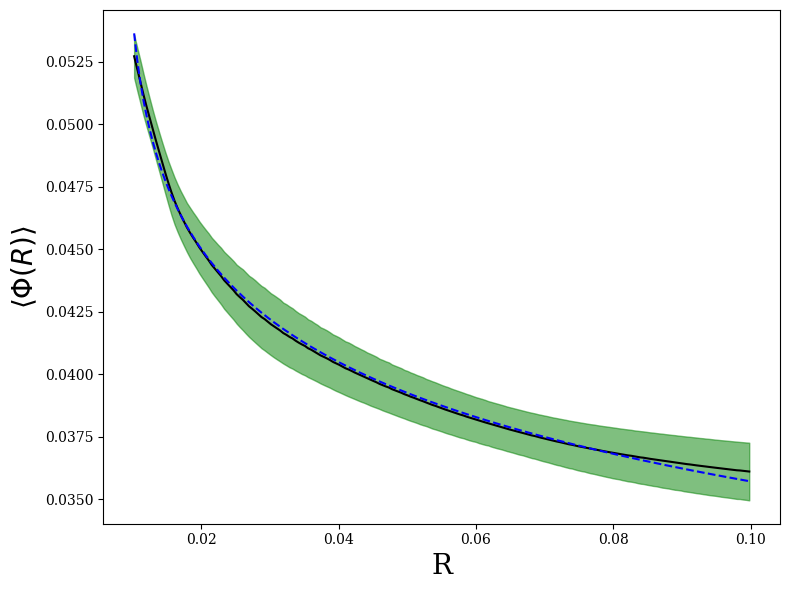

In [18]:
def log_func(x,a,b,c):
    return a - b*np.log(x+c)
R = np.sqrt(X**2 + Y**2)
rbins = np.linspace(0.01,0.1,200)
bin_centers = (rbins[:-1]+rbins[1:])/2
r_inds = np.digitize(R.flatten(),rbins)-1
z_means = np.array([np.mean(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])
z_stds = np.array([np.std(Z.flatten()[r_inds == i]) for i in range(len(bin_centers))])

remove = np.isnan(z_means) | np.isnan(z_stds)

popt, pcov = curve_fit(log_func, bin_centers[~remove], z_means[~remove], sigma=z_stds[~remove])
#popt, pcov = curve_fit(log_func, R.flatten(),Z.flatten())
plt.figure(figsize=(8,6))
plt.plot(bin_centers,z_means,zorder=2,color='black')
plt.fill_between(bin_centers,z_means+z_stds,z_means-z_stds,color='green',alpha=0.5,zorder=1)
plt.xlabel("R",fontsize=20)
plt.ylabel(r"$\langle \Phi(R) \rangle$",fontsize=20)
plt.plot(bin_centers,log_func(bin_centers,*popt),color='blue',linestyle='--')
#plt.plot(bin_centers,popt[0]*np.log(1/(0.01*bin_centers)))

## L = 2 Spectral

2023-10-04 20:05:04.696443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:05:05.204547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:05:05.204930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-04 20:05:05.205802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2023-10-04 20:05:09.497113: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/200
391/391 [==============================] - 14s 30ms/step - loss: 0.6930 - acc: 0.5178 - val_loss: 0.6929 - val_acc: 0.5260
Epoch 2/200
391/391 [==============================] - 10s 27ms/step - loss: 0.6928 - acc: 0.5174 - val_loss: 0.6929 - val_acc: 0.5033
Epoch 3/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6927 - acc: 0.5161 - val_loss: 0.6927 - val_acc: 0.5211
Epoch 6/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6927 - acc: 0.5168 - val_loss: 0.6927 - val_acc: 0.5187
Epoch 7/200
391/391 [==============================] - 11s 28ms/step - loss: 0.6927 - acc: 0.5158 - val_loss: 0.6927 - val_acc: 0.5105
Epoch 8/200
391/391 [==============================] - 10s 27ms/step - loss: 0.6927 - acc: 0.5156 - val_loss: 0.6926 - val_acc: 0.5161
Epoch 9/200
391/391 [==============================] - 10s 26ms/step - loss: 0.6927 - acc: 0.5162 - val_loss: 0.6926 - val_acc: 0.5181
Epoch 10/200
391/391 [==============================] -

694

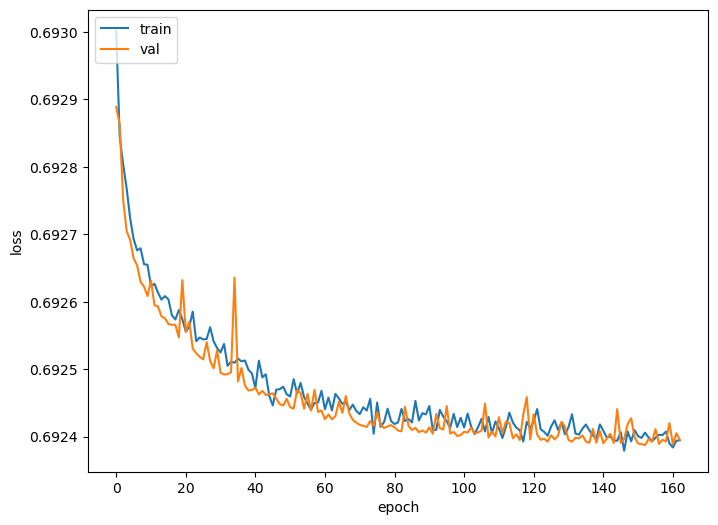

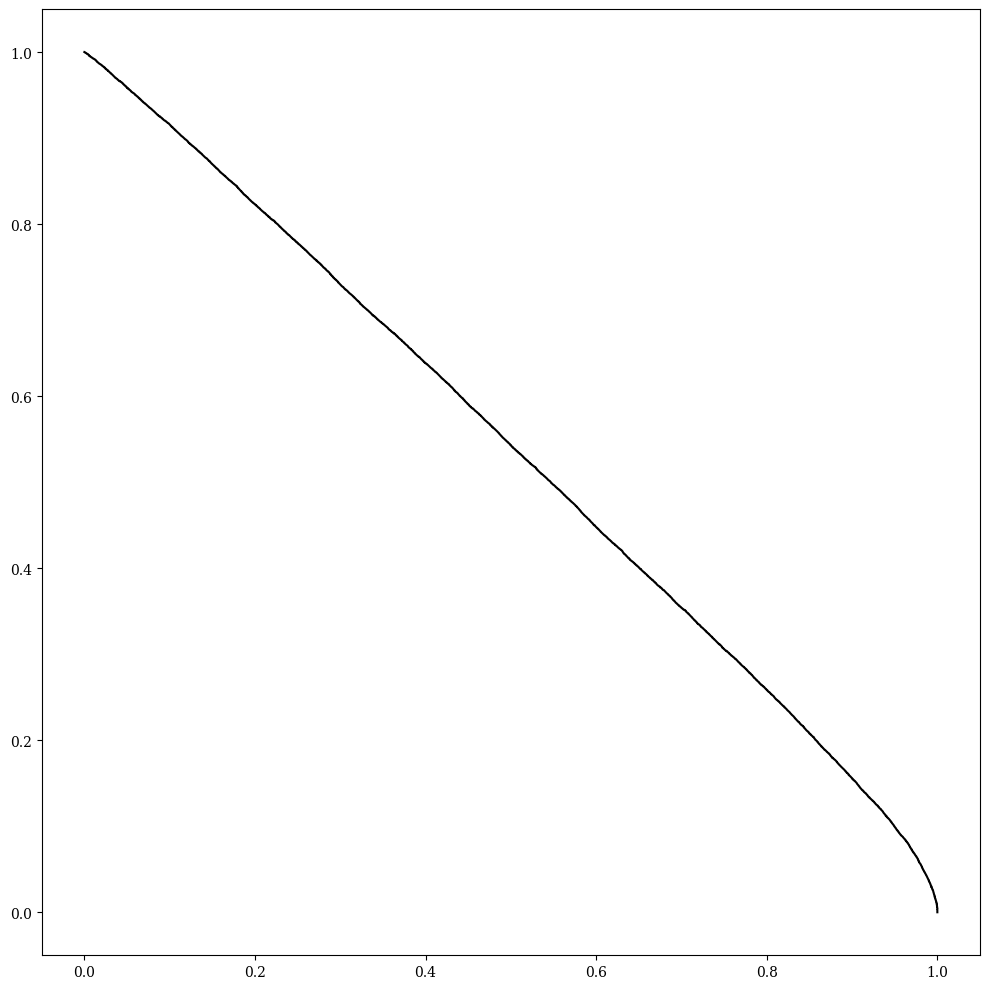

In [4]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 2
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":200,"verbose":1,"batch_size":512}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
efn.save(f"keras_models_wta_Lsmall/gjet_spectralEFN_zpT_L2.keras")
#del efn
gc.collect()

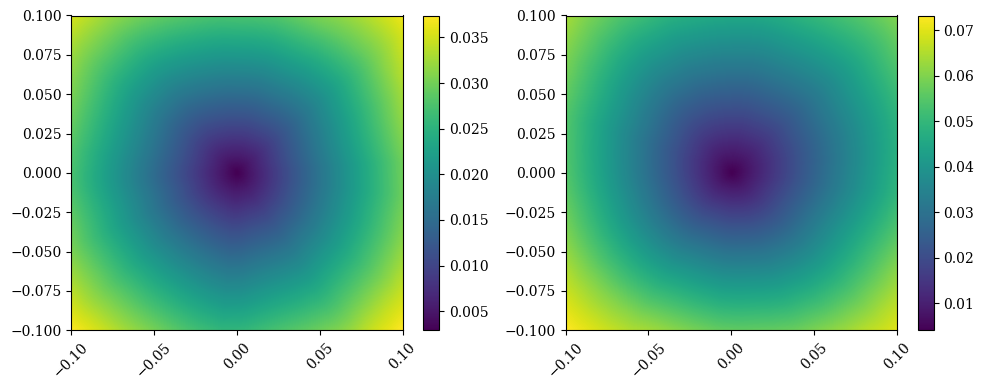

In [7]:
from matplotlib.colors import LogNorm, Normalize
R = 0.1
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
for i in range(len(Z)):
    plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)

## L = 1 Spectral

2023-10-05 19:45:27.963573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 19:45:27.999833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 19:45:28.000112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-05 19:45:28.000947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    601         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    20201       ['activation[0][0]']             
                                                                                              

2023-10-05 19:45:30.296615: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/150
20/20 [==============================] - 5s 179ms/step - loss: 0.6931 - acc: 0.5200 - val_loss: 0.6931 - val_acc: 0.5310
Epoch 2/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6931 - acc: 0.5154 - val_loss: 0.6931 - val_acc: 0.5314
Epoch 3/150
20/20 [==============================] - 3s 141ms/step - loss: 0.6930 - acc: 0.5274 - val_loss: 0.6930 - val_acc: 0.5247
Epoch 4/150
20/20 [==============================] - 3s 144ms/step - loss: 0.6930 - acc: 0.5278 - val_loss: 0.6930 - val_acc: 0.5185
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6930 - acc: 0.5182 - val_loss: 0.6929 - val_acc: 0.5219
Epoch 6/150
20/20 [==============================] - 3s 139ms/step - loss: 0.6929 - acc: 0.5174 - val_loss: 0.6929 - val_acc: 0.5150
Epoch 7/150
20/20 [==============================] - 3s 145ms/step - loss: 0.6929 - acc: 0.5172 - val_loss: 0.6929 - val_acc: 0.5184
Epoch 8/150
20/20 [==============================] - 3s 138ms/step - 

694

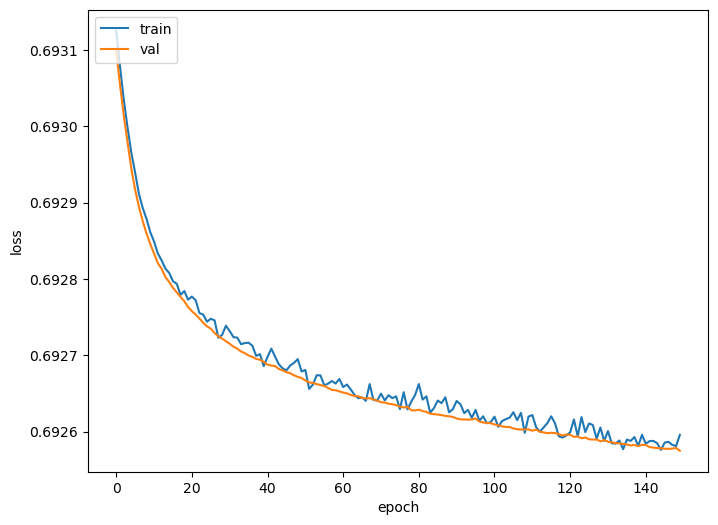

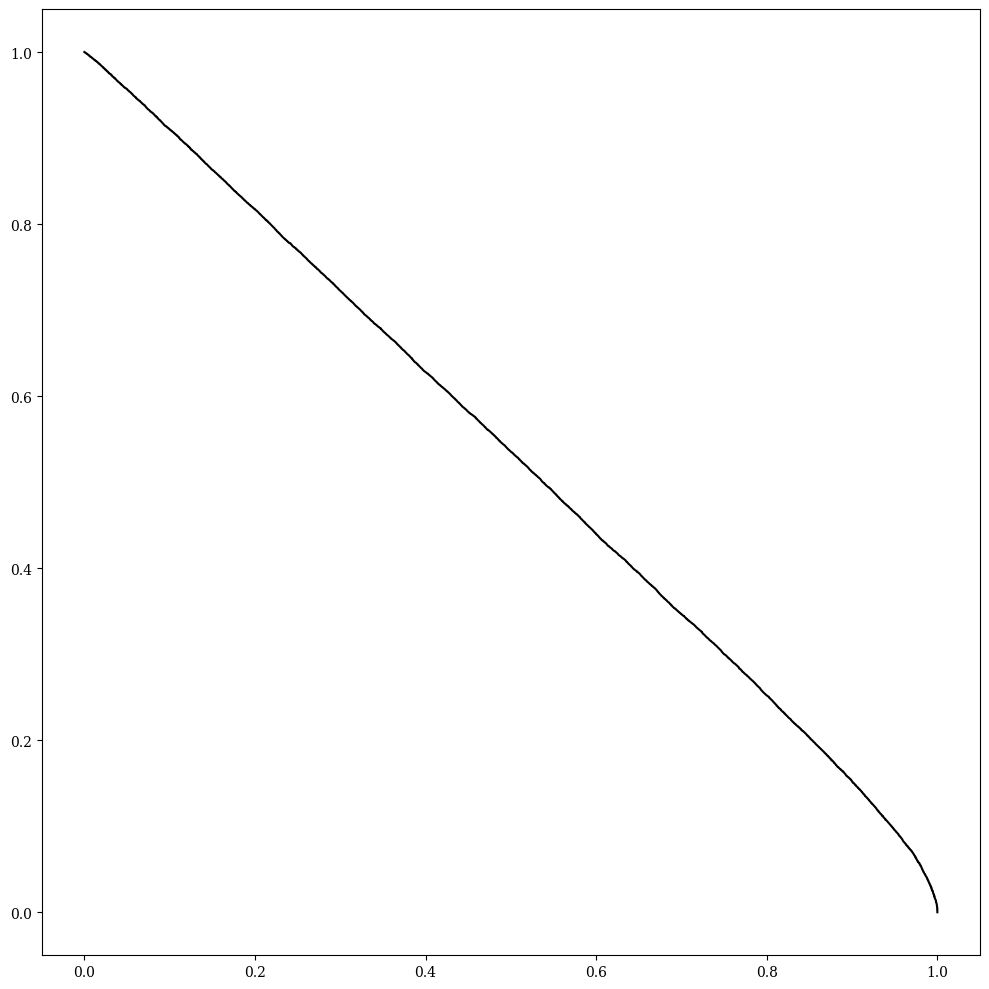

In [3]:
# Regular EFN, no spectral normalization
loss = BinaryCrossentropy(from_logits=False)
L = 1
model_kwargs = {"Phi_sizes":(100,100,L), "F_sizes":(100,100,100),
                "F_dropouts":0.1,
                "input_dim":2,
                "output_dim":1,"output_act":"sigmoid",
                "patience":10,
                "optimizer":Adam(1e-4),
                "loss":loss,
                "summary":True}
model_kwargs['spectral'] = True
train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
efn, auc, efn_fp, efn_tp, threshs = train_efn((train,train_labels),
                                              (test,test_labels),
                                              (val,val_labels),
                                              model_kwargs,
                                              train_kwargs,
                                              plot=True)
#del efn
gc.collect()

In [5]:
efn.save(f"keras_models_wta_Lsmall/gjet_spectralEFN_zpT_L1.keras")

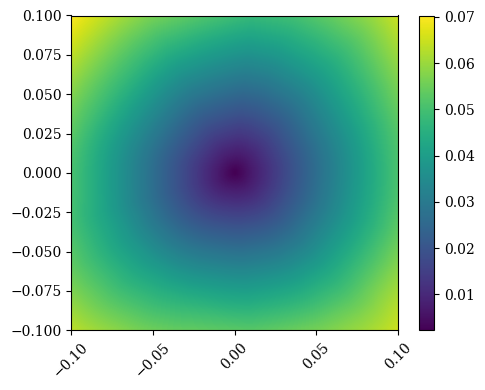

In [4]:
from matplotlib.colors import LogNorm, Normalize
R = 0.1
n=300
X,Y,Z = efn.eval_filters(R,prune=False,n=n)
colors = ["Reds","Blues","Greens","Oranges","Purples","Greys","YlOrBr","RdPu"]
#fig,axes = plt.subplots(1,len(Z),figsize=(5*len(Z),4))
plt.figure(figsize=(5,4))
for i in range(len(Z)):
    #plt.sca(axes.flatten()[i])
    #norm = Normalize() if np.all(Z[i] == 0) else LogNorm()
    norm = Normalize()
    plt.imshow(Z[i].T,origin='lower',extent=[-R,R,-R,R],aspect='auto',norm=norm)
    plt.colorbar()
    plt.xticks(rotation=45)